# Import libraries

In [1]:
import pandas as pd
import numpy as np
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict 
import multiprocessing
from gensim.models import Word2Vec

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy import sparse
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import TruncatedSVD
# from sklearn.metrics import pairwise_distances_argmin_min

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

warnings.filterwarnings('ignore')

# Functions

### Find the best K (number of clusters) in KMeans
Try different number of clusters and metrics in order to find the best K.

In [2]:
def find_k(X, k_min, k_max):
    
    K = range(k_min, k_max)
    
    # Inertia
    inertia = []

    for k in K:
        kmeans = KMeans(n_clusters=k, max_iter=100, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
        
    print("Elbow visualization: Inertia")
    plt.figure(figsize=(16,8))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.xticks(np.arange(min(K), max(K)+1, 1.0))
    plt.show()
    
    # Elbow Visualizer (Yellowbrick)
    model = KMeans(max_iter=100, random_state=42)
    visualizer = KElbowVisualizer(model, k=(k_min, k_max))

    visualizer.fit(X)    
    print("Elbow visualization: Distortion Score (KElbowVisualizer)")
    visualizer.poof() 
    
    # Silhouette score
    silhouette = []

    for k in K:
        kmeans = KMeans(n_clusters=k, max_iter=100, random_state=42)
        kmeans.fit(X)
        silhouette.append(silhouette_score(X, kmeans.predict(X)))

    print("Silhouette score")
    plt.figure(figsize=(16,8))
    plt.plot(K, silhouette, 'bx-')
    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.xticks(np.arange(min(K), max(K)+1, 1.0))
    plt.show()

### Metrics to compare between models
- **Silhoutte score**: measures the quality of clustering by considering both the compactness of clusters and the separation between clusters. It ranges from -1 to 1, with higher values indicating better clustering.

In [3]:
def clustering_metrics(X, clusters):

    metrics = {}
    
    # Silhouette score
    metrics['Silhouette'] = silhouette_score(X, clusters)

    return metrics

### Visualize the clusters
In order to plot the results we need to perform feature transformation and reduce the dimensionality to 2 features. For that purpose we will apply TruncatedSVD, since it can handle sparse input such as the TF-IDF matrix (PCA does not handle sparse input).

In [4]:
def plot_clusters_kmeans(X, k):
    
    # Reduce dimensionality with TruncatedSVD (can handle sparse input)
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2D = svd.fit_transform(X)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_2D)
    clusters = kmeans.predict(X_2D)

    # Plot the results
    labels = np.unique(clusters)

    for i in labels:
        plt.scatter(X_2D[clusters == i , 0] , X_2D[clusters == i , 1] , label = i)
    plt.legend()
    plt.show()

In [5]:
def plot_clusters_dbscan(X, eps):
    
    # Reduce dimensionality with TruncatedSVD (can handle sparse input)
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2D = svd.fit_transform(X)

    # DBSCAN
    dbscan = DBSCAN(eps=eps)
    clusters = dbscan.fit_predict(X_2D)

    # Plot the results
    labels = np.unique(clusters)

    for i in labels:
        plt.scatter(X_2D[clusters == i , 0] , X_2D[clusters == i , 1] , label = i)
    plt.legend()
    plt.show()

In [6]:
def plot_clusters_gaussian(X, n_components):
    
    # Reduce dimensionality with TruncatedSVD (can handle sparse input)
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2D = svd.fit_transform(X)

    # Gaussian Mixtures
    model = GaussianMixture(n_components, random_state=42)
    clusters = model.fit_predict(X_2D)

    # Plot the results
    labels = np.unique(clusters)

    for i in labels:
        plt.scatter(X_2D[clusters == i , 0] , X_2D[clusters == i , 1] , label = i)
    plt.legend()
    plt.show()

# Load the data

In [7]:
vinissimus = pd.read_csv("C:/Users/mboll/OneDrive/Documentos/DATA/Ironhack/Final_project/02-cleaning/vinissimus_short_clean.csv")
vinissimus.head()

wine    year                  winery  \
0            Ultreia Saint Jacques 2021  2021.0   Raúl Pérez Viticultor   
1                        Blanc Pescador     NaN                Perelada   
2  Bach Extrísimo Blanco Semidulce 2021  2021.0              Masia Bach   
3            José Pariente Verdejo 2022  2022.0  Bodegas José Pariente    
4             Coto de Imaz Reserva 2018  2018.0        El Coto de Rioja   

             winery_norm  price  bottle  type_wine type_wine_details  \
0  raul perez viticultor   16.2    0.75        Red               Red   
1               perelada    7.8    0.75  Sparkling   Frizzante white   
2             masia bach    9.4    0.75      White             White   
3         jose pariente    16.2    0.75      White             White   
4       el coto de rioja   13.0    0.75        Red               Red   

  type_agriculture            region  ...            serve_temperature  \
0     Conventional   Castilla y León  ...  Serve between 14ºC and 16ºC   
1     Conventional  Wines without GI  ...                          NaN   
2     Conventional          Cataluña  ...                          NaN   
3     Conventional   Castilla y León  ...    Serve between 6ºC and 8ºC   
4     Conventional          La Rioja  ...  Serve between 16ºC and 18ºC   

                                        food_pairing alcohol_content  \
0       Sausages and hamRed meatStews and casseroles            13.5   
1  Snacks and appetizersStarters and suppersSalad...            11.5   
2  Snacks and appetizersStarters and suppersSeafo...            11.5   
3  FishSaladsStarters and suppersVegetablesSoft c...            13.0   
4          Sausages and hamRed meatGameCured cheeses            13.5   

  customer_reviews customer_reviews_number parker_score parker_score_num  \
0              4.2                   217.0          NaN              NaN   
1              4.4                    45.0          NaN              NaN   
2              4.8                    95.0          NaN              NaN   
3              4.4                   147.0          NaN              NaN   
4              4.4                    94.0          NaN              NaN   

  penin_score                                              image  \
0         NaN  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
1         NaN  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
2         NaN  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
3         NaN  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
4         NaN  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   

                                                 url  
0  https://www.vinissimus.com/en/wine/ultreia-sai...  
1  https://www.vinissimus.com/en/wine/blanc-pesca...  
2  https://www.vinissimus.com/en/wine/bach-extris...  
3  https://www.vinissimus.com/en/wine/jose-parien...  
4  https://www.vinissimus.com/en/wine/coto-de-ima...  

[5 rows x 28 columns]

# Feature selection
Here we will use the features for different ends:
- **Clustering**: tasting-related features
- **Features for filtering the results of the recommender**: price, region (geographical indication), type of wine, grapes, type of agriculture...
- **Additional info to be displayed by the recommender**: the picture of the wine, brief info about the wine, how to serve (temperature of serving, food pairing...). Add also the link to buy the wine?

In [8]:
wine_data = vinissimus[['wine', 'price', 'type_wine', 'type_wine_details', 
                               'type_agriculture', 'region_gi', 'grapes', 'wine_description',
                               'tasting_descr', 'tasting_view', 'tasting_bouquet','tasting_mouth',
                               'serve_temperature', 'food_pairing', 'image', 'url']]

wine_data.head()

wine  price  type_wine type_wine_details  \
0            Ultreia Saint Jacques 2021   16.2        Red               Red   
1                        Blanc Pescador    7.8  Sparkling   Frizzante white   
2  Bach Extrísimo Blanco Semidulce 2021    9.4      White             White   
3            José Pariente Verdejo 2022   16.2      White             White   
4             Coto de Imaz Reserva 2018   13.0        Red               Red   

  type_agriculture         region_gi                                grapes  \
0     Conventional            Bierzo                            ['Mencia']   
1     Conventional  Wines without GI  ['Macabeo', 'Parellada', 'Xarel·lo']   
2     Conventional         Catalunya               ['Xarel·lo', 'Macabeo']   
3     Conventional             Rueda                           ['Verdejo']   
4     Conventional             Rioja                       ['Tempranillo']   

                                    wine_description  \
0  Ultreia Saint Jacques is one of the best wines...   
1  Blanc Pescador and Cresta Rosa have been bench...   
2  The Extrísimo Semidulce from Masia Bach is a h...   
3  The José Pariente Verdejo is one of the great ...   
4  The Coto de Imaz Reserva is an intense and sil...   

                                       tasting_descr  \
0  Bottled unclarified and unfiltered, Ultreia Sa...   
1  A pale colour, with light yellow-green hues an...   
2  In 1915, brothers Pere and Ramon Bach i Escope...   
3  A golden colour in the glass with greenish hig...   
4  At first sight, it appears a vivid cherry colo...   

                                   tasting_view  \
0                                       Intense   
1  Straw yellow / Pale / Greenish hues / Bright   
2       Yellow / Golden glints / Clean / Bright   
3                Straw yellow / Greenish glints   
4          Picota cherry / Intense / Garnet rim   

                                     tasting_bouquet  \
0                                Raspberry / Violets   
1           Aromatic / Fruit aromas / Higly aromatic   
2  Higly aromatic / Complex / Fruit aromas / Flor...   
3           White fruit / Apricot / Fennel / Aniseed   
4                 Ripe fruit / Spicy notes / Complex   

                                       tasting_mouth  \
0   Red fruit / Mineral / Voluminous / Medium-bodied   
1                       Light / Pleasant / Sparkling   
2  Good entry / Structured / Balanced / Good acid...   
3              Rich / Unctuous / Pleasant bitterness   
4         Fleshy / Powerful / Ripe tannins / Velvety   

             serve_temperature  \
0  Serve between 14ºC and 16ºC   
1                          NaN   
2                          NaN   
3    Serve between 6ºC and 8ºC   
4  Serve between 16ºC and 18ºC   

                                        food_pairing  \
0       Sausages and hamRed meatStews and casseroles   
1  Snacks and appetizersStarters and suppersSalad...   
2  Snacks and appetizersStarters and suppersSeafo...   
3  FishSaladsStarters and suppersVegetablesSoft c...   
4          Sausages and hamRed meatGameCured cheeses   

                                               image  \
0  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
1  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
2  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
3  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
4  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   

                                                 url  
0  https://www.vinissimus.com/en/wine/ultreia-sai...  
1  https://www.vinissimus.com/en/wine/blanc-pesca...  
2  https://www.vinissimus.com/en/wine/bach-extris...  
3  https://www.vinissimus.com/en/wine/jose-parien...  
4  https://www.vinissimus.com/en/wine/coto-de-ima...

In [9]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5345 entries, 0 to 5344
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wine               5345 non-null   object 
 1   price              5345 non-null   float64
 2   type_wine          5345 non-null   object 
 3   type_wine_details  5345 non-null   object 
 4   type_agriculture   5345 non-null   object 
 5   region_gi          5345 non-null   object 
 6   grapes             5345 non-null   object 
 7   wine_description   2797 non-null   object 
 8   tasting_descr      1172 non-null   object 
 9   tasting_view       3816 non-null   object 
 10  tasting_bouquet    3816 non-null   object 
 11  tasting_mouth      3816 non-null   object 
 12  serve_temperature  3705 non-null   object 
 13  food_pairing       208 non-null    object 
 14  image              5345 non-null   object 
 15  url                5345 non-null   object 
dtypes: float64(1), object(15

In [10]:
nulls = pd.DataFrame(wine_data.isna().sum()*100/len(wine_data), columns=['percentage'])
nulls.sort_values('percentage', ascending = False)

percentage
food_pairing        96.108513
tasting_descr       78.072965
wine_description    47.670720
serve_temperature   30.682881
tasting_view        28.606174
tasting_bouquet     28.606174
tasting_mouth       28.606174
wine                 0.000000
price                0.000000
type_wine            0.000000
type_wine_details    0.000000
type_agriculture     0.000000
region_gi            0.000000
grapes               0.000000
image                0.000000
url                  0.000000

In [11]:
tasting_cols = ['tasting_descr', 'tasting_view', 'tasting_bouquet', 'tasting_mouth']

wine_data[['tasting_descr', 'tasting_view', 'tasting_bouquet', 'tasting_mouth']]

tasting_descr  \
0     Bottled unclarified and unfiltered, Ultreia Sa...   
1     A pale colour, with light yellow-green hues an...   
2     In 1915, brothers Pere and Ramon Bach i Escope...   
3     A golden colour in the glass with greenish hig...   
4     At first sight, it appears a vivid cherry colo...   
...                                                 ...   
5340                                                NaN   
5341                                                NaN   
5342                                                NaN   
5343                                                NaN   
5344                                                NaN   

                                           tasting_view  \
0                                               Intense   
1          Straw yellow / Pale / Greenish hues / Bright   
2               Yellow / Golden glints / Clean / Bright   
3                        Straw yellow / Greenish glints   
4                  Picota cherry / Intense / Garnet rim   
...                                                 ...   
5340                                      Salmon / Pale   
5341                                                NaN   
5342  Picota cherry red / Violet glints / Clean / Br...   
5343                                                NaN   
5344                                                NaN   

                                        tasting_bouquet  \
0                                   Raspberry / Violets   
1              Aromatic / Fruit aromas / Higly aromatic   
2     Higly aromatic / Complex / Fruit aromas / Flor...   
3              White fruit / Apricot / Fennel / Aniseed   
4                    Ripe fruit / Spicy notes / Complex   
...                                                 ...   
5340  Delicate / Fruit aromas / Pomegranate / Vine p...   
5341                                                NaN   
5342  Fruit aromas / Fruits of the forest / Jam / Bl...   
5343                                                NaN   
5344                                                NaN   

                                          tasting_mouth  
0      Red fruit / Mineral / Voluminous / Medium-bodied  
1                          Light / Pleasant / Sparkling  
2     Good entry / Structured / Balanced / Good acid...  
3                 Rich / Unctuous / Pleasant bitterness  
4            Fleshy / Powerful / Ripe tannins / Velvety  
...                                                 ...  
5340                 Full / Rich / Fruit-forward / Oily  
5341                                                NaN  
5342  Structured / Full / Opulent / Velvety / Spicy ...  
5343                                                NaN  
5344                                                NaN  

[5345 rows x 4 columns]

Regarding the tasting features, we have a 76% of NaNs in the "tasting description" column, and a 28% of NaNs in the view, bouquet and mouth columns. <br>
725 wines have the 4 tasting columns. The rest have NaN in at least one.
- 3823 wines have tasting view, bouquet, mouth values. The text of these features is quite schematic, which is positive for our model.
- 450 wines have NaN in these columns, but have the tasting description. The text in this case is much more complex, it is a regular paragraph that can have extra information about the winery, etc, not related only with the wine itself.<br>

We will not try to add the info from the tasting description column since it would only add a roughly 10% extra of wines and it considerably increases the complexity of the text data. <br>
From the other 3, we will use the bouquet and the mouth, but not the view. Of the three parts of the tasting, amateurs tend to give less importance to how the wine looks or its particular colour (unless there is a defect in the wine, but that will not appear in the store's tasting notes), and they give more importance to how it tastes and how it smells. 

# Data preprocessing
First we will concatenate the tasting note columns into a single text representation. <br>

In [12]:
tasting_cols = ['tasting_bouquet', 'tasting_mouth']

wine_data = wine_data.drop(["tasting_descr", "tasting_view"], axis=1)
wine_data = wine_data.dropna(subset=tasting_cols, how='all')
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3816 entries, 0 to 5342
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wine               3816 non-null   object 
 1   price              3816 non-null   float64
 2   type_wine          3816 non-null   object 
 3   type_wine_details  3816 non-null   object 
 4   type_agriculture   3816 non-null   object 
 5   region_gi          3816 non-null   object 
 6   grapes             3816 non-null   object 
 7   wine_description   1923 non-null   object 
 8   tasting_bouquet    3816 non-null   object 
 9   tasting_mouth      3816 non-null   object 
 10  serve_temperature  2845 non-null   object 
 11  food_pairing       157 non-null    object 
 12  image              3816 non-null   object 
 13  url                3816 non-null   object 
dtypes: float64(1), object(13)
memory usage: 447.2+ KB


In [13]:
wine_data.duplicated().value_counts()

False    3816
dtype: int64

In [14]:
wine_data = wine_data.drop_duplicates()
wine_data.duplicated().value_counts()

False    3816
dtype: int64

After removing duplicates, we have 3816 unique wines. Now we have to reset the index to avoid errors.

In [15]:
wine_data = wine_data.reset_index(drop=True)

In [16]:
# Obtain only one column with the tasting notes
wine_data["tasting_notes"] = wine_data["tasting_mouth"] + " / " + wine_data["tasting_bouquet"]

wine_data["tasting_notes"][0]

'Red fruit / Mineral / Voluminous / Medium-bodied / Raspberry / Violets'

### One-hot encoding

In [17]:
# Obtain list with all the terms 

tasting_terms = [value for sublist in wine_data["tasting_notes"].str.split(" / ") if isinstance(sublist, list) for value in sublist]
tasting_terms = [value for value in tasting_terms if not pd.isna(value)]
tasting_terms

['Red fruit',
 'Mineral',
 'Voluminous',
 'Medium-bodied',
 'Raspberry',
 'Violets',
 'Light',
 'Pleasant',
 'Sparkling',
 'Aromatic',
 'Fruit aromas',
 'Higly aromatic',
 'Good entry',
 'Structured',
 'Balanced',
 'Good acidity',
 'Fleshy',
 'Persistent',
 'Higly aromatic',
 'Complex',
 'Fruit aromas',
 'Floral scents',
 'Camomile tea',
 'Honey',
 'Wood',
 'Toffee',
 'Rich',
 'Unctuous',
 'Pleasant bitterness',
 'White fruit',
 'Apricot',
 'Fennel',
 'Aniseed',
 'Fleshy',
 'Powerful',
 'Ripe tannins',
 'Velvety',
 'Ripe fruit',
 'Spicy notes',
 'Complex',
 'Smooth',
 'Fresh',
 'Light',
 'Floral notes',
 'Varietal notes',
 'Fruit aromas',
 'White fruit',
 'Apple',
 'Pear',
 'Banana',
 'Floral scents',
 'Orange blossom',
 'Structured',
 'Well-integrated carbonic acid',
 'Smooth',
 'Flavoursome',
 'Crunchy',
 'Light',
 'Refreshing',
 'Elegant',
 'Fresh',
 'Higly aromatic',
 'Ageing notes',
 'Fruit aromas',
 'Balanced',
 'Crunchy',
 'Fresh',
 'Well-integrated carbonic acid',
 'Easy to dri

In [18]:
len(tasting_terms)

45382

In [19]:
# Remove duplicates from the list

tasting_terms = list(dict.fromkeys(tasting_terms))
len(tasting_terms)

651

In [20]:
# Create new df with the tasting notes
tasting_encoded = wine_data[["tasting_notes"]]  

# Add a new column for each term and fill it with zeros
for term in tasting_terms:
    tasting_encoded[term] = 0 

tasting_encoded.head()

tasting_notes  Red fruit  Mineral  \
0  Red fruit / Mineral / Voluminous / Medium-bodi...          0        0   
1  Light / Pleasant / Sparkling / Aromatic / Frui...          0        0   
2  Good entry / Structured / Balanced / Good acid...          0        0   
3  Rich / Unctuous / Pleasant bitterness / White ...          0        0   
4  Fleshy / Powerful / Ripe tannins / Velvety / R...          0        0   

   Voluminous  Medium-bodied  Raspberry  Violets  Light  Pleasant  Sparkling  \
0           0              0          0        0      0         0          0   
1           0              0          0        0      0         0          0   
2           0              0          0        0      0         0          0   
3           0              0          0        0      0         0          0   
4           0              0          0        0      0         0          0   

   ...  Raisined fruits  Macchia mediterranea  Oxidative notes  \
0  ...                0                     0                0   
1  ...                0                     0                0   
2  ...                0                     0                0   
3  ...                0                     0                0   
4  ...                0                     0                0   

   Blackberry liqueur  Soft caramel  Heather  Tea box  Roast notes  Soot  \
0                   0             0        0        0            0     0   
1                   0             0        0        0            0     0   
2                   0             0        0        0            0     0   
3                   0             0        0        0            0     0   
4                   0             0        0        0            0     0   

   Peanuts  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows x 652 columns]

In [21]:
# Iterate over the rows to replace the 0 with 1 if the term is present
for index, row in tasting_encoded.iterrows():
    tasting_note = row["tasting_notes"]
    for term in tasting_note.split(" / "):
        tasting_encoded.loc[index, term] = 1

# Drop the tasting_notes column
tasting_encoded = tasting_encoded.drop("tasting_notes", axis=1)

tasting_encoded.head()

Red fruit  Mineral  Voluminous  Medium-bodied  Raspberry  Violets  Light  \
0          1        1           1              1          1        1      0   
1          0        0           0              0          0        0      1   
2          0        0           0              0          0        0      0   
3          0        0           0              0          0        0      0   
4          0        0           0              0          0        0      0   

   Pleasant  Sparkling  Aromatic  ...  Raisined fruits  Macchia mediterranea  \
0         0          0         0  ...                0                     0   
1         1          1         1  ...                0                     0   
2         0          0         0  ...                0                     0   
3         0          0         0  ...                0                     0   
4         0          0         0  ...                0                     0   

   Oxidative notes  Blackberry liqueur  Soft caramel  Heather  Tea box  \
0                0                   0             0        0        0   
1                0                   0             0        0        0   
2                0                   0             0        0        0   
3                0                   0             0        0        0   
4                0                   0             0        0        0   

   Roast notes  Soot  Peanuts  
0            0     0        0  
1            0     0        0  
2            0     0        0  
3            0     0        0  
4            0     0        0  

[5 rows x 651 columns]

## Vector representation with TF-IDF
TF-IDF (term frequency-inverse document frequency) is a statistical measure that represents how important a word (or groups of words) is to a document or a corpus of text. The TF-IDF value increases proportionally to the number of times the word appears in a document and is offset by the number of documents that contain that word (or groups of words). <br>
Sources:
- https://towardsdatascience.com/how-to-easily-cluster-textual-data-in-python-ab27040b07d8
- https://youtu.be/IKgBLTeQQL8 (Bag of words intuition)
- https://youtu.be/D2V1okCEsiE (TF-IDF Intuition)

In [22]:
# Preprocess the text
wine_data["tasting_notes"] = wine_data["tasting_notes"].str.replace("/ ", "")
wine_data["tasting_notes"] = wine_data["tasting_notes"].str.lower()  # Convert to lowercase
wine_data["tasting_notes"] = wine_data["tasting_notes"].str.replace("[^\w\s]", "")  # Remove punctuation
wine_data["tasting_notes"] = wine_data["tasting_notes"].str.replace("  ", " ") # Remove double spaces

wine_data["tasting_notes"][0]

'red fruit mineral voluminous mediumbodied raspberry violets'

In [23]:
# Convert the preprocessed text into numerical features using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
wine_features = tfidf.fit_transform(wine_data['tasting_notes'])

In [24]:
wine_features

<3816x494 sparse matrix of type '<class 'numpy.float64'>'
	with 58030 stored elements in Compressed Sparse Row format>

In [25]:
wine_features.shape[0]

3816

In [26]:
wine_data["tasting_vectors"] = list(wine_features.toarray())

In [27]:
wine_data.head()

wine  price  type_wine type_wine_details  \
0            Ultreia Saint Jacques 2021   16.2        Red               Red   
1                        Blanc Pescador    7.8  Sparkling   Frizzante white   
2  Bach Extrísimo Blanco Semidulce 2021    9.4      White             White   
3            José Pariente Verdejo 2022   16.2      White             White   
4             Coto de Imaz Reserva 2018   13.0        Red               Red   

  type_agriculture         region_gi                                grapes  \
0     Conventional            Bierzo                            ['Mencia']   
1     Conventional  Wines without GI  ['Macabeo', 'Parellada', 'Xarel·lo']   
2     Conventional         Catalunya               ['Xarel·lo', 'Macabeo']   
3     Conventional             Rueda                           ['Verdejo']   
4     Conventional             Rioja                       ['Tempranillo']   

                                    wine_description  \
0  Ultreia Saint Jacques is one of the best wines...   
1  Blanc Pescador and Cresta Rosa have been bench...   
2  The Extrísimo Semidulce from Masia Bach is a h...   
3  The José Pariente Verdejo is one of the great ...   
4  The Coto de Imaz Reserva is an intense and sil...   

                                     tasting_bouquet  \
0                                Raspberry / Violets   
1           Aromatic / Fruit aromas / Higly aromatic   
2  Higly aromatic / Complex / Fruit aromas / Flor...   
3           White fruit / Apricot / Fennel / Aniseed   
4                 Ripe fruit / Spicy notes / Complex   

                                       tasting_mouth  \
0   Red fruit / Mineral / Voluminous / Medium-bodied   
1                       Light / Pleasant / Sparkling   
2  Good entry / Structured / Balanced / Good acid...   
3              Rich / Unctuous / Pleasant bitterness   
4         Fleshy / Powerful / Ripe tannins / Velvety   

             serve_temperature  \
0  Serve between 14ºC and 16ºC   
1                          NaN   
2                          NaN   
3    Serve between 6ºC and 8ºC   
4  Serve between 16ºC and 18ºC   

                                        food_pairing  \
0       Sausages and hamRed meatStews and casseroles   
1  Snacks and appetizersStarters and suppersSalad...   
2  Snacks and appetizersStarters and suppersSeafo...   
3  FishSaladsStarters and suppersVegetablesSoft c...   
4          Sausages and hamRed meatGameCured cheeses   

                                               image  \
0  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
1  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
2  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
3  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
4  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   

                                                 url  \
0  https://www.vinissimus.com/en/wine/ultreia-sai...   
1  https://www.vinissimus.com/en/wine/blanc-pesca...   
2  https://www.vinissimus.com/en/wine/bach-extris...   
3  https://www.vinissimus.com/en/wine/jose-parien...   
4  https://www.vinissimus.com/en/wine/coto-de-ima...   

                                       tasting_notes  \
0  red fruit mineral voluminous mediumbodied rasp...   
1  light pleasant sparkling aromatic fruit aromas...   
2  good entry structured balanced good acidity fl...   
3  rich unctuous pleasant bitterness white fruit ...   
4  fleshy powerful ripe tannins velvety ripe frui...   

                                     tasting_vectors  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.1514694614067394, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [28]:
wine_data["tasting_notes"][0]

'red fruit mineral voluminous mediumbodied raspberry violets'

In [29]:
# wine_data["tasting_vectors"][0]

## Scaling
Normally before applying KMeans we would have to scale the data using for example MinMaxScaler, to ensure that all the features are in the same scale, but in this case we don't need to since the values are already in the same scale.

# Clustering with KMeans
Find the optimum k (number of clusters) by looking at different metrics (inertia, distortion score and silhouette score)

### With encoded data

Elbow visualization: Inertia


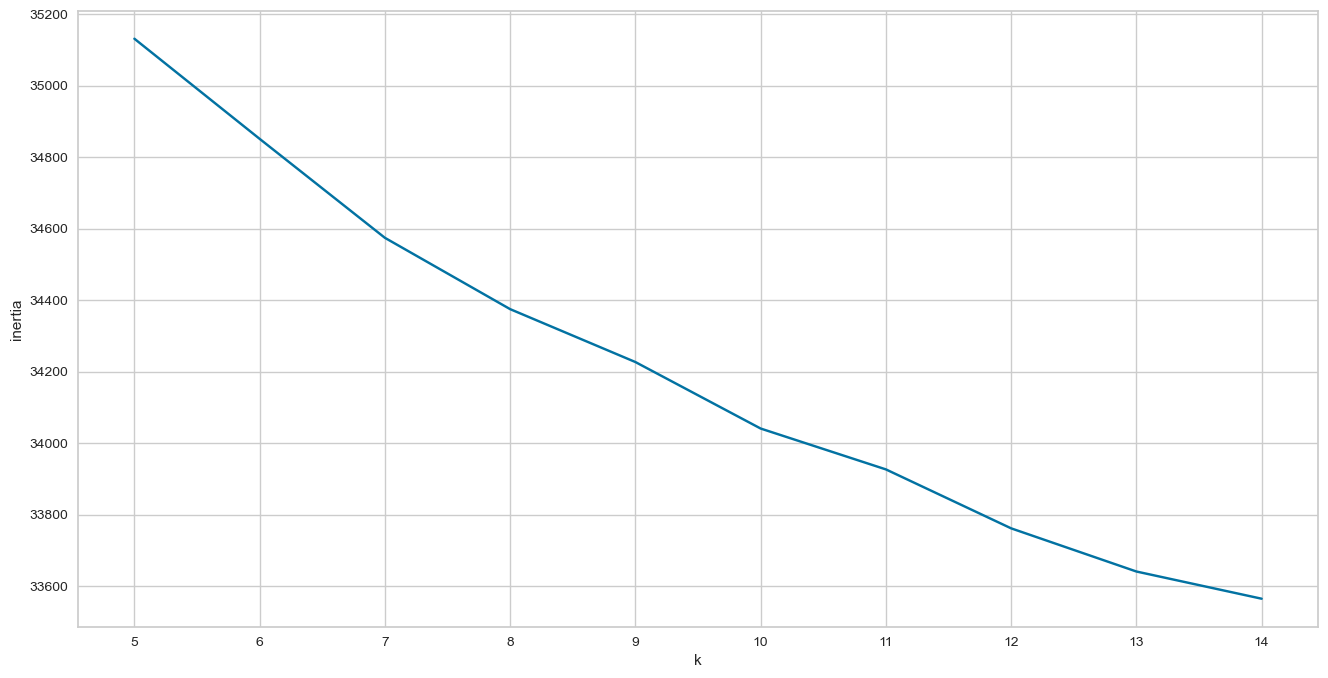

Elbow visualization: Distortion Score (KElbowVisualizer)


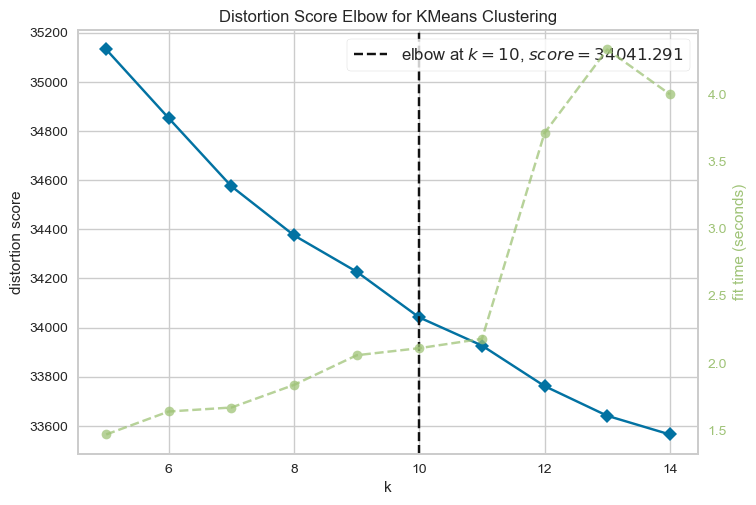

Silhouette score


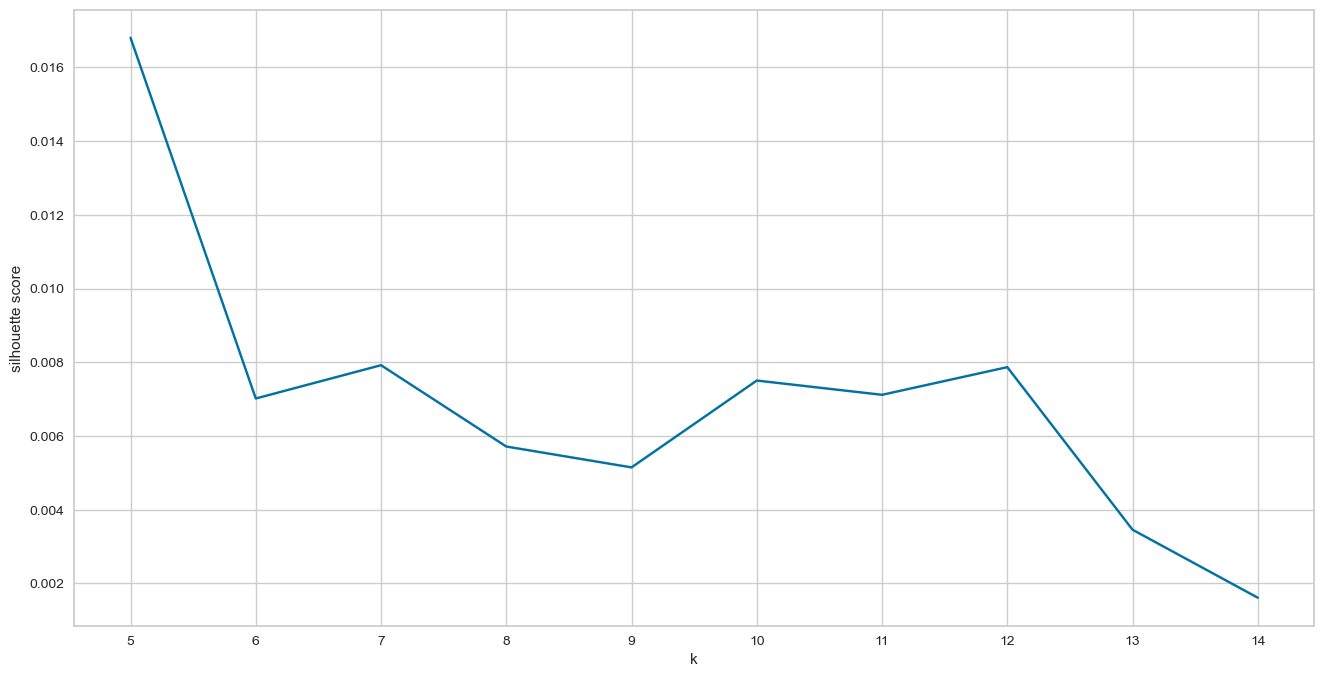

In [30]:
find_k(tasting_encoded, 5, 15)

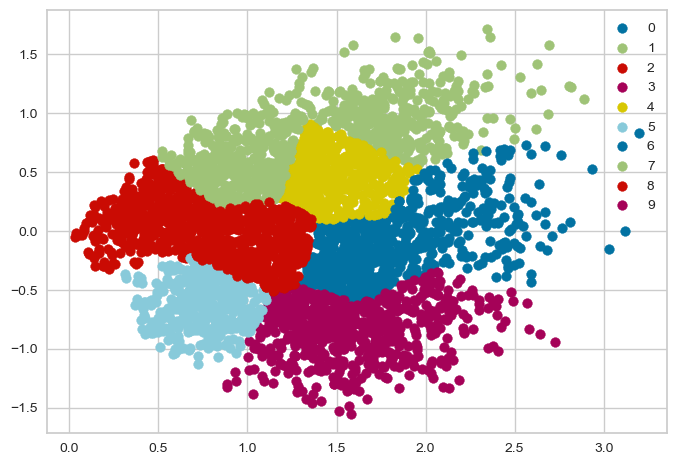

In [31]:
plot_clusters_kmeans(tasting_encoded, 10)

In [32]:
evaluation_results = {}

kmeans = KMeans(n_clusters=9, random_state=42)
kmeans.fit(tasting_encoded)
clusters = kmeans.predict(tasting_encoded)

tasting_encoded_metrics = clustering_metrics(tasting_encoded, clusters)
evaluation_results["Kmeans encoded"] = tasting_encoded_metrics
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527}}

### With TF-IDF vectors

In [33]:
# find_k(wine_features, 5, 15)

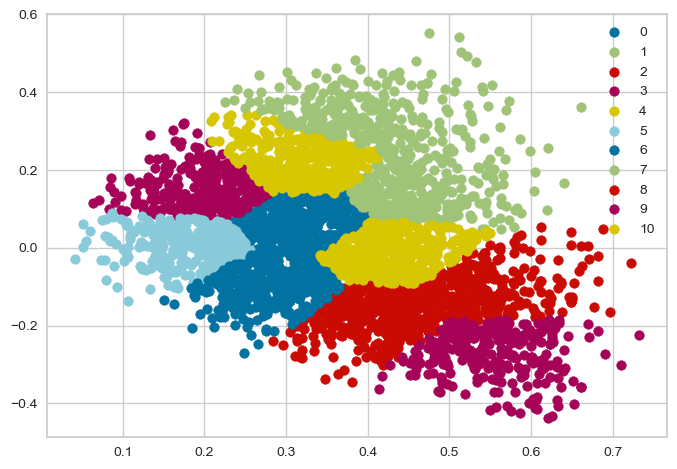

In [34]:
plot_clusters_kmeans(wine_features, 11)

In [35]:
kmeans = KMeans(n_clusters=11, random_state=42)
kmeans.fit(wine_features)
clusters = kmeans.predict(wine_features)

wine_features_metrics = clustering_metrics(tasting_encoded, clusters)
evaluation_results["Kmeans TF-IDF"] = wine_features_metrics
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905}}

# Clustering with DBSCAN

### Encoded data

In [36]:
eps = 0.5  # The maximum distance between two samples to be considered in the same neighborhood
min_samples = 5  # The minimum number of samples in a neighborhood to form a core point
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(tasting_encoded)

In [37]:
# Clusters obtained
np.unique(clusters)

array([-1], dtype=int64)

I am only getting one cluster, labeled as -1. These are noise points (outliers): <br>
In DBSCAN, noise points are data points that do not belong to any cluster. They are often referred to as outliers or noise observations. In the DBSCAN algorithm, noise points are typically assigned a cluster label of -1. <br>
When you observe that all your data points are labeled as -1, it suggests that DBSCAN was unable to identify any dense regions or clusters in the data. This could be due to various factors such as a high eps value that makes the algorithm treat all points as noise, or the data itself may not exhibit clear clustering patterns. (ChatGPT)


In [38]:
eps = 0.3  
min_samples = 2  
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels = dbscan.fit_predict(tasting_encoded)
np.unique(cluster_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int64)

In [39]:
metrics = clustering_metrics(tasting_encoded, cluster_labels)
evaluation_results["DBSCAN encoded"] = metrics
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404}}

### TF-IDF + Phrases

In [40]:
eps = 0.5
min_samples = 2  
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(wine_features)
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64)

In [41]:
metrics = clustering_metrics(wine_features, clusters)
evaluation_results["DBSCAN TF-IDF 0.5 eps 2 min samples"] = metrics
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840499679008}}

In [42]:
eps = 0.3
min_samples = 2  
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(wine_features)
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19], dtype=int64)

In [43]:
metrics = clustering_metrics(wine_features, clusters)
evaluation_results["DBSCAN TF-IDF 0.3 eps 2 min samples"] = metrics
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840499679008},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888211255}}

Clearly the tasting notes need further transformations to be able to use them for clustering. 

## Word embeddings 
The main disadvantadge of TF-IDF is that it does not capture contextual semantics. To solve that, we will create word embeddings using Word2Vec. Word embeddings are vector representations that capture semantic and syntactic relationships between words based on their context. <br>
Resource:
- https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial <br>

The first step would be normalize the text (convert to lower case, remove punctuations...) but this has been done already. Normally the next step would be stemming or lemmatization (merge words that share the same root), preferably lemmatization since the resulting terms maintain a recognizable meaning. However, given the nature of our data where we have very simple words, we will try first without lemmatization.

#### Use Phrases to capture terms that are more than one word
Some of the terms consist of more than one word (ie: "red fruit"). To avoid losing them, we will apply gensim's Phrases.

In [44]:
# Phrases takes a list of lists of words as an input
sent = [row.split() for row in wine_data["tasting_notes"]]

In [45]:
# Apply Phrases
phrases = Phrases(sent, min_count=1, threshold=1)
bigram = Phraser(phrases)
notes = bigram[sent] 

Check the most frequent words (sanity check)

In [46]:
word_freq = defaultdict(int)
for note in notes:
    for i in note:
        word_freq[i] += 1
len(word_freq)

1180

In [47]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['fruit_aromas',
 'fresh',
 'fruit',
 'balanced',
 'elegant',
 'spicy_notes',
 'notes',
 'complex',
 'higly_aromatic',
 'red_fruit']

#### Word2Vec implementation
- Parameters <br>
Here we played with the min_count (Ignores all words with total frequency lower than this) and the sample (The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5)).

In [48]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [49]:
w2v_model = Word2Vec(min_count=70,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

- Vocabulary table

In [50]:
w2v_model.build_vocab(notes, progress_per=10000)

- Train the model

In [51]:
w2v_model.train(notes, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(98373, 1412100)

#### Explore the model
Let's see how the model has capture the similarity between words.

In [52]:
w2v_model.wv.most_similar(positive=["red_fruit"])

[('smooth_tannins', 0.9995671510696411),
 ('black_fruit', 0.9995393753051758),
 ('rounded', 0.9995251893997192),
 ('wellintegrated_wood', 0.9995161890983582),
 ('liquorice', 0.9995120763778687),
 ('tobacco', 0.9994992017745972),
 ('ripe_tannins', 0.9994987845420837),
 ('intense', 0.999494194984436),
 ('velvety', 0.9994920492172241),
 ('plums', 0.9994879961013794)]

In [53]:
w2v_model.wv.most_similar(positive=["white"])

[('white_flowers', 0.9995958209037781),
 ('fennel', 0.9995854496955872),
 ('slightly_bitter', 0.999579668045044),
 ('green_apple', 0.999559760093689),
 ('tropical_fruits', 0.9995427131652832),
 ('peach', 0.999540388584137),
 ('crunchy', 0.9995185136795044),
 ('unctuous', 0.9995080232620239),
 ('tropical_fruit', 0.9995040893554688),
 ('notes', 0.9995030164718628)]

In [54]:
w2v_model.wv.most_similar(positive=["vanilla"])

[('oak_wood', 0.9996460676193237),
 ('persistent', 0.9996452927589417),
 ('jam', 0.999642014503479),
 ('sweet_spices', 0.9996402263641357),
 ('wellintegrated_wood', 0.9996342658996582),
 ('toasty_notes', 0.9996325969696045),
 ('smoky_notes', 0.999622106552124),
 ('roasted_notes', 0.9996213316917419),
 ('ageing_notes', 0.9996122717857361),
 ('wellintegrated_tannins', 0.9996091723442078)]

All these terms look more or less similar so it looks like the model it's not performing badly.

## Create vectors for each tasting note (using the word embeddings)

In [55]:
wine_data["tasting_notes"][0]

'red fruit mineral voluminous mediumbodied raspberry violets'

In [56]:
wine_data["tasting_notes"][91]

'powerful structured ripe tannins with volume balanced acidity pleasant finish tasty persistent varietal notes fruit aromas black fruit mediterranean herbs ageing notes'

In [57]:
# Define a custom tokenizer that preserves hyphenated words (to avoid errors with terms such as medium-bodied)
def custom_tokenizer(text):
    return text.split()

# Compute TF-IDF scores for each word in the tasting notes
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf_matrix = tfidf_vectorizer.fit_transform(wine_data["tasting_notes"])

# Create TF-IDF weighted average vectors for each tasting note
tfidf_embeddings = []

for idx in range(len(wine_data)):
    tasting_note = wine_data["tasting_notes"][idx]
    words = tasting_note.split()
    word_vectors = []
    for word in words:
        if word in w2v_model.wv:
            word_vector = w2v_model.wv[word]
            word_tfidf_score = tfidf_matrix[idx, tfidf_vectorizer.vocabulary_[word]]
            word_vectors.append(word_vector * word_tfidf_score)
    if word_vectors:
        tfidf_avg_vector = np.mean(word_vectors, axis=0)
    else:
        tfidf_avg_vector = np.zeros(word2vec_model.vector_size)  # Handle cases where no valid word vector is found
    tfidf_embeddings.append(tfidf_avg_vector)

In [58]:
wine_data["embeddings"] = tfidf_embeddings
wine_data.head()

wine  price  type_wine type_wine_details  \
0            Ultreia Saint Jacques 2021   16.2        Red               Red   
1                        Blanc Pescador    7.8  Sparkling   Frizzante white   
2  Bach Extrísimo Blanco Semidulce 2021    9.4      White             White   
3            José Pariente Verdejo 2022   16.2      White             White   
4             Coto de Imaz Reserva 2018   13.0        Red               Red   

  type_agriculture         region_gi                                grapes  \
0     Conventional            Bierzo                            ['Mencia']   
1     Conventional  Wines without GI  ['Macabeo', 'Parellada', 'Xarel·lo']   
2     Conventional         Catalunya               ['Xarel·lo', 'Macabeo']   
3     Conventional             Rueda                           ['Verdejo']   
4     Conventional             Rioja                       ['Tempranillo']   

                                    wine_description  \
0  Ultreia Saint Jacques is one of the best wines...   
1  Blanc Pescador and Cresta Rosa have been bench...   
2  The Extrísimo Semidulce from Masia Bach is a h...   
3  The José Pariente Verdejo is one of the great ...   
4  The Coto de Imaz Reserva is an intense and sil...   

                                     tasting_bouquet  \
0                                Raspberry / Violets   
1           Aromatic / Fruit aromas / Higly aromatic   
2  Higly aromatic / Complex / Fruit aromas / Flor...   
3           White fruit / Apricot / Fennel / Aniseed   
4                 Ripe fruit / Spicy notes / Complex   

                                       tasting_mouth  \
0   Red fruit / Mineral / Voluminous / Medium-bodied   
1                       Light / Pleasant / Sparkling   
2  Good entry / Structured / Balanced / Good acid...   
3              Rich / Unctuous / Pleasant bitterness   
4         Fleshy / Powerful / Ripe tannins / Velvety   

             serve_temperature  \
0  Serve between 14ºC and 16ºC   
1                          NaN   
2                          NaN   
3    Serve between 6ºC and 8ºC   
4  Serve between 16ºC and 18ºC   

                                        food_pairing  \
0       Sausages and hamRed meatStews and casseroles   
1  Snacks and appetizersStarters and suppersSalad...   
2  Snacks and appetizersStarters and suppersSeafo...   
3  FishSaladsStarters and suppersVegetablesSoft c...   
4          Sausages and hamRed meatGameCured cheeses   

                                               image  \
0  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
1  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
2  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
3  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
4  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   

                                                 url  \
0  https://www.vinissimus.com/en/wine/ultreia-sai...   
1  https://www.vinissimus.com/en/wine/blanc-pesca...   
2  https://www.vinissimus.com/en/wine/bach-extris...   
3  https://www.vinissimus.com/en/wine/jose-parien...   
4  https://www.vinissimus.com/en/wine/coto-de-ima...   

                                       tasting_notes  \
0  red fruit mineral voluminous mediumbodied rasp...   
1  light pleasant sparkling aromatic fruit aromas...   
2  good entry structured balanced good acidity fl...   
3  rich unctuous pleasant bitterness white fruit ...   
4  fleshy powerful ripe tannins velvety ripe frui...   

                                     tasting_vectors  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.1514694614067394, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                          embeddings  
0  [-0.0059598796, 0.043793015, -0.019101117, 0.0...  
1  [-0.006109946, 0.041905437, -0.018893601, 0.01...  
2  [-0.0029432648, 0.0221

### With embeddings

In [59]:
# Transform the embeddings into a 2D NumPy array to be able to use KElbowVisualizer 
tfidf_embeddings = np.vstack(tfidf_embeddings)

Elbow visualization: Inertia


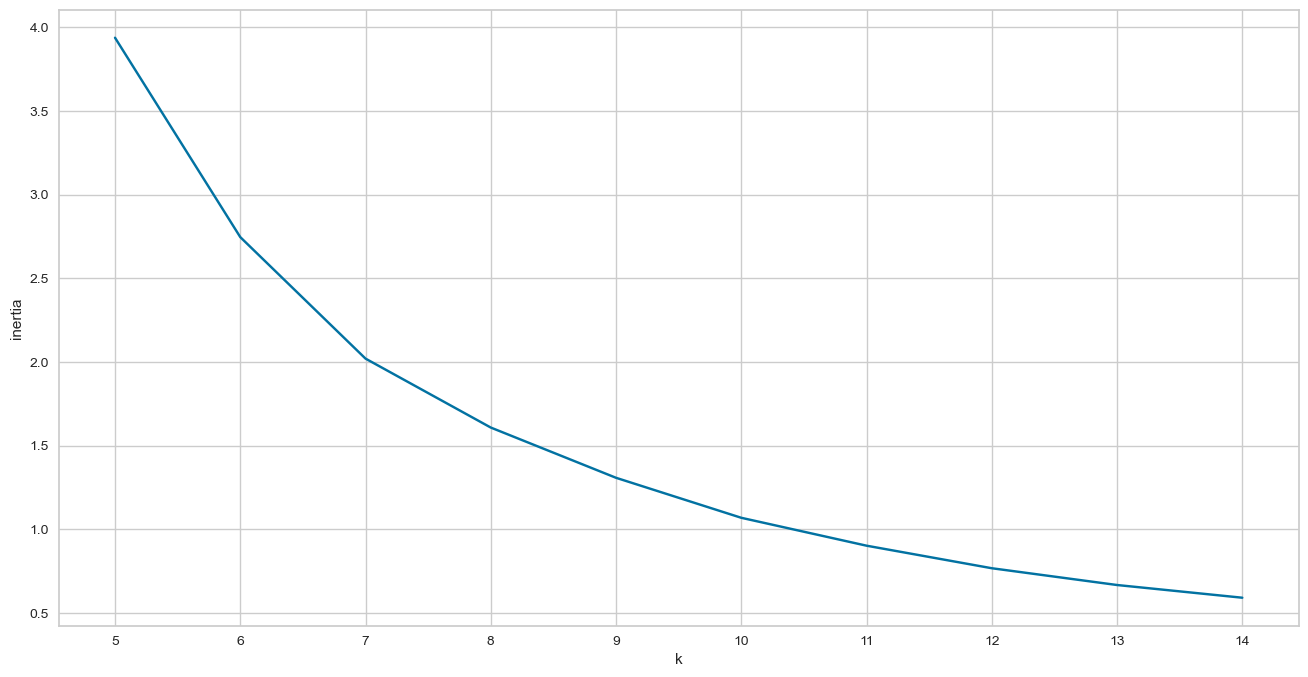

Elbow visualization: Distortion Score (KElbowVisualizer)


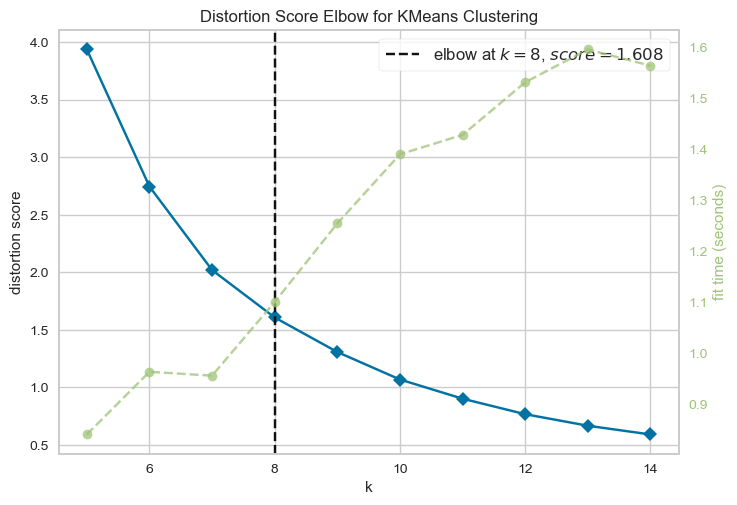

Silhouette score


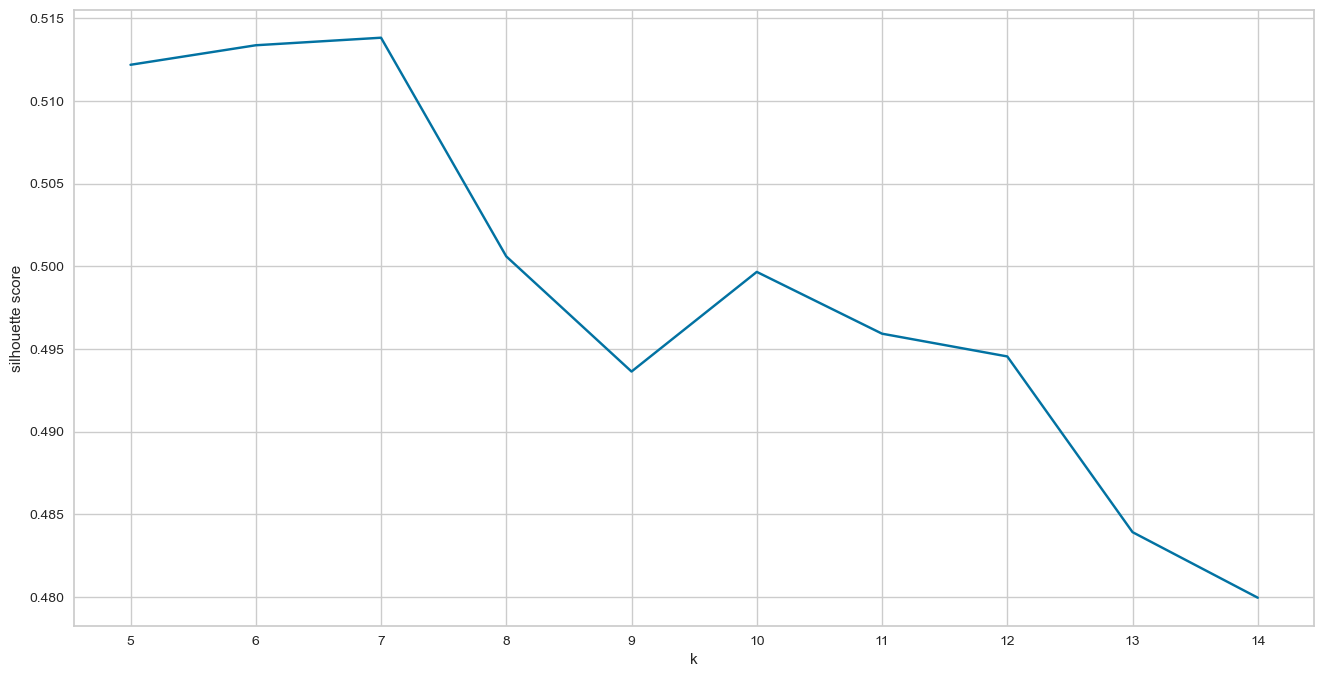

In [60]:
find_k(tfidf_embeddings, 5, 15)

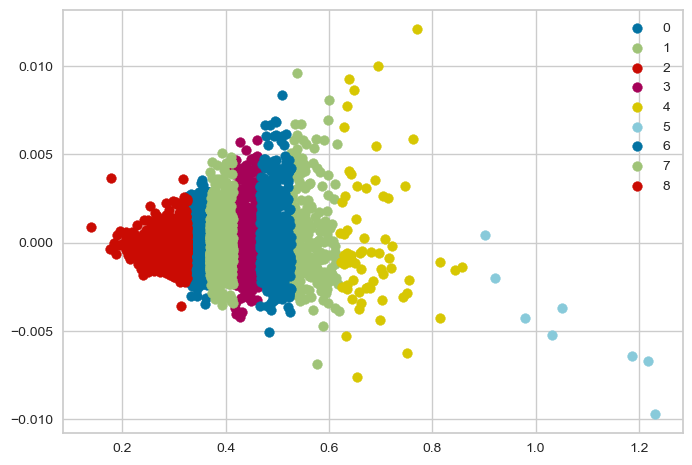

In [61]:
plot_clusters_kmeans(tfidf_embeddings, 9)

In [62]:
kmeans = KMeans(n_clusters=9, random_state=42)
kmeans.fit(tfidf_embeddings)
clusters = kmeans.predict(tfidf_embeddings)

metrics = clustering_metrics(tfidf_embeddings, clusters)
evaluation_results["Kmeans Embeddings"] = metrics
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840499679008},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888211255},
 'Kmeans Embeddings': {'Silhouette': 0.4936323}}

### Explore the clusters

In [63]:
wine_data["cluster"] = clusters
wine_data.head()

wine  price  type_wine type_wine_details  \
0            Ultreia Saint Jacques 2021   16.2        Red               Red   
1                        Blanc Pescador    7.8  Sparkling   Frizzante white   
2  Bach Extrísimo Blanco Semidulce 2021    9.4      White             White   
3            José Pariente Verdejo 2022   16.2      White             White   
4             Coto de Imaz Reserva 2018   13.0        Red               Red   

  type_agriculture         region_gi                                grapes  \
0     Conventional            Bierzo                            ['Mencia']   
1     Conventional  Wines without GI  ['Macabeo', 'Parellada', 'Xarel·lo']   
2     Conventional         Catalunya               ['Xarel·lo', 'Macabeo']   
3     Conventional             Rueda                           ['Verdejo']   
4     Conventional             Rioja                       ['Tempranillo']   

                                    wine_description  \
0  Ultreia Saint Jacques is one of the best wines...   
1  Blanc Pescador and Cresta Rosa have been bench...   
2  The Extrísimo Semidulce from Masia Bach is a h...   
3  The José Pariente Verdejo is one of the great ...   
4  The Coto de Imaz Reserva is an intense and sil...   

                                     tasting_bouquet  \
0                                Raspberry / Violets   
1           Aromatic / Fruit aromas / Higly aromatic   
2  Higly aromatic / Complex / Fruit aromas / Flor...   
3           White fruit / Apricot / Fennel / Aniseed   
4                 Ripe fruit / Spicy notes / Complex   

                                       tasting_mouth  \
0   Red fruit / Mineral / Voluminous / Medium-bodied   
1                       Light / Pleasant / Sparkling   
2  Good entry / Structured / Balanced / Good acid...   
3              Rich / Unctuous / Pleasant bitterness   
4         Fleshy / Powerful / Ripe tannins / Velvety   

             serve_temperature  \
0  Serve between 14ºC and 16ºC   
1                          NaN   
2                          NaN   
3    Serve between 6ºC and 8ºC   
4  Serve between 16ºC and 18ºC   

                                        food_pairing  \
0       Sausages and hamRed meatStews and casseroles   
1  Snacks and appetizersStarters and suppersSalad...   
2  Snacks and appetizersStarters and suppersSeafo...   
3  FishSaladsStarters and suppersVegetablesSoft c...   
4          Sausages and hamRed meatGameCured cheeses   

                                               image  \
0  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
1  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
2  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
3  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
4  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   

                                                 url  \
0  https://www.vinissimus.com/en/wine/ultreia-sai...   
1  https://www.vinissimus.com/en/wine/blanc-pesca...   
2  https://www.vinissimus.com/en/wine/bach-extris...   
3  https://www.vinissimus.com/en/wine/jose-parien...   
4  https://www.vinissimus.com/en/wine/coto-de-ima...   

                                       tasting_notes  \
0  red fruit mineral voluminous mediumbodied rasp...   
1  light pleasant sparkling aromatic fruit aromas...   
2  good entry structured balanced good acidity fl...   
3  rich unctuous pleasant bitterness white fruit ...   
4  fleshy powerful ripe tannins velvety ripe frui...   

                                     tasting_vectors  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.1514694614067394, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                          embeddings  cluster  
0  [-0.0059598796, 0.043793015, -0.019101117, 0.0...        7  
1  [-0.006109946, 0.041905437, -0.018893601, 0.01...        7 

In [115]:
wine_data["cluster"].value_counts()

1    760
5    756
0    663
8    622
2    447
6    248
7    245
3     67
4      8
Name: cluster, dtype: int64

In [122]:
def explore_clusters(df, notes_column, cluster_column, cluster):
    cluster_df = df[df[cluster_column]==cluster]

    print(f"CLUSTER {cluster}")
    print(f"The size of this cluster is {len(cluster_df)} wines")
    
    # Type of wine
    ax = sns.countplot(y=cluster_df["type_wine"], order=cluster_df["type_wine"].value_counts().index)
    ax.bar_label(ax.containers[0])
    plt.xlabel("Count")
    plt.ylabel("Type of wine")
    plt.show()
    
    # Region (Geographical Indication)
    plt.figure(figsize=(15,12))
    ax = sns.countplot(y=cluster_df["region_gi"], order=cluster_df["region_gi"].value_counts().index)
    ax.bar_label(ax.containers[0])
    plt.xlabel("Count")
    plt.ylabel("Geographical Indication")
    plt.show()
        
    # Tasting notes
    cluster_df["tasting_notes_lists"] = cluster_df[notes_column].str.split()
    cluster_df = cluster_df.reset_index(drop=True)
    
    corpus = []
    for i in range(cluster_df.shape[0]): 
        corpus += cluster_df["tasting_notes_lists"][i] 
        
    mostCommon = Counter(corpus).most_common(10)
    
    words = []
    freq = []
    for word, count in mostCommon:
        words.append(word)
        freq.append(count)

    ax = sns.barplot(x=freq, y=words)
    ax.bar_label(ax.containers[0])
    plt.title(f"Top 10 Most Frequently Occuring Words (Cluster {cluster})")
    plt.show()

CLUSTER 0
The size of this cluster is 663 wines


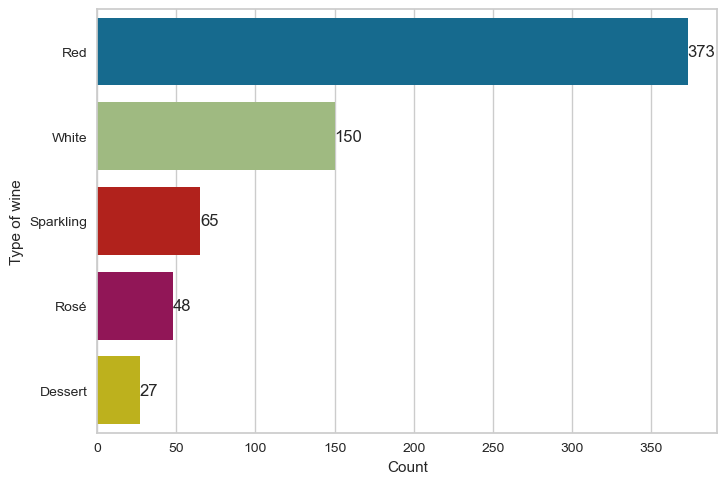

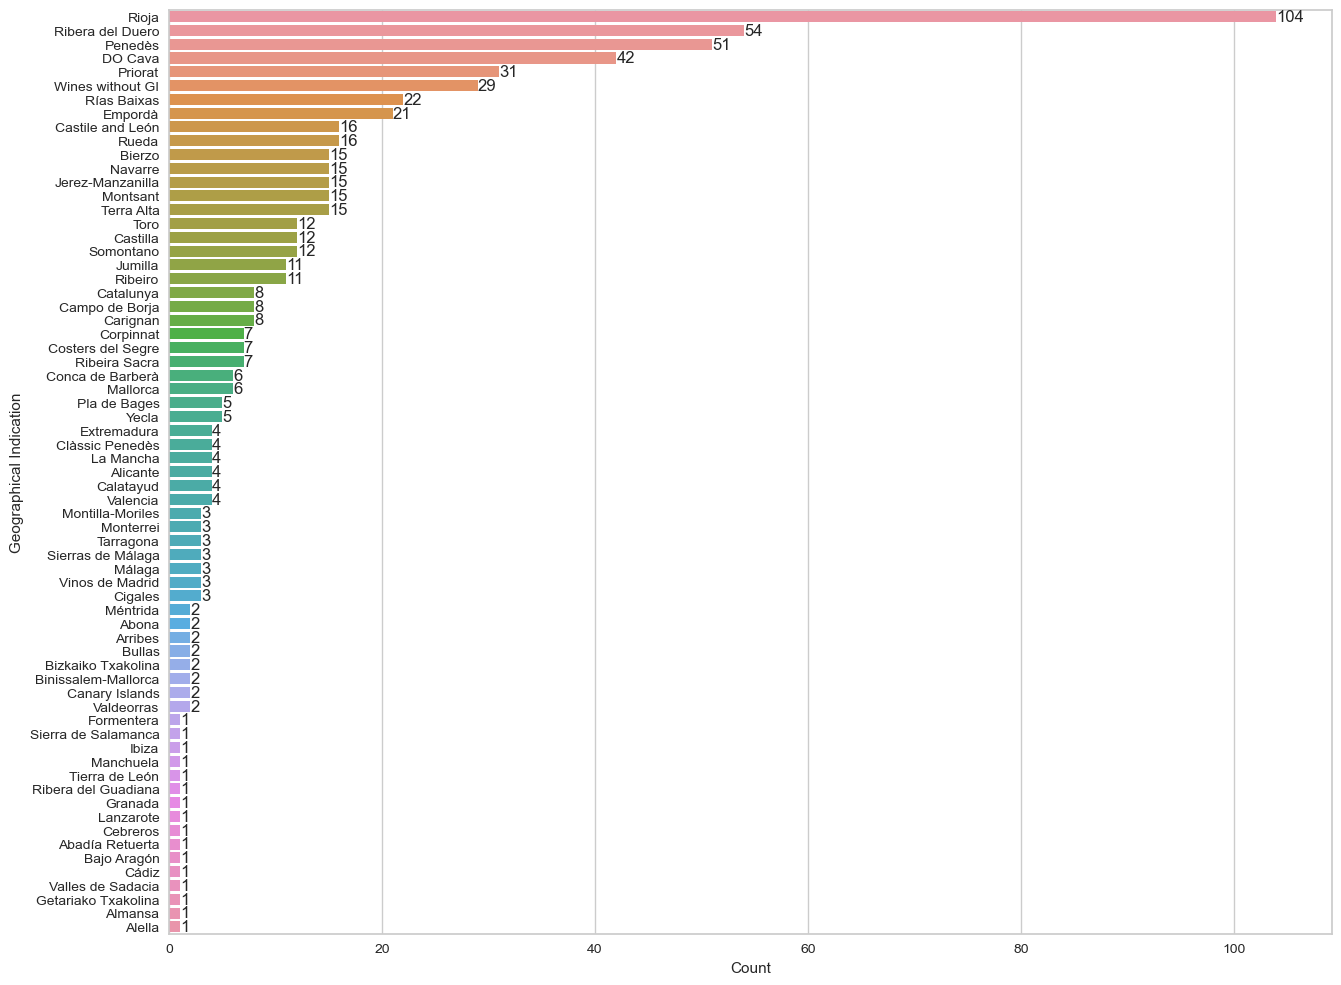

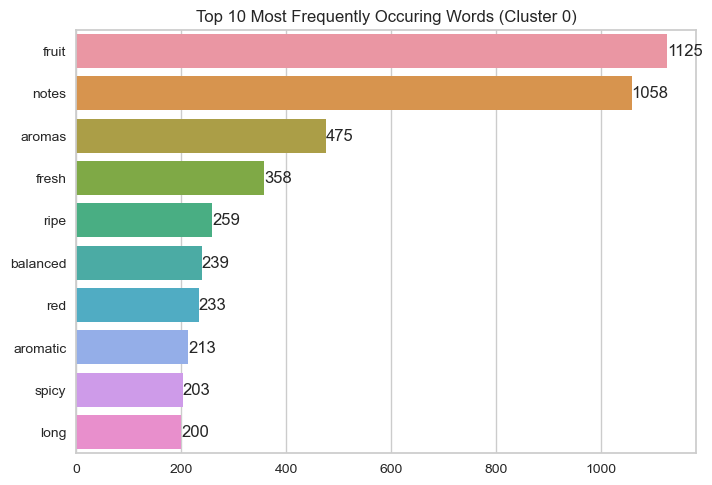

CLUSTER 1
The size of this cluster is 760 wines


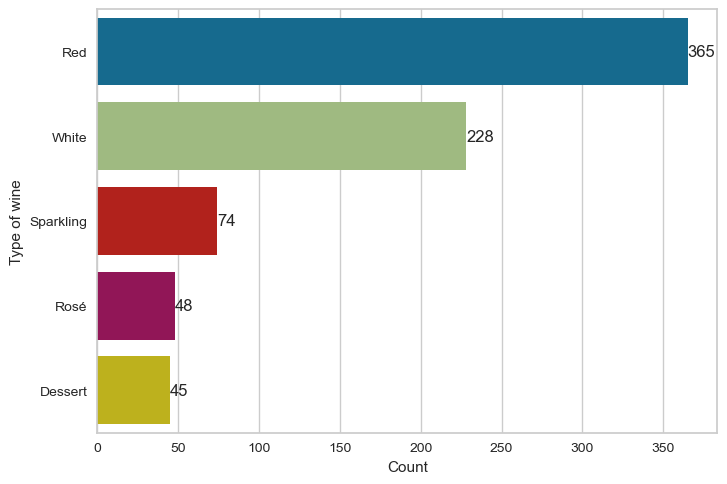

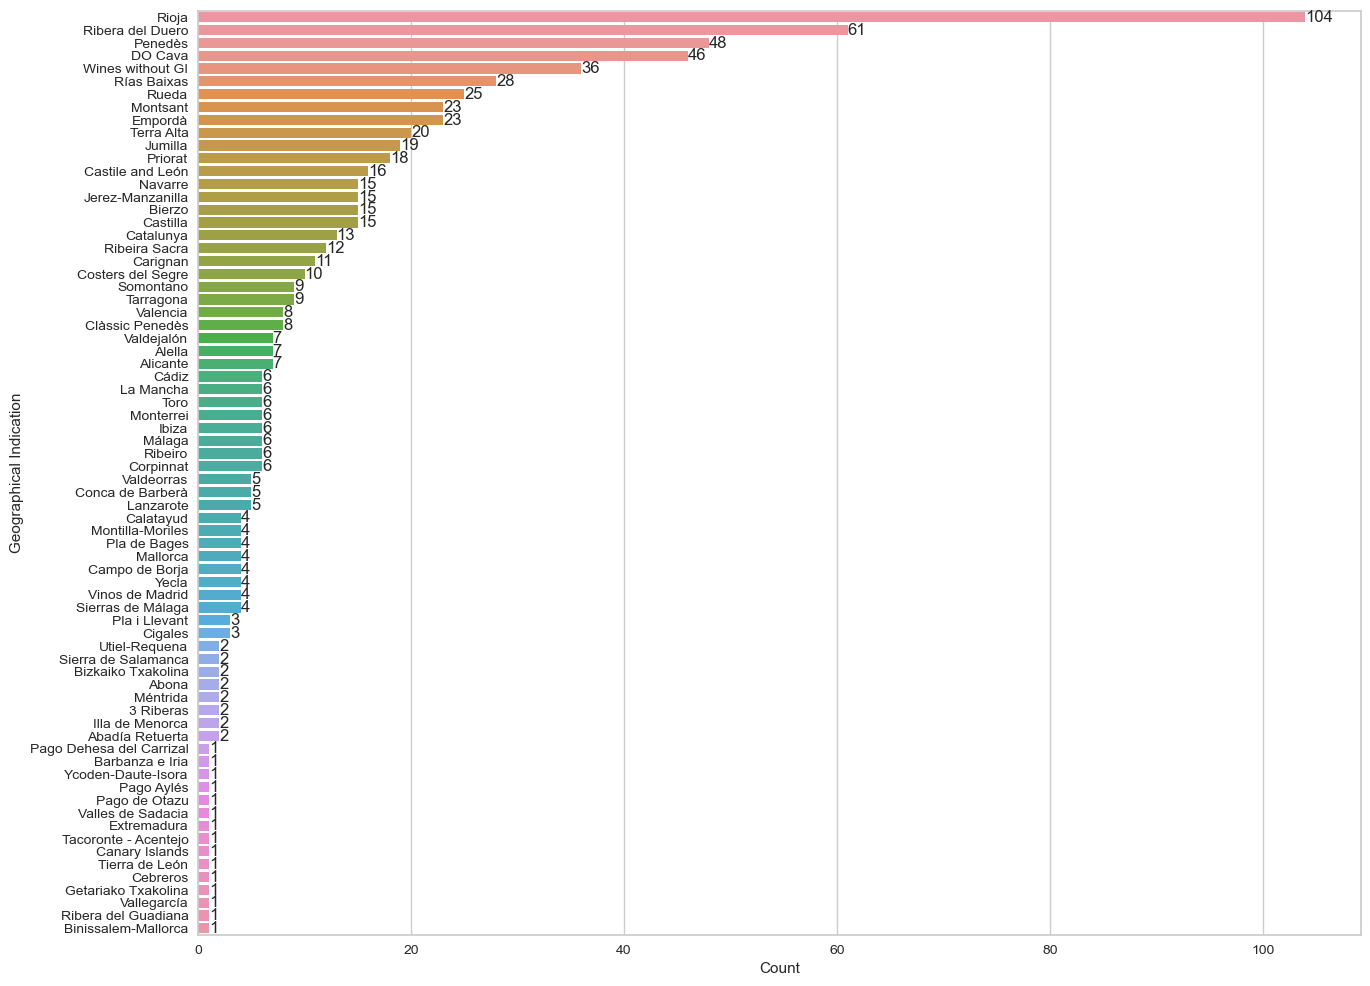

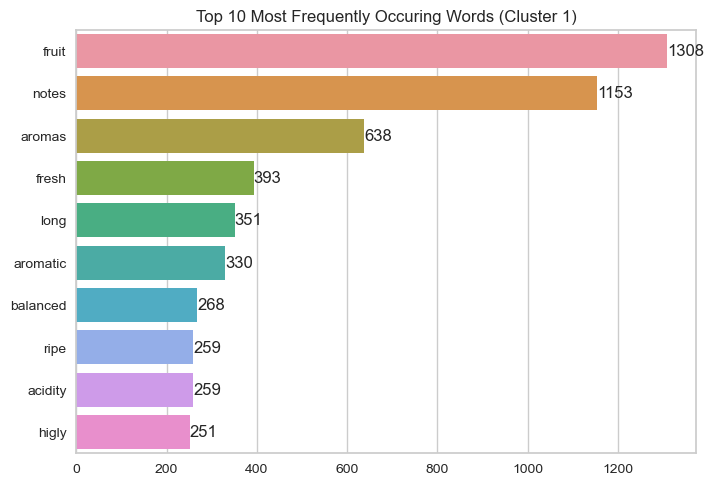

CLUSTER 2
The size of this cluster is 447 wines


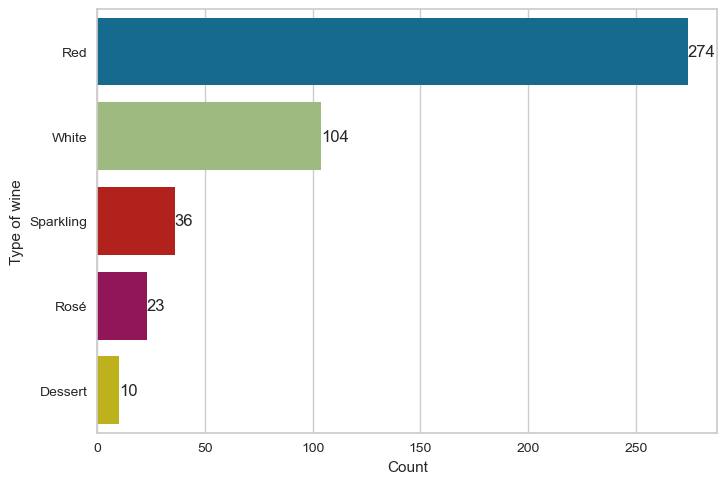

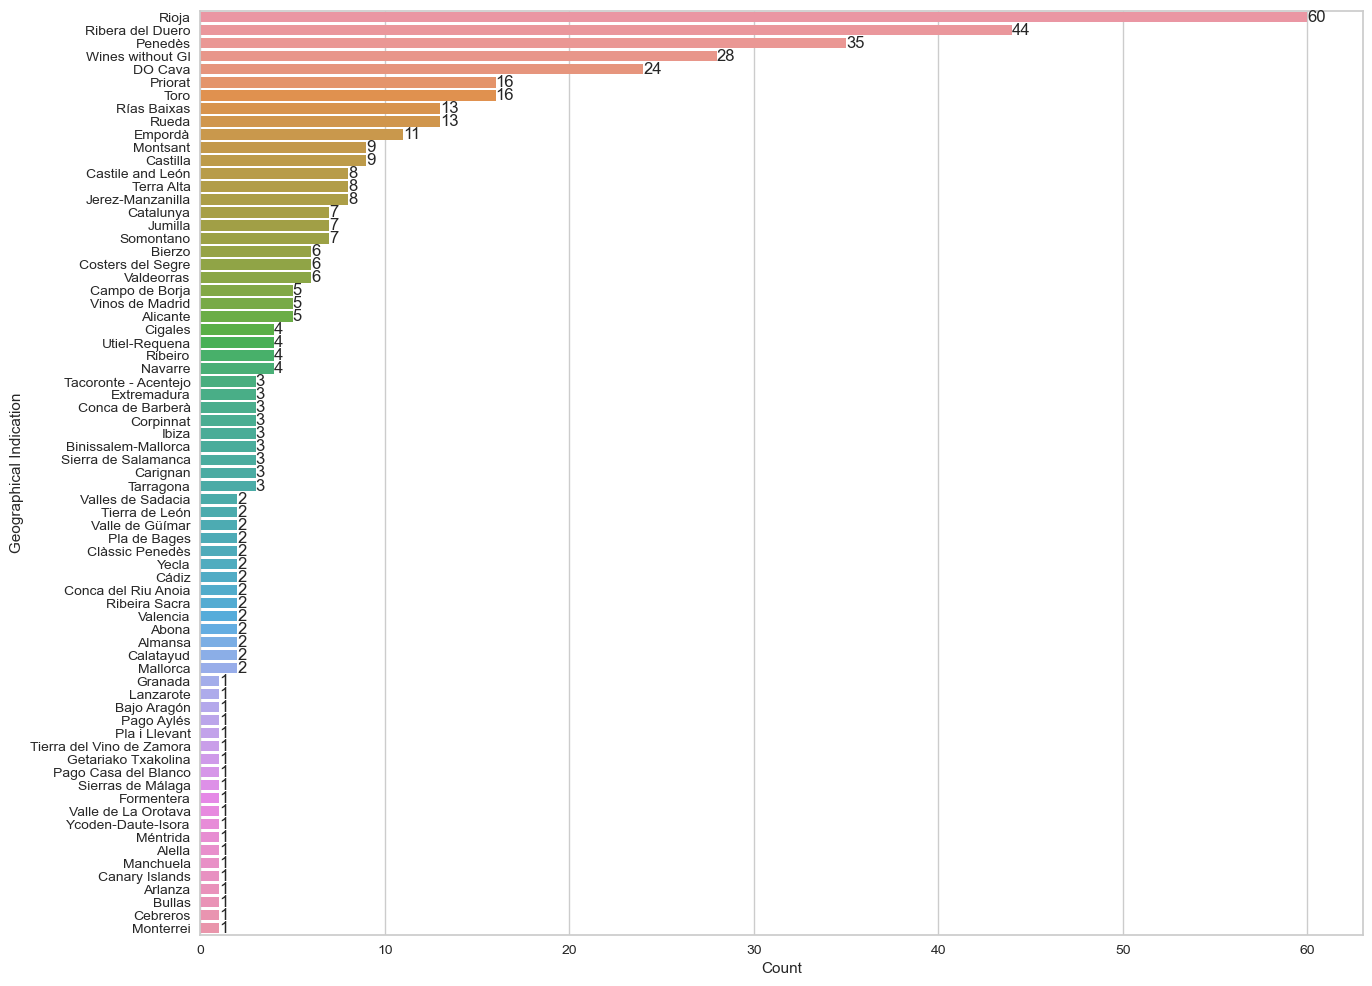

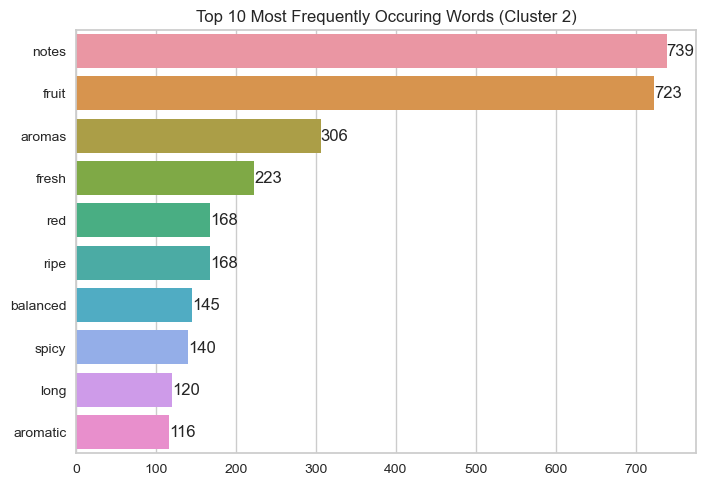

CLUSTER 3
The size of this cluster is 67 wines


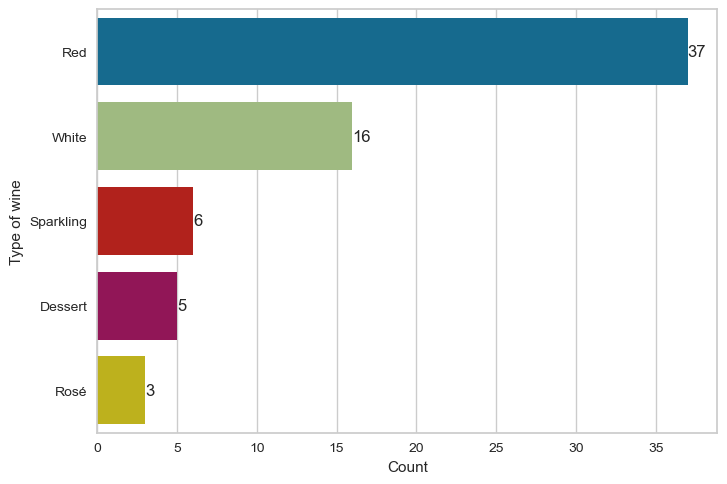

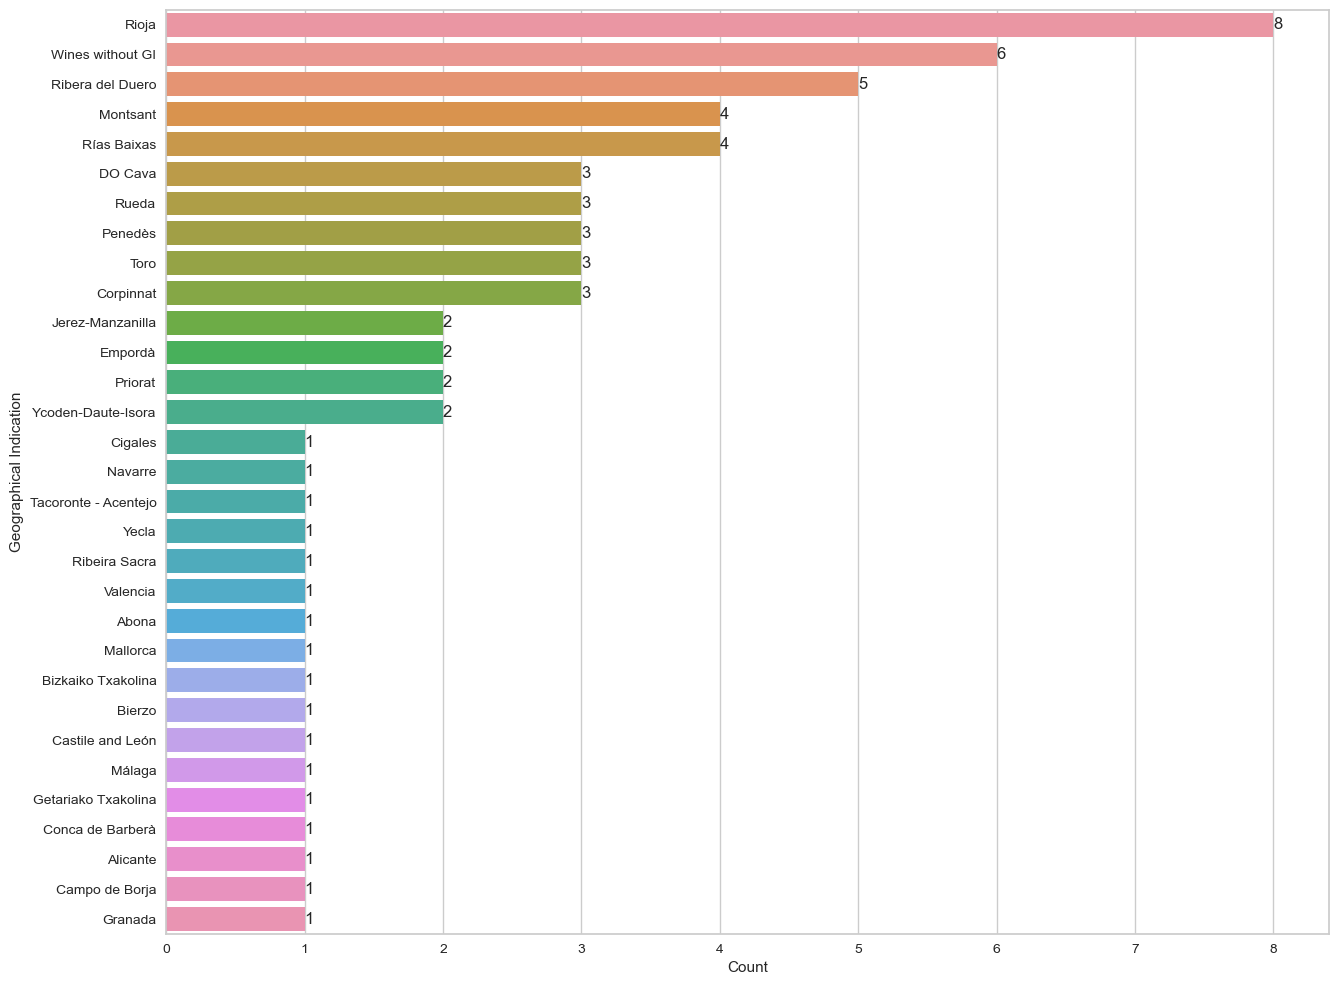

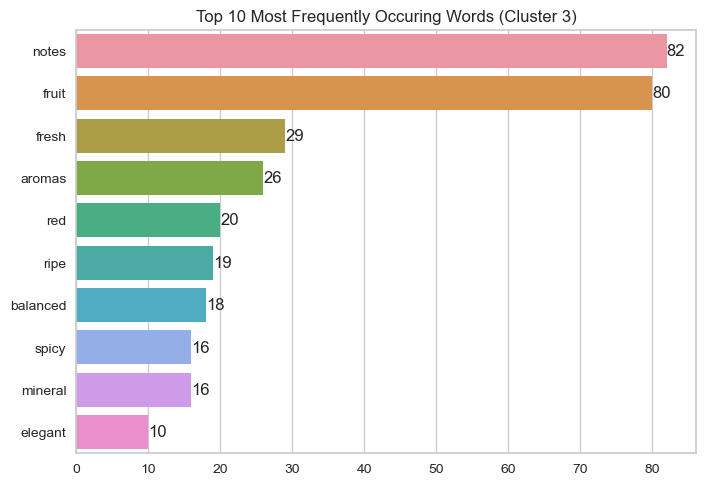

CLUSTER 4
The size of this cluster is 8 wines


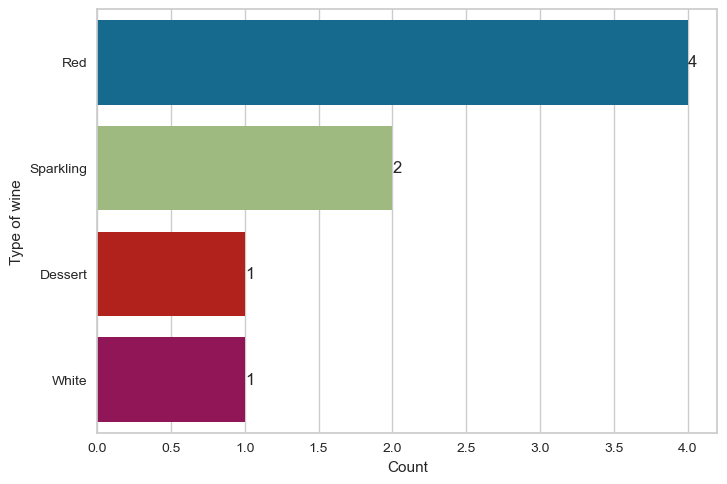

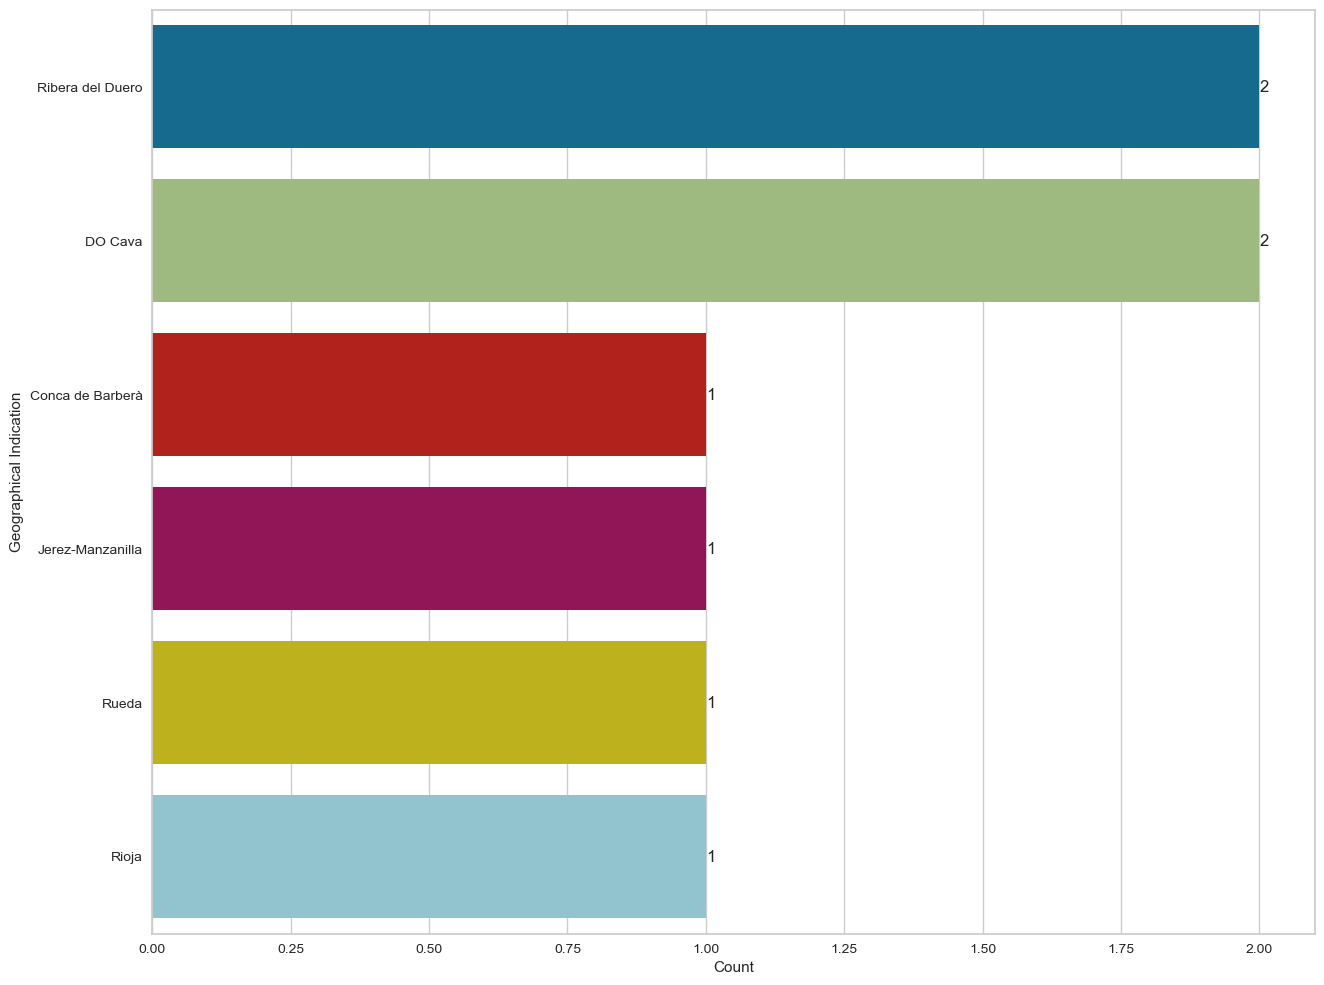

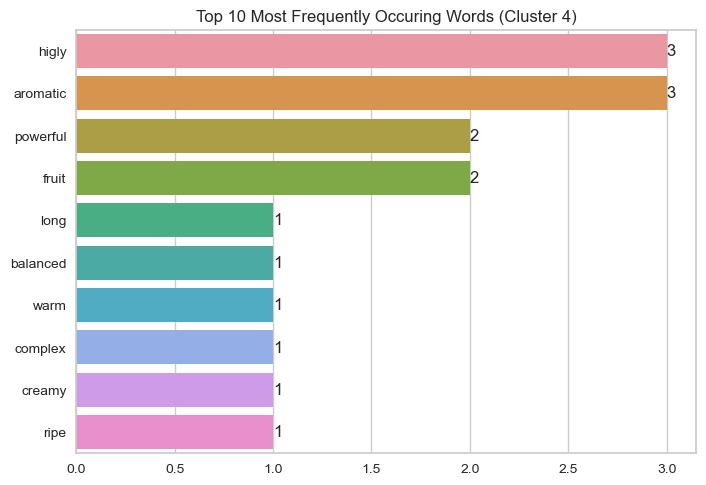

CLUSTER 5
The size of this cluster is 756 wines


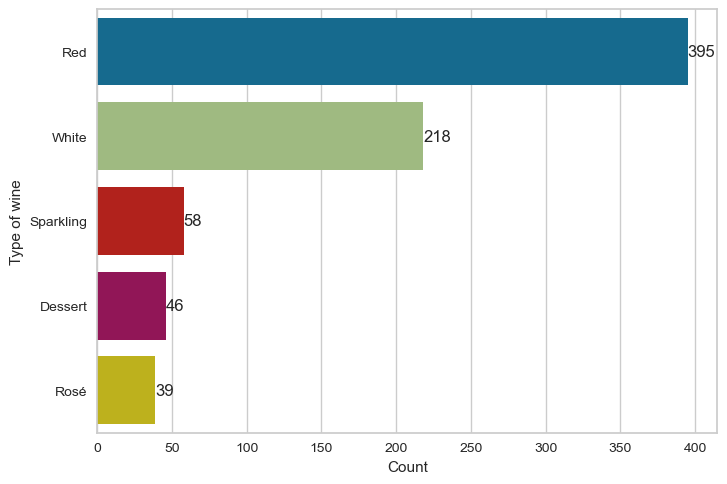

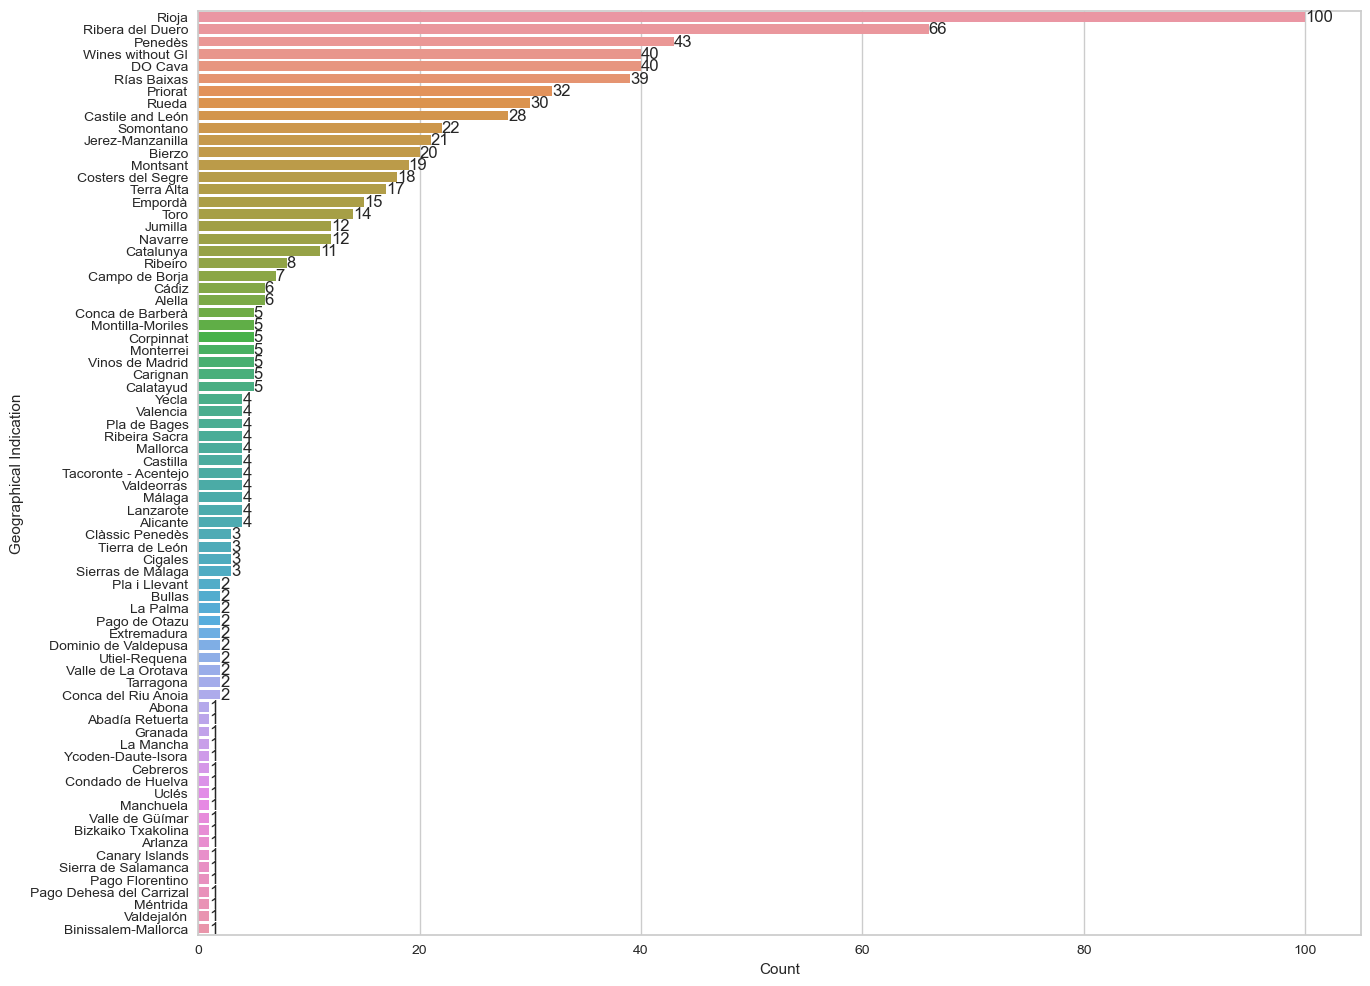

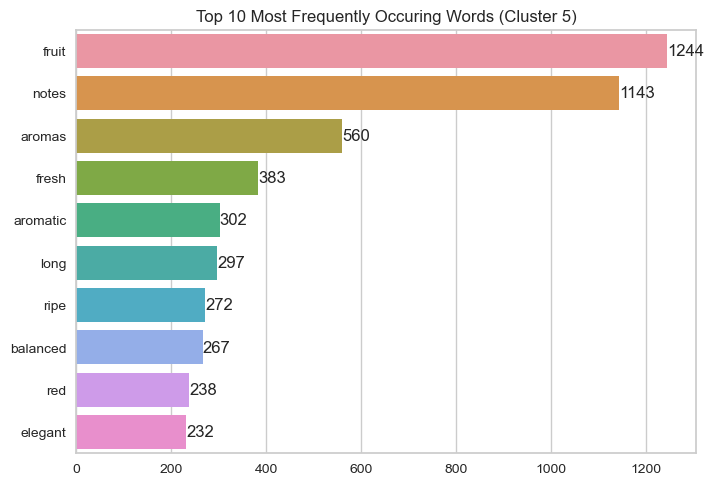

CLUSTER 6
The size of this cluster is 248 wines


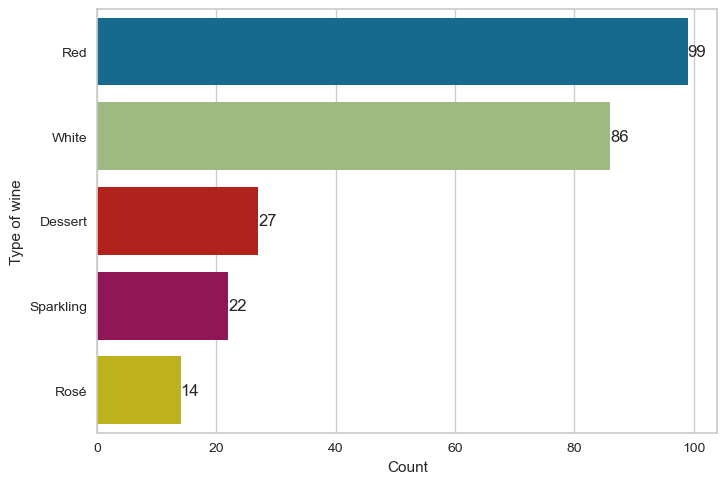

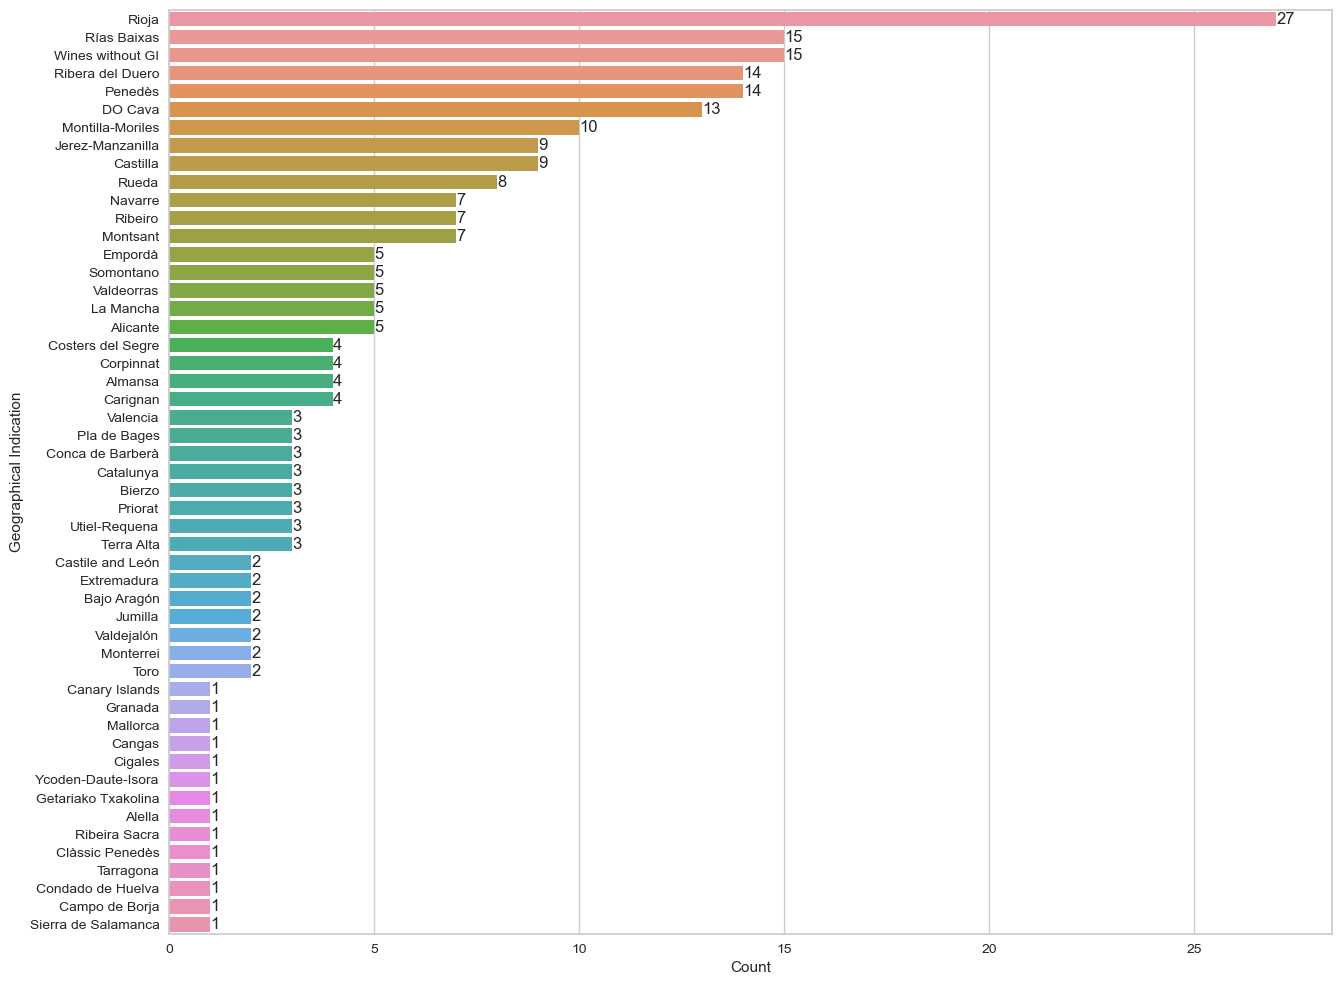

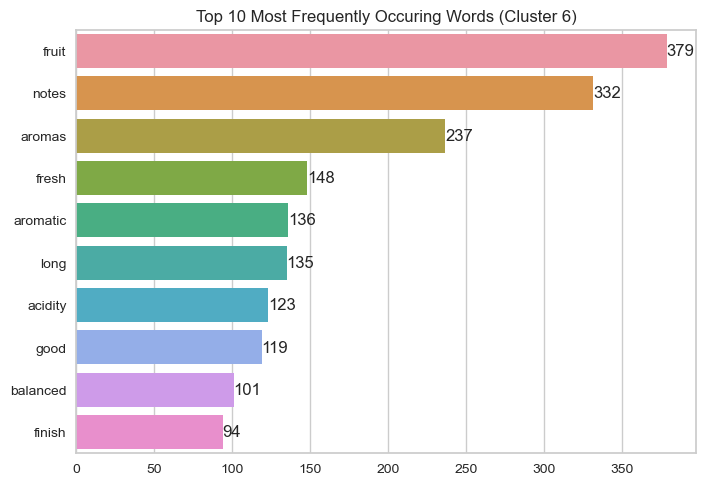

CLUSTER 7
The size of this cluster is 245 wines


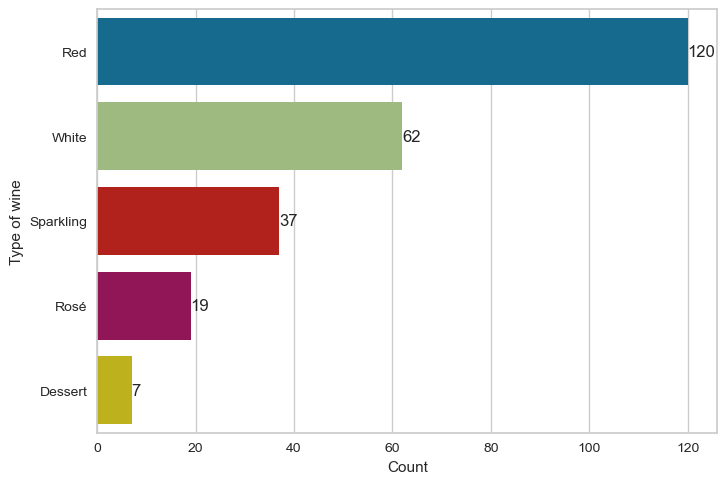

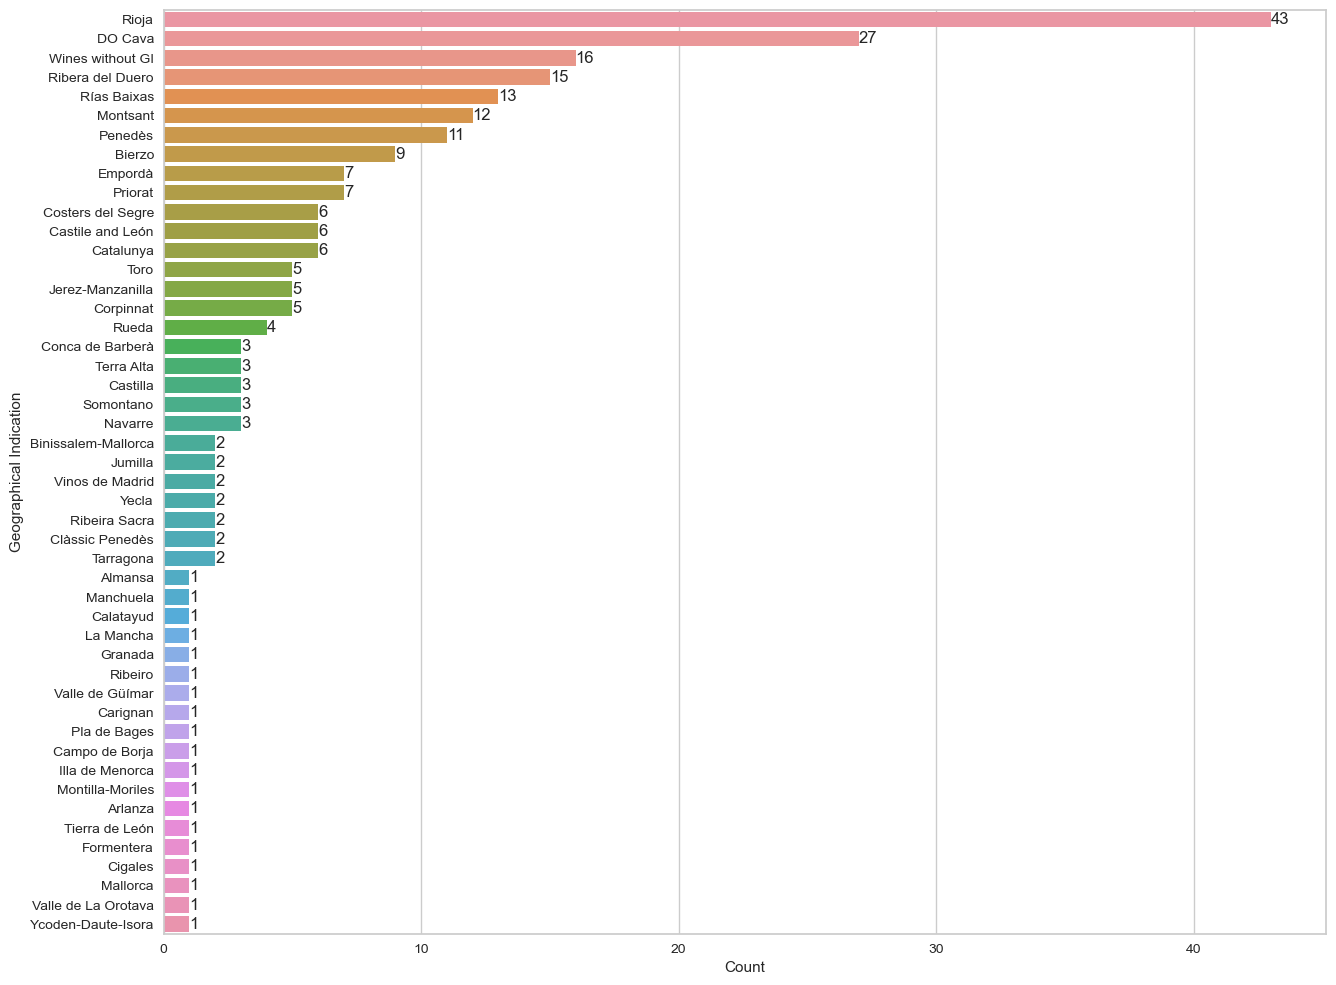

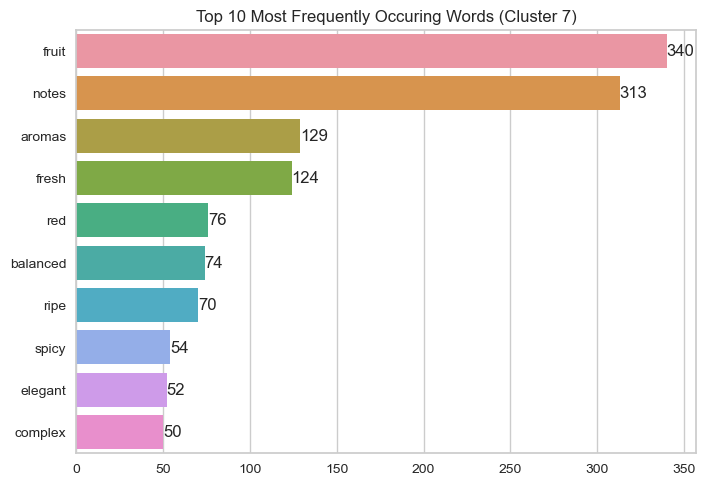

CLUSTER 8
The size of this cluster is 622 wines


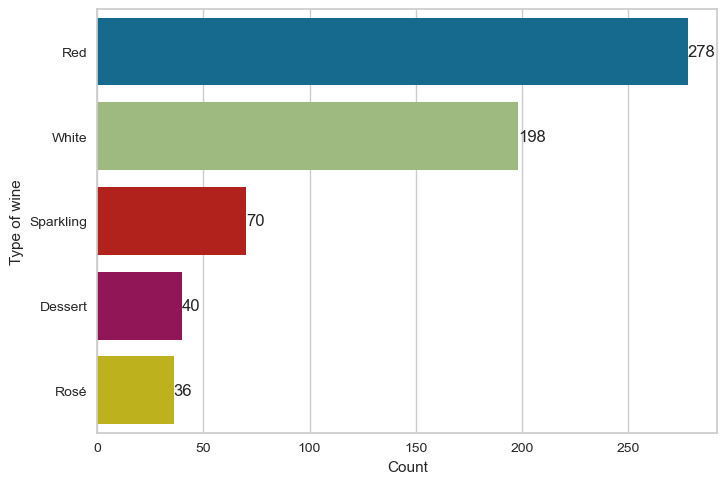

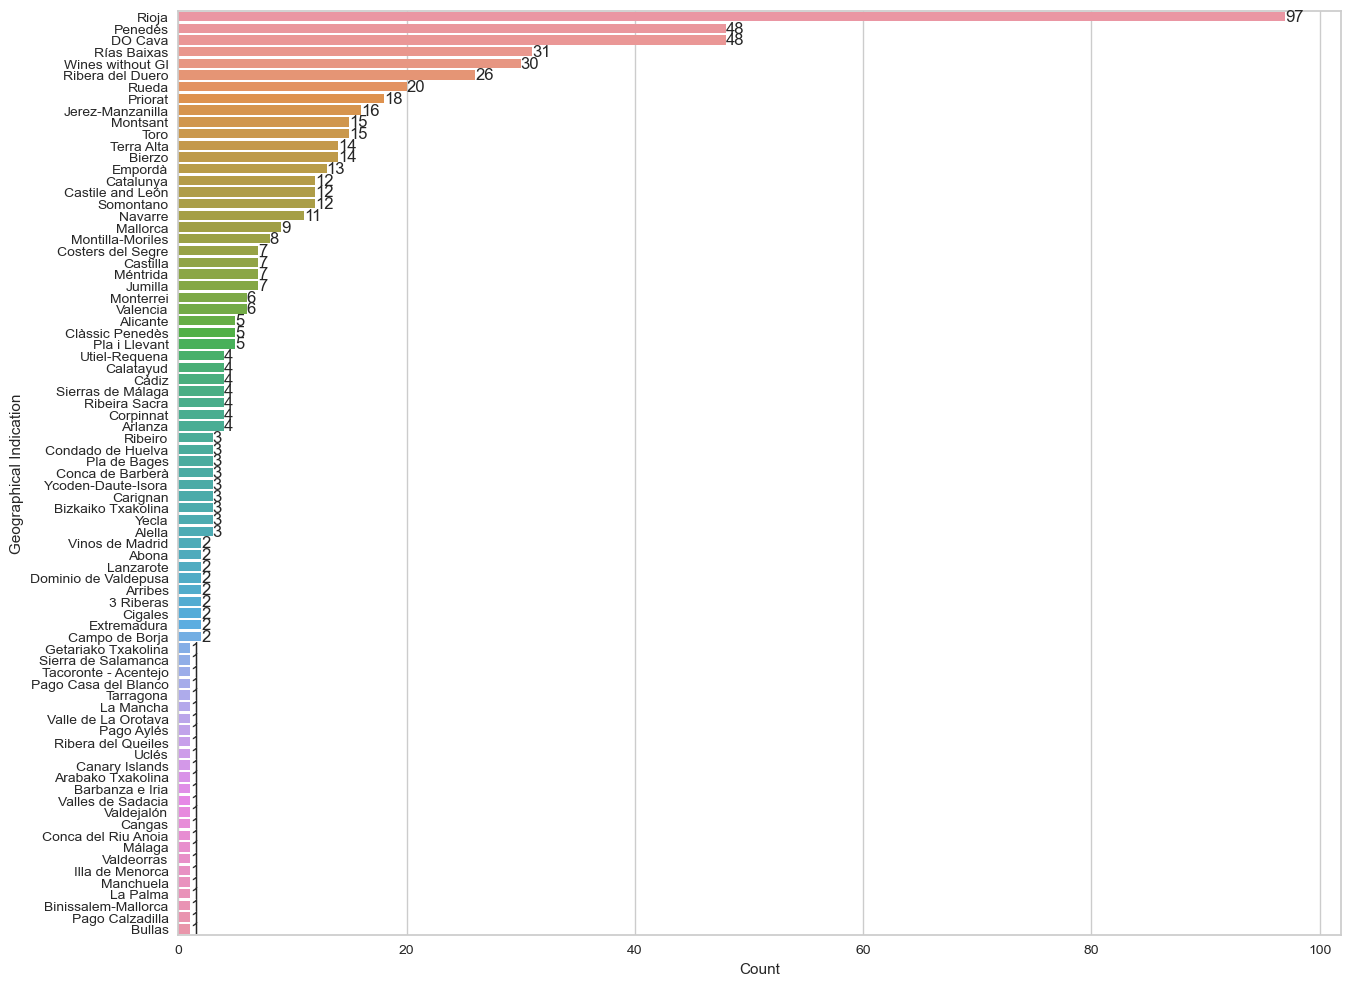

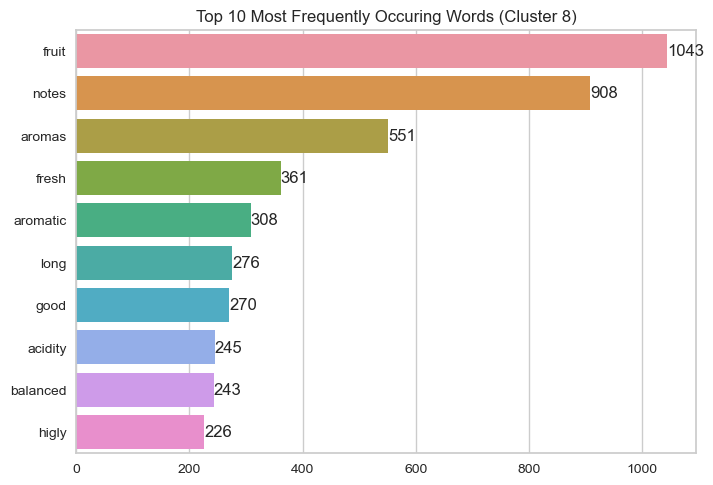

In [123]:
for cluster in range(0,9):
    explore_clusters(wine_data, "tasting_notes", "cluster", cluster)

In [67]:
cluster5 = wine_data[wine_data["cluster"]==5]
cluster5.head()

wine  price type_wine type_wine_details  \
3       José Pariente Verdejo 2022   16.2     White             White   
5     René Barbier Semi Dulce 2021    8.8     White             White   
14    Domaines Lupier La Dama 2018   40.6       Red               Red   
20               Cune Verdejo 2021   10.2     White             White   
25  Marqués de Cáceres Blanco 2021    9.2     White             White   

   type_agriculture  region_gi  \
3      Conventional      Rueda   
5      Conventional  Catalunya   
14     Conventional    Navarre   
20     Conventional      Rueda   
25     Conventional      Rioja   

                                               grapes  \
3                                         ['Verdejo']   
5   ['Macabeo', 'Parellada', 'Xarel·lo', 'Muscat o...   
14                                       ['Garnacha']   
20                                        ['Verdejo']   
25                                          ['Viura']   

                                     wine_description  \
3   The José Pariente Verdejo is one of the great ...   
5                                                 NaN   
14                                                NaN   
20  The Cune Verdejo is a young white wine obtaine...   
25  Viura is the indigenous grape used here and th...   

                                      tasting_bouquet  \
3            White fruit / Apricot / Fennel / Aniseed   
5   Fruit aromas / White fruit / Apple / Pear / Ba...   
14  Expressive / Higly aromatic / Fruit aromas / R...   
20  Fruit aromas / Tropical fruits / Herbaceous no...   
25                       Fresh / Mineral notes / Pear   

                                        tasting_mouth  \
3               Rich / Unctuous / Pleasant bitterness   
5   Smooth / Fresh / Light / Floral notes / Variet...   
14  Balanced / Powerful / Fresh / Fruit-forward / ...   
20  Fresh / Lovely / Fruit-forward / Crunchy / Eas...   
25  Straightforward / Good acidity / Crunchy / Fla...   

              serve_temperature  \
3     Serve between 6ºC and 8ºC   
5     Serve between 7ºC and 9ºC   
14  Serve between 16ºC and 18ºC   
20                          5ºC   
25   Serve between 8ºC and 10ºC   

                                         food_pairing  \
3   FishSaladsStarters and suppersVegetablesSoft c...   
5                                                 NaN   
14                                                NaN   
20                                                NaN   
25                                                NaN   

                                                image  \
3   https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
5   https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
14  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
20  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
25  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   

                                                  url  \
3   https://www.vinissimus.com/en/wine/jose-parien...   
5   https://www.vinissimus.com/en/wine/rene-barbie...   
14  https://www.vinissimus.com/en/wine/domaines-lu...   
20   https://www.vinissimus.com/en/wine/cune-verdejo/   
25  https://www.vinissimus.com/en/wine/marques-de-...   

                                        tasting_notes  \
3   rich unctuous pleasant bitterness white fruit ...   
5   smooth fresh light floral notes varietal notes...   
14  balanced powerful fresh fruitforward ripe tann...   
20  fresh lovely fruitforward crunchy easy to drin...   
25  straightforward good acidity crunchy flavourso...   

                                      tasting_vectors  \
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
5   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
14  [0.0, 0.0, 0.0, 0.0, 0.0, 0.17600143179113165,...   
20  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
25  [0.0, 0.0, 0.0, 0.0, 0.0, 0.2073282047605846, ...   

                                           embeddings  cluster  
3   [-0.004038097, 0.03

There is a significant improvement thanks to the use of word embeddings. Now we will try to see if we can improve our results by doing some feature engineering in the tasting notes.

# Reduced tasting notes
After doing some EDA, we have significantly reduced the terms in the tasting notes. We will now perform the same transformations (encoding, TF-IDF, Word2Vec) and run a quick KMeans to see how they perform.

In [148]:
text_data = pd.read_csv("C:/Users/mboll/OneDrive/Documentos/DATA/Ironhack/Final_project/03-eda/text_data_new_clean.csv")
text_data.head()

wine    year                  winery  \
0            Ultreia Saint Jacques 2021  2021.0   Raúl Pérez Viticultor   
1                        Blanc Pescador     NaN                Perelada   
2  Bach Extrísimo Blanco Semidulce 2021  2021.0              Masia Bach   
3            José Pariente Verdejo 2022  2022.0  Bodegas José Pariente    
4             Coto de Imaz Reserva 2018  2018.0        El Coto de Rioja   

             winery_norm  price  bottle  type_wine type_wine_details  \
0  raul perez viticultor   16.2    0.75        Red               Red   
1               perelada    7.8    0.75  Sparkling   Frizzante white   
2             masia bach    9.4    0.75      White             White   
3         jose pariente    16.2    0.75      White             White   
4       el coto de rioja   13.0    0.75        Red               Red   

  type_agriculture            region  ...  \
0     Conventional   Castilla y León  ...   
1     Conventional  Wines without GI  ...   
2     Conventional          Cataluña  ...   
3     Conventional   Castilla y León  ...   
4     Conventional          La Rioja  ...   

                           notes_norm_removed_joined  \
0  red_fruit mineral voluminous medium-bodied bla...   
1  light pleasant sparkling aromatic fruit highly...   
2  good_entry structured balanced good_acidity fl...   
3  rich unctuous pleasant_bitterness white_fruit ...   
4  fleshy powerful ripe_tannins velvety ripe_frui...   

                          notes_norm_removed_reduced  \
0  red_fruit mineral voluminous medium-bodied bla...   
1  light pleasant sparkling aromatic highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3  rich unctuous pleasant_bitterness white_fruit ...   
4  fleshy powerful ripe_tannins velvety ripe_frui...   

                        notes_norm_removed_reduced50  \
0  red_fruit mineral voluminous medium-bodied bla...   
1            light pleasant aromatic highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3      rich unctuous white_fruit other_herbs aniseed   
4  fleshy powerful ripe_tannins velvety ripe_frui...   

                       notes_norm_removed_reduced100  \
0  red_fruit mineral voluminous black_fruit flora...   
1            light pleasant aromatic highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3      rich unctuous white_fruit other_herbs aniseed   
4  fleshy powerful ripe_tannins velvety ripe_frui...   

                       notes_norm_removed_reduced150  \
0           red_fruit mineral black_fruit floral_red   
1                           pleasant highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3              rich unctuous white_fruit other_herbs   
4  fleshy powerful ripe_tannins velvety ripe_frui...   

                       notes_norm_removed_reduced200  \
0           red_fruit mineral black_fruit floral_red   
1                           pleasant highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3                          rich unctuous white_fruit   
4          fleshy powerful ripe_fruit spices complex   

                       notes_norm_removed_reduced250  \
0                      red_fruit mineral black_fruit   
1                           pleasant highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3                          rich unctuous white_fruit   
4          fleshy powerful ripe_fruit spices complex   

                       notes_norm_removed_reduced300  \
0                      red_fruit mineral black_fruit   
1                           pleasant highly_aromatic   
2  structured balanced good_acidity persistent hi...   
3                          rich unctuous white_fruit   
4                 powerful ripe_fruit spices complex   

                    notes_norm_removed_new_reduction  \
0  red_fruit mineral voluminous medium-bodied bla...   
1            light pleasant sparkling aromatic fruit   
2  good_entry st

In [69]:
text_data.isna().sum()

wine                                           0
year                                         378
winery                                         0
winery_norm                                    0
price                                          0
bottle                                       381
type_wine                                      0
type_wine_details                              0
type_agriculture                               0
region                                         0
region_gi                                      0
grapes                                         0
num_varieties                                  0
wine_description                            1893
tasting_descr                               3092
tasting_view                                   0
tasting_bouquet                                0
tasting_mouth                                  0
serve_temperature                            971
food_pairing                                3659
alcohol_content     

#### One-hot encoding

In [70]:
# Obtain list with all the terms 

tasting_terms = [value for sublist in text_data["notes_norm_removed_reduced"].str.split(" ") if isinstance(sublist, list) for value in sublist]
tasting_terms = [value for value in tasting_terms if not pd.isna(value)]

In [71]:
len(tasting_terms)

39153

In [72]:
# Remove duplicates from the list

tasting_terms = list(dict.fromkeys(tasting_terms))
len(tasting_terms)

332

We have reduced the number of unique tasting terms from 621 to 304.

In [73]:
 # Create new df with the tasting notes
reduced_tasting_encoded = text_data[["notes_norm_removed_reduced"]] 

# Add a new column for each term and fill it with zeros
for term in tasting_terms:
    reduced_tasting_encoded[term] = 0 

# Iterate over the rows to replace the 0 with 1 if the term is present
for index, row in reduced_tasting_encoded.iterrows():
    tasting_note = row["notes_norm_removed_reduced"]
    for term in tasting_note.split(" "):
        reduced_tasting_encoded.loc[index, term] = 1

# Drop the tasting_notes column
reduced_tasting_encoded = reduced_tasting_encoded.drop("notes_norm_removed_reduced", axis=1)

reduced_tasting_encoded.head()    

red_fruit  mineral  voluminous  medium-bodied  black_fruit  floral_red  \
0          1        1           1              1            1           1   
1          0        0           0              0            0           0   
2          0        0           0              0            0           0   
3          0        0           0              0            0           0   
4          0        0           0              0            0           0   

   light  pleasant  sparkling  aromatic  ...  of_freshly_shaved_wood  \
0      0         0          0         0  ...                       0   
1      1         1          1         1  ...                       0   
2      0         0          0         0  ...                       0   
3      0         0          0         0  ...                       0   
4      0         0          0         0  ...                       0   

   wood_varnish  hot_spices  caramelised_apple  acid_fruit  iced_fruit  \
0             0           0                  0           0           0   
1             0           0                  0           0           0   
2             0           0                  0           0           0   
3             0           0                  0           0           0   
4             0           0                  0           0           0   

   gunpowder  straw  raisined_fruit  oxidative  
0          0      0               0          0  
1          0      0               0          0  
2          0      0               0          0  
3          0      0               0          0  
4          0      0               0          0  

[5 rows x 332 columns]

#### Vector representation with TF-IDF

In [74]:
# Convert the preprocessed text into numerical features using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
wine_features = tfidf.fit_transform(text_data['notes_norm_removed_reduced'])

In [75]:
wine_features

<3816x333 sparse matrix of type '<class 'numpy.float64'>'
	with 39381 stored elements in Compressed Sparse Row format>

In [76]:
wine_features.shape[0]

3816

In [77]:
text_data["tasting_vectors"] = list(wine_features.toarray())

#### Word embeddings with Word2Vec

In [78]:
text_data["lists_notes_norm_removed_reduced"] = text_data["notes_norm_removed_reduced"].str.split()
notes = text_data["lists_notes_norm_removed_reduced"]

In [79]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [80]:
w2v_model = Word2Vec(min_count=70,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [81]:
w2v_model.build_vocab(notes, progress_per=10000)

In [82]:
w2v_model.train(notes, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(85357, 1174590)

#### Explore the model
Let's see how the model has capture the similarity between words.

In [83]:
w2v_model.wv.most_similar(positive=["red_fruit"])

[('smooth_tannins', 0.9996484518051147),
 ('pleasant_finish', 0.9996369481086731),
 ('cinnamon', 0.999633252620697),
 ('easy_to_drink', 0.999631404876709),
 ('balsamic', 0.9996261596679688),
 ('clove', 0.9996245503425598),
 ('sweet_tannins', 0.9996204376220703),
 ('toasty', 0.9996172785758972),
 ('lovely', 0.9996117949485779),
 ('floral_red', 0.9996060132980347)]

In [84]:
w2v_model.wv.most_similar(positive=["white_fruit"])

[('stone_fruit', 0.9995436072349548),
 ('white_flowers', 0.9995388388633728),
 ('other_herbs', 0.9995073676109314),
 ('aniseed', 0.9995014667510986),
 ('fresh', 0.9994990229606628),
 ('tropical_fruit', 0.9994938969612122),
 ('floral_white', 0.9994903802871704),
 ('bitter', 0.9994884133338928),
 ('bakery', 0.999473512172699),
 ('citrus_fruit', 0.9994697570800781)]

In [85]:
w2v_model.wv.most_similar(positive=["vanilla"])

[('sweet_tannins', 0.999640941619873),
 ('powerful', 0.9996249079704285),
 ('cinnamon', 0.9996203780174255),
 ('wood', 0.9996141195297241),
 ('redcurrants', 0.9995864629745483),
 ('ripe_tannins', 0.999577522277832),
 ('caramel', 0.9995771646499634),
 ('sweet_spices', 0.9995765686035156),
 ('clove', 0.9995748400688171),
 ('ripe_red_fruit', 0.9995714426040649)]

#### Create vectors for each tasting note (using the word embeddings)

In [86]:
# Define a custom tokenizer that preserves hyphenated words (to avoid errors with terms such as medium-bodied)
def custom_tokenizer(text):
    return text.split()

# Compute TF-IDF scores for each word in the tasting notes using the custom tokenizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data["notes_norm_removed_reduced"])

# Create TF-IDF weighted average vectors for each tasting note
tfidf_embeddings = []

for idx in range(len(text_data)):
    tasting_note = text_data["notes_norm_removed_reduced"][idx]
    words = tasting_note.split()
    word_vectors = []
    for word in words:
        if word in w2v_model.wv:
            word_vector = w2v_model.wv[word]
            word_tfidf_score = tfidf_matrix[idx, tfidf_vectorizer.vocabulary_[word]]
            word_vectors.append(word_vector * word_tfidf_score)
    if word_vectors:
        tfidf_avg_vector = np.mean(word_vectors, axis=0)
    else:
        tfidf_avg_vector = np.zeros(word2vec_model.vector_size)  # Handle cases where no valid word vector is found
    tfidf_embeddings.append(tfidf_avg_vector)

In [87]:
text_data["embeddings"] = tfidf_embeddings
text_data.head()

wine    year                  winery  \
0            Ultreia Saint Jacques 2021  2021.0   Raúl Pérez Viticultor   
1                        Blanc Pescador     NaN                Perelada   
2  Bach Extrísimo Blanco Semidulce 2021  2021.0              Masia Bach   
3            José Pariente Verdejo 2022  2022.0  Bodegas José Pariente    
4             Coto de Imaz Reserva 2018  2018.0        El Coto de Rioja   

             winery_norm  price  bottle  type_wine type_wine_details  \
0  raul perez viticultor   16.2    0.75        Red               Red   
1               perelada    7.8    0.75  Sparkling   Frizzante white   
2             masia bach    9.4    0.75      White             White   
3         jose pariente    16.2    0.75      White             White   
4       el coto de rioja   13.0    0.75        Red               Red   

  type_agriculture            region  ...  \
0     Conventional   Castilla y León  ...   
1     Conventional  Wines without GI  ...   
2     Conventional          Cataluña  ...   
3     Conventional   Castilla y León  ...   
4     Conventional          La Rioja  ...   

                       notes_norm_removed_reduced100  \
0  red_fruit mineral voluminous black_fruit flora...   
1            light pleasant aromatic highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3      rich unctuous white_fruit other_herbs aniseed   
4  fleshy powerful ripe_tannins velvety ripe_frui...   

                       notes_norm_removed_reduced150  \
0           red_fruit mineral black_fruit floral_red   
1                           pleasant highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3              rich unctuous white_fruit other_herbs   
4  fleshy powerful ripe_tannins velvety ripe_frui...   

                       notes_norm_removed_reduced200  \
0           red_fruit mineral black_fruit floral_red   
1                           pleasant highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3                          rich unctuous white_fruit   
4          fleshy powerful ripe_fruit spices complex   

                       notes_norm_removed_reduced250  \
0                      red_fruit mineral black_fruit   
1                           pleasant highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3                          rich unctuous white_fruit   
4          fleshy powerful ripe_fruit spices complex   

                       notes_norm_removed_reduced300  \
0                      red_fruit mineral black_fruit   
1                           pleasant highly_aromatic   
2  structured balanced good_acidity persistent hi...   
3                          rich unctuous white_fruit   
4                 powerful ripe_fruit spices complex   

                    notes_norm_removed_new_reduction  \
0  red_fruit mineral voluminous medium-bodied bla...   
1            light pleasant sparkling aromatic fruit   
2  good_entry structured balanced good_acidity fl...   
3  rich unctuous pleasant_bitterness white_fruit ...   
4  fleshy powerful tannins velvety black_fruit sp...   

            notes_norm_removed_new_reduction_dropped  \
0               red_fruit mineral black_fruit floral   
1                                  pleasant aromatic   
2  structured balanced good_acidity persistent ar...   
3        rich unctuous white_fruit stone_fruit herbs   
4        powerful tannins black_fruit spices complex   

                                     tasting_vectors  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.4724600440658182, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.3879363070698506, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                    lists_notes_norm_removed_reduced  \
0  [red_fruit, mineral, voluminous, medium-bodied...   
1  [light, pleasant, sparkling, aromatic, highly_...   
2  [good_entry, 

### Reduced tasting notes + encoding

Elbow visualization: Inertia


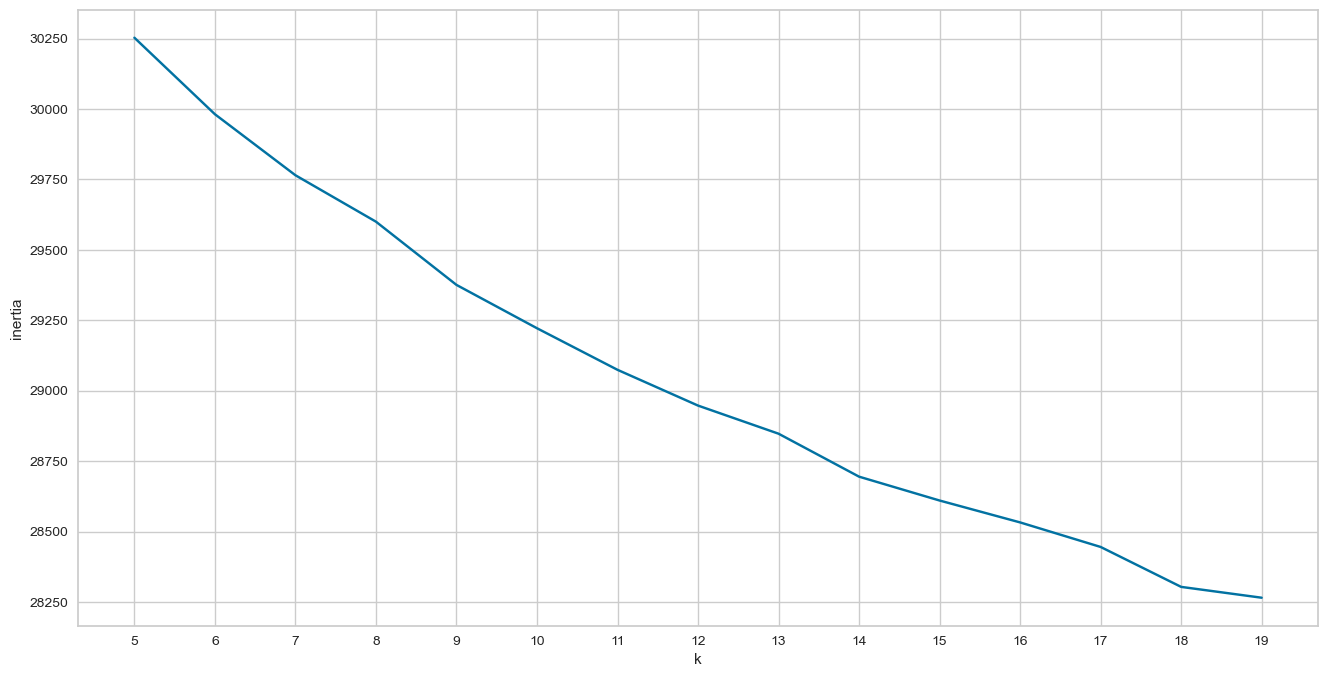

Elbow visualization: Distortion Score (KElbowVisualizer)


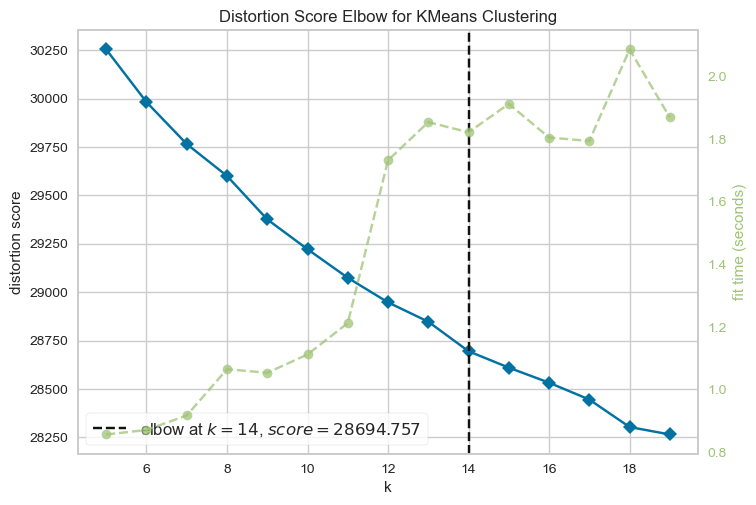

Silhouette score


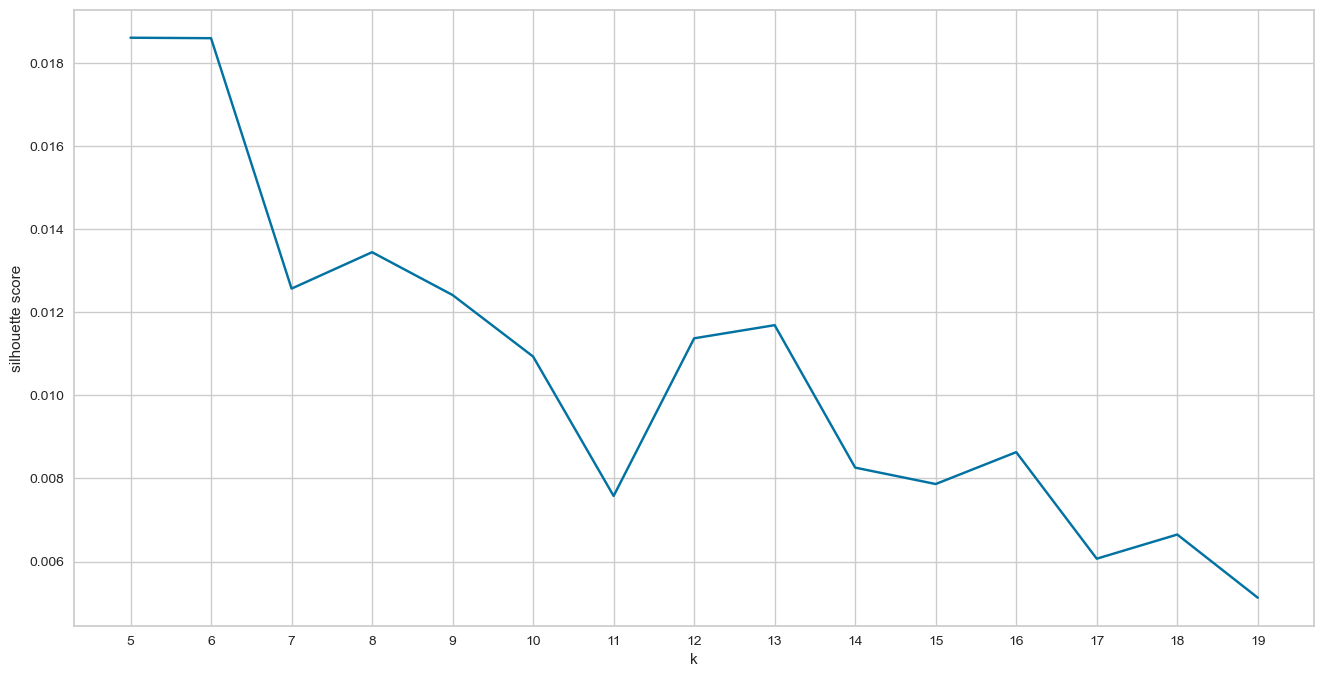

In [88]:
find_k(reduced_tasting_encoded, 5, 20)

In [89]:
kmeans = KMeans(n_clusters=12, random_state=42)
kmeans.fit(reduced_tasting_encoded)
clusters = kmeans.predict(reduced_tasting_encoded)

metrics = clustering_metrics(reduced_tasting_encoded, clusters)
evaluation_results["Reduced tasting notes + encoding"] = metrics
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840499679008},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888211255},
 'Kmeans Embeddings': {'Silhouette': 0.4936323},
 'Reduced tasting notes + encoding': {'Silhouette': 0.011371676352794449}}

Elbow visualization: Inertia


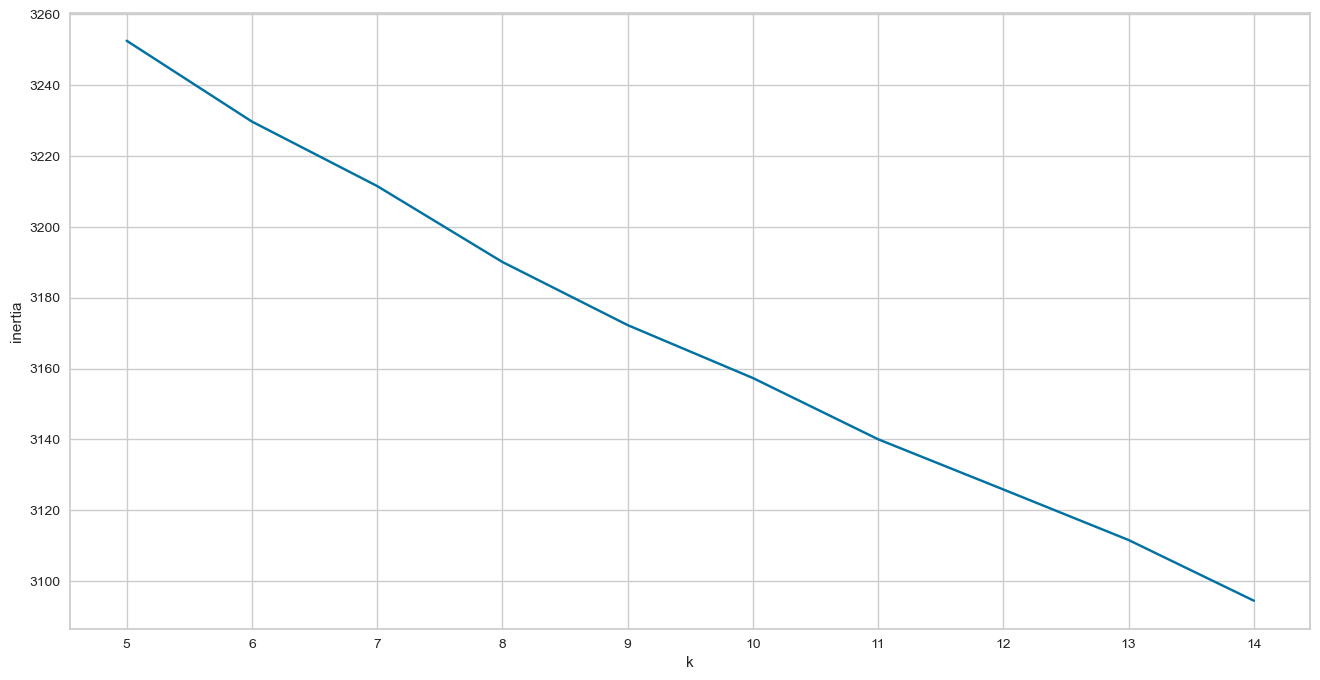

Elbow visualization: Distortion Score (KElbowVisualizer)


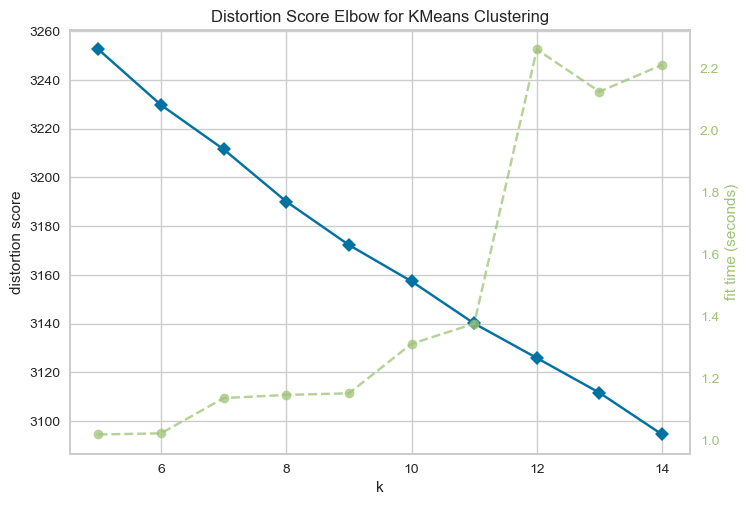

Silhouette score


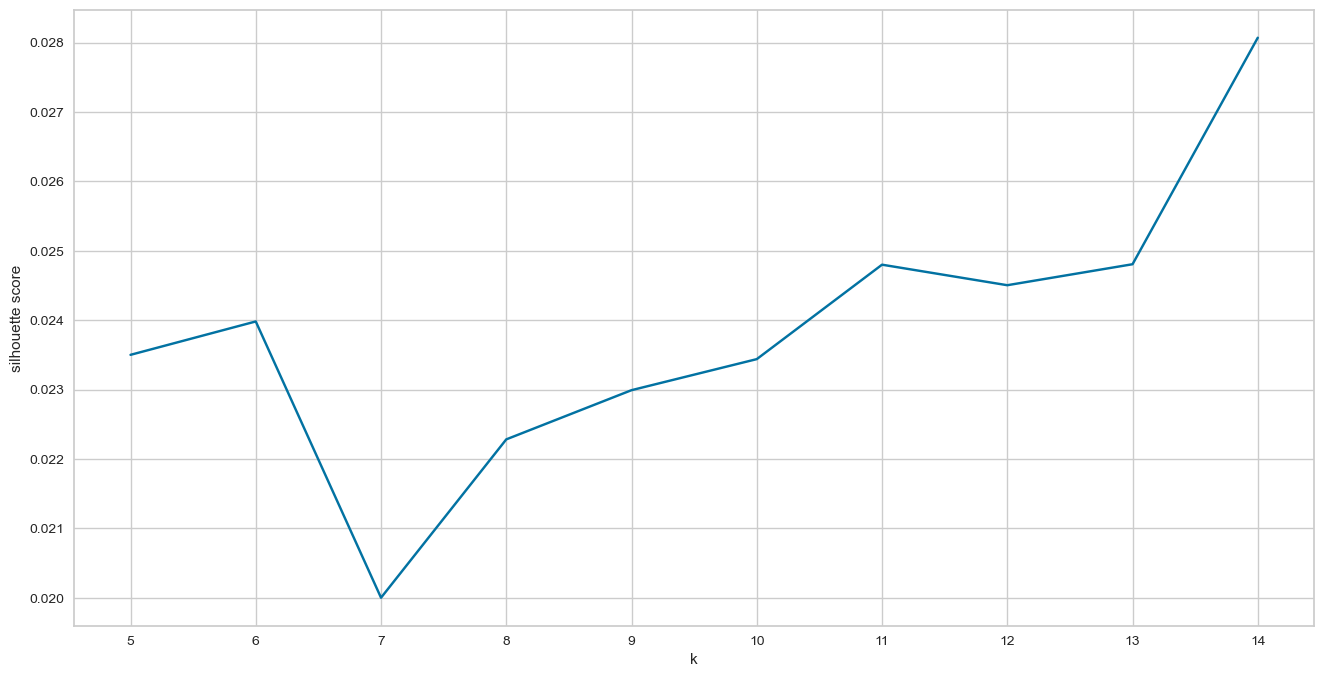

In [91]:
wine_features = wine_features.toarray() 

find_k(wine_features, 5, 15)

In [139]:
kmeans = KMeans(n_clusters=14, random_state=42)
kmeans.fit(wine_features)
clusters = kmeans.predict(wine_features)

metrics = clustering_metrics(wine_features, clusters)
evaluation_results["Reduced tasting notes + td idf"] = metrics
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840499679008},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888211255},
 'Kmeans Embeddings': {'Silhouette': 0.4936323},
 'Reduced tasting notes + encoding': {'Silhouette': 0.011371676352794449},
 'Reduced tasting notes + td idf': {'Silhouette': 0.028068851513071116}}

Elbow visualization: Inertia


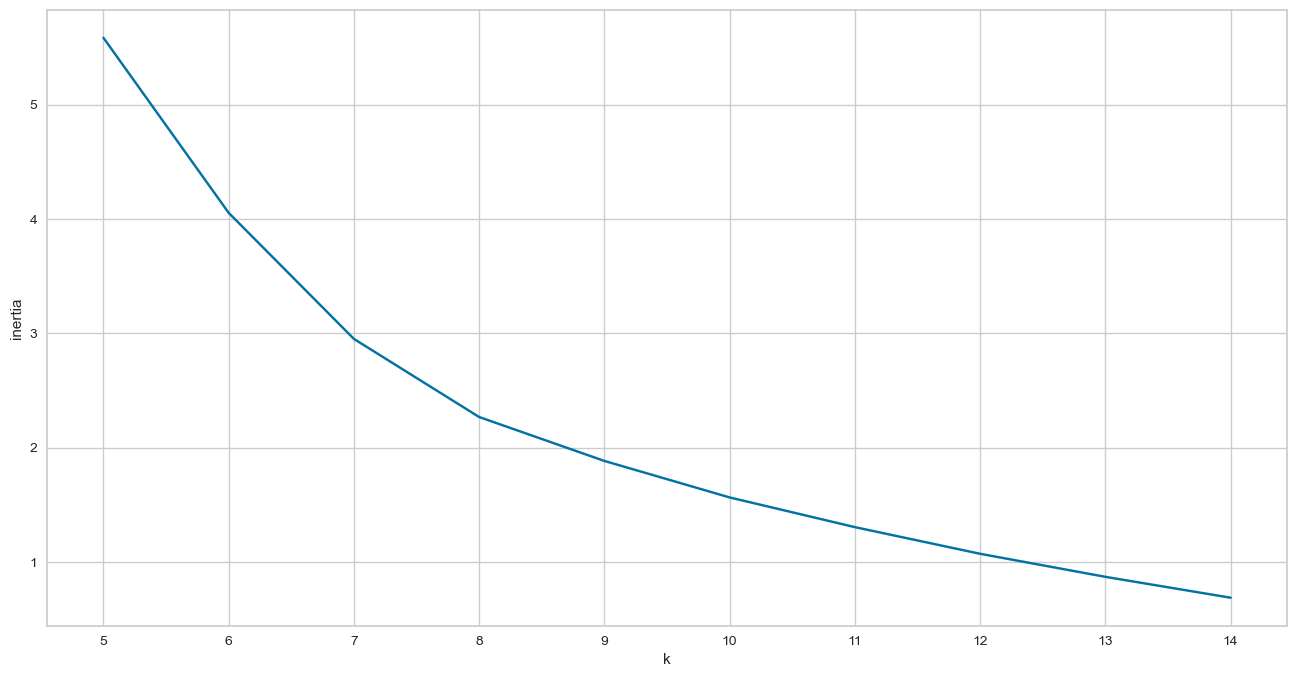

Elbow visualization: Distortion Score (KElbowVisualizer)


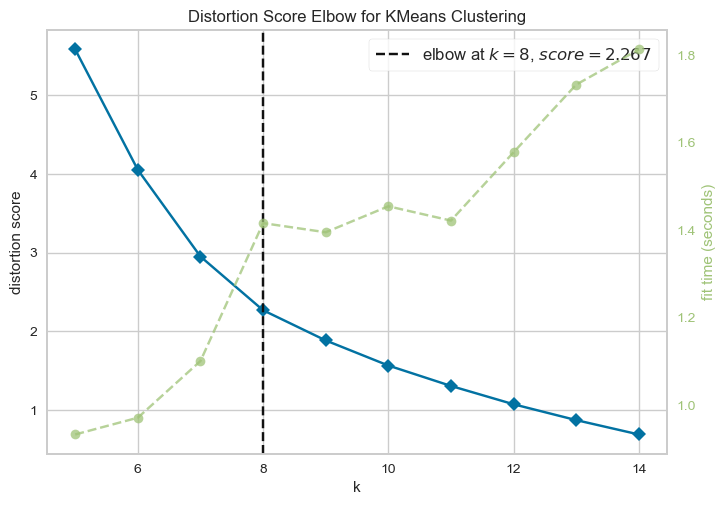

Silhouette score


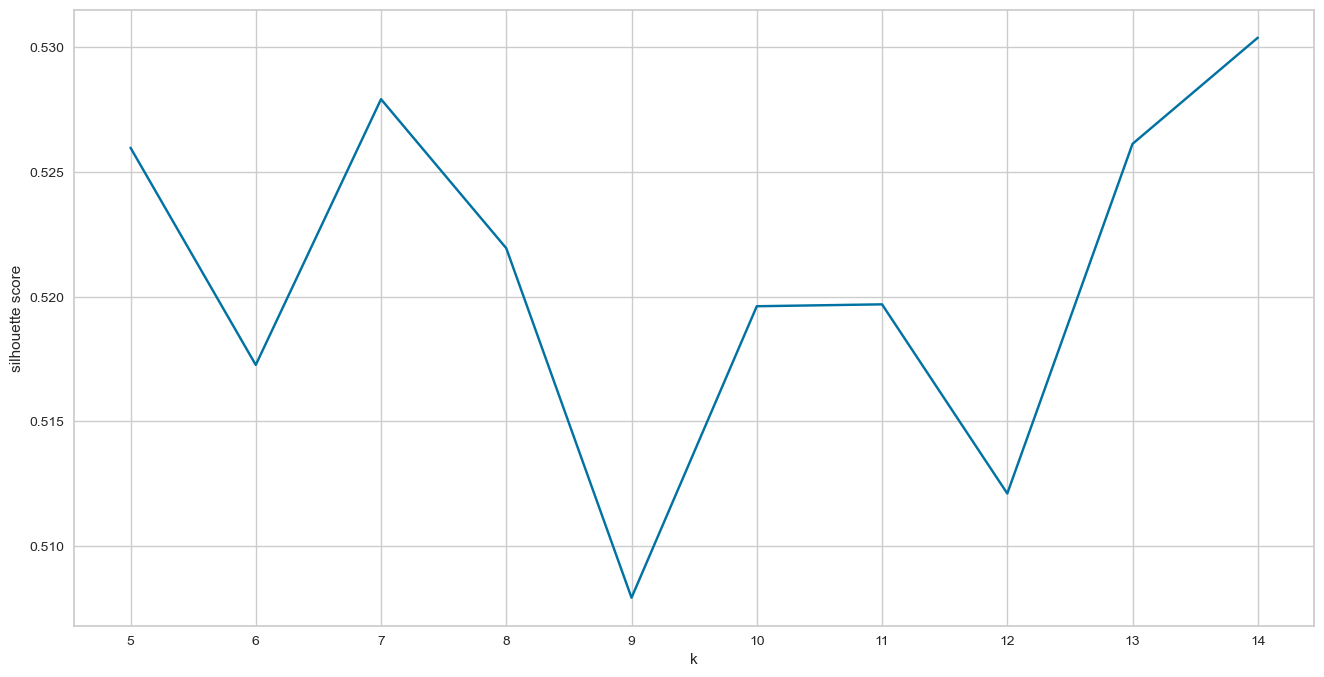

In [140]:
tfidf_embeddings = np.vstack(tfidf_embeddings)
find_k(tfidf_embeddings, 5, 15)

In [141]:
kmeans = KMeans(n_clusters=13, random_state=42)
kmeans.fit(tfidf_embeddings)
clusters = kmeans.predict(tfidf_embeddings)

metrics = clustering_metrics(tfidf_embeddings, clusters)
evaluation_results["Reduced tasting notes + embeddings"] = metrics
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840499679008},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888211255},
 'Kmeans Embeddings': {'Silhouette': 0.4936323},
 'Reduced tasting notes + encoding': {'Silhouette': 0.011371676352794449},
 'Reduced tasting notes + td idf': {'Silhouette': 0.028068851513071116},
 'Reduced tasting notes + embeddings': {'Silhouette': 0.5261307}}

There has not been a great improvement, probably because there are still too many descriptors that appear in very few wines (noise for the model).

# Increased proportion of dropped words

In [97]:
# Functions to do the transformations and return the recommended K (using KElbowVisualizer)

tfidf = TfidfVectorizer(stop_words='english')
cores = multiprocessing.cpu_count() 

def elbow_visualizer(X, k_min, k_max):
    model = KMeans(max_iter=100, random_state=42)
    visualizer = KElbowVisualizer(model, k=(k_min, k_max))
    visualizer.fit(X)
    plt.close()
    return visualizer.elbow_value_

def onehot_and_find_k_short(df, column, mink, maxk):
    # One hot encoding
    tasting_terms = [value for sublist in df[column].str.split(" ") if isinstance(sublist, list) for value in sublist]
    tasting_terms = [value for value in tasting_terms if not pd.isna(value)]
    tasting_terms = list(dict.fromkeys(tasting_terms))

    tasting_encoded = df[[column]] 
    for term in tasting_terms:
        tasting_encoded[term] = 0 

    for index, row in tasting_encoded.iterrows():
        tasting_note = row[column]
        for term in tasting_note.split(" "):
            tasting_encoded.loc[index, term] = 1
            
    tasting_encoded = tasting_encoded.drop(column, axis=1)

    one_hot_k = elbow_visualizer(tasting_encoded, 5, 15)
    
    return tasting_encoded, one_hot_k

def tfidf_and_find_k_short(df, column, mink, maxk):
    # TF-IDF
    wine_features = tfidf.fit_transform(df[column]).toarray()
    tfidf_k = elbow_visualizer(wine_features, 5, 15)    
    return wine_features, tfidf_k

def embeddings_and_find_k_short(df, column, mink, maxk):
    # Embeddings
    df["column_list"] = df[column].str.split()
    notes = df["column_list"]
    w2v_model = Word2Vec(min_count=70,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
    w2v_model.build_vocab(notes, progress_per=10000)
    w2v_model.train(notes, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
    
    def custom_tokenizer(text):
        return text.split()

    tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[column])

    tfidf_embeddings = []

    for idx in range(len(df)):
        tasting_note = df[column][idx]
        words = tasting_note.split()
        word_vectors = []
        for word in words:
            if word in w2v_model.wv:
                word_vector = w2v_model.wv[word]
                word_tfidf_score = tfidf_matrix[idx, tfidf_vectorizer.vocabulary_[word]]
                word_vectors.append(word_vector * word_tfidf_score)
        if word_vectors:
            tfidf_avg_vector = np.mean(word_vectors, axis=0)
        else:
            tfidf_avg_vector = np.zeros(word2vec_model.vector_size)  # Handle cases where no valid word vector is found
        tfidf_embeddings.append(tfidf_avg_vector)
    
    tfidf_embeddings_array = np.array(tfidf_embeddings)

    embeddings_k = elbow_visualizer(tfidf_embeddings_array, 5, 15)    
    
    return w2v_model, tfidf_embeddings, embeddings_k

In [142]:
# One hot encoding

for col in text_data.columns:
    if col.startswith("notes_norm_removed_reduced"):
        tasting_encoded, one_hot_k = onehot_and_find_k_short(text_data, col, 5, 20)
        if one_hot_k != None:
            kmeans = KMeans(n_clusters=one_hot_k, random_state=42)
            kmeans.fit(tasting_encoded)
            clusters = kmeans.predict(tasting_encoded)
            metrics = clustering_metrics(tasting_encoded, clusters)
            evaluation_results[f"Kmeans one hot with {one_hot_k} clusters in {col}"] = metrics
        else:
            evaluation_results[f"Kmeans one hot {col}"] = None

evaluation_results      

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840499679008},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888211255},
 'Kmeans Embeddings': {'Silhouette': 0.4936323},
 'Reduced tasting notes + encoding': {'Silhouette': 0.011371676352794449},
 'Reduced tasting notes + td idf': {'Silhouette': 0.028068851513071116},
 'Reduced tasting notes + embeddings': {'Silhouette': 0.5261307}}

In [143]:
# TF-IDF

for col in text_data.columns:
    if col.startswith("notes_norm_removed_reduced"):
        wine_features, tfidf_k = tfidf_and_find_k_short(text_data, col, 5, 20)
        if tfidf_k != None:
            kmeans = KMeans(n_clusters=tfidf_k, random_state=42)
            kmeans.fit(wine_features)
            clusters = kmeans.predict(wine_features)
            metrics = clustering_metrics(wine_features, clusters)
            evaluation_results[f"Kmeans TF-IDF with {tfidf_k} clusters in {col}"] = metrics
        else:
            evaluation_results[f"Kmeans TF-IDF {col}"] = None
        
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840499679008},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888211255},
 'Kmeans Embeddings': {'Silhouette': 0.4936323},
 'Reduced tasting notes + encoding': {'Silhouette': 0.011371676352794449},
 'Reduced tasting notes + td idf': {'Silhouette': 0.028068851513071116},
 'Reduced tasting notes + embeddings': {'Silhouette': 0.5261307}}

In [144]:
# TF-IDF with 9 clusters

for col in text_data.columns:
    if col.startswith("notes_norm_removed_reduced"):
        wine_features, tfidf_k = tfidf_and_find_k_short(text_data, col, 5, 20)
        tfidf_k = 9
        if tfidf_k != None:
            kmeans = KMeans(n_clusters=tfidf_k, random_state=42)
            kmeans.fit(wine_features)
            clusters = kmeans.predict(wine_features)
            metrics = clustering_metrics(wine_features, clusters)
            evaluation_results[f"Kmeans TF-IDF with {tfidf_k} clusters in {col}"] = metrics
        else:
            evaluation_results[f"Kmeans TF-IDF {col}"] = None
        
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840499679008},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888211255},
 'Kmeans Embeddings': {'Silhouette': 0.4936323},
 'Reduced tasting notes + encoding': {'Silhouette': 0.011371676352794449},
 'Reduced tasting notes + td idf': {'Silhouette': 0.028068851513071116},
 'Reduced tasting notes + embeddings': {'Silhouette': 0.5261307}}

In [145]:
# Embeddings

for col in text_data.columns:
    if col.startswith("notes_norm_removed_reduced"):
        w2v_model, tfidf_embeddings, embeddings_k = embeddings_and_find_k_short(text_data, col, 5, 20)
        if embeddings_k != None:
            kmeans = KMeans(n_clusters=embeddings_k, random_state=42)
            kmeans.fit(tfidf_embeddings)
            clusters = kmeans.predict(tfidf_embeddings)
            metrics = clustering_metrics(tfidf_embeddings, clusters)
            evaluation_results[f"Kmeans embeddings with {embeddings_k} clusters in {col}"] = metrics
        else:
            evaluation_results[f"Kmeans embeddings {col}"] = None
        
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840499679008},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888211255},
 'Kmeans Embeddings': {'Silhouette': 0.4936323},
 'Reduced tasting notes + encoding': {'Silhouette': 0.011371676352794449},
 'Reduced tasting notes + td idf': {'Silhouette': 0.028068851513071116},
 'Reduced tasting notes + embeddings': {'Silhouette': 0.5261307}}

The best results are cleary obtained with the word embeddings. Regarding the threshold for the dropped terms, the highest silhouette score was obtained with 300, but we have to bear in mind that this removes 88% of our descriptors (compared with threshold = 1).<br>
Therefore we will try also the clustering with 200 (leaves out 74% of the descriptors) and with 1.

In [99]:
# Function that transforms to embeddings and displays visualizations for finding the optimal K

def embeddings_and_find_k(df, column, mink, maxk):
    # Embeddings
    df["column_list"] = df[column].str.split()
    notes = df["column_list"]
    w2v_model = Word2Vec(min_count=70,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
    w2v_model.build_vocab(notes, progress_per=10000)
    w2v_model.train(notes, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
    
    def custom_tokenizer(text):
        return text.split()

    tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[column])

    tfidf_embeddings = []

    for idx in range(len(df)):
        tasting_note = df[column][idx]
        words = tasting_note.split()
        word_vectors = []
        for word in words:
            if word in w2v_model.wv:
                word_vector = w2v_model.wv[word]
                word_tfidf_score = tfidf_matrix[idx, tfidf_vectorizer.vocabulary_[word]]
                word_vectors.append(word_vector * word_tfidf_score)
        if word_vectors:
            tfidf_avg_vector = np.mean(word_vectors, axis=0)
        else:
            tfidf_avg_vector = np.zeros(word2vec_model.vector_size)  # Handle cases where no valid word vector is found
        tfidf_embeddings.append(tfidf_avg_vector)
    
    tfidf_embeddings_array = np.array(tfidf_embeddings)
    
    find_k(tfidf_embeddings_array, mink, maxk)
    
    return w2v_model, tfidf_embeddings_array

Elbow visualization: Inertia


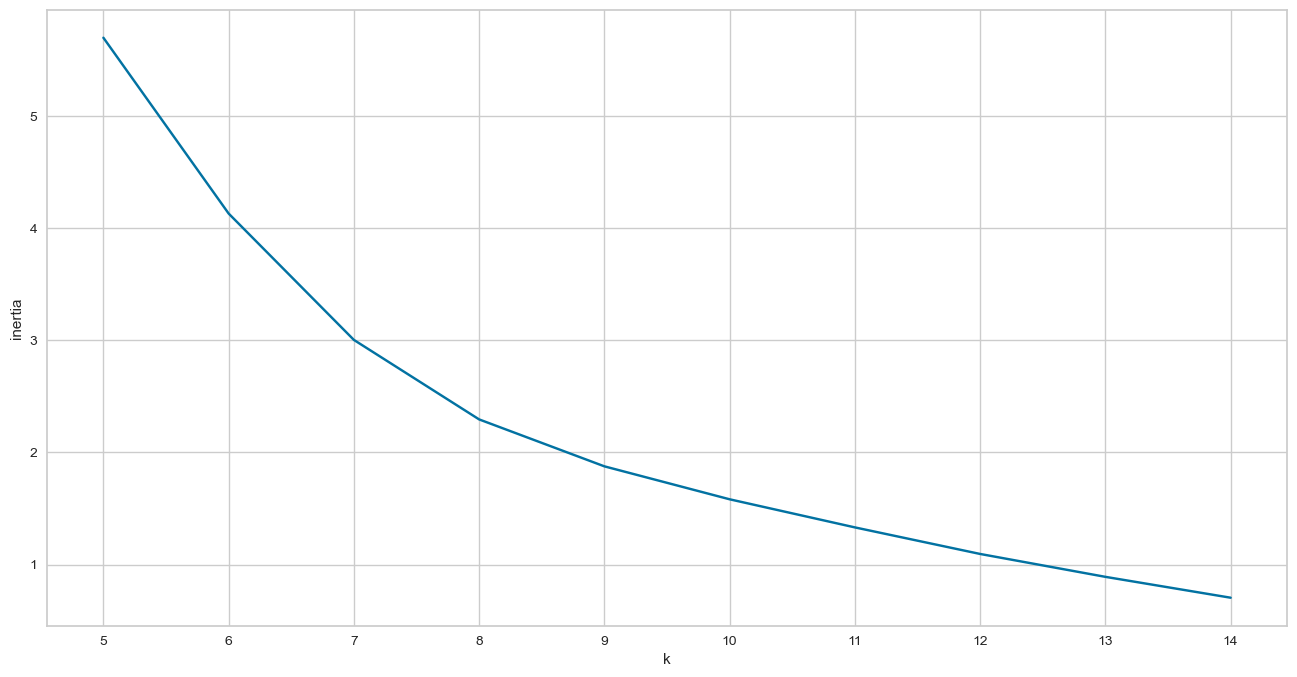

Elbow visualization: Distortion Score (KElbowVisualizer)


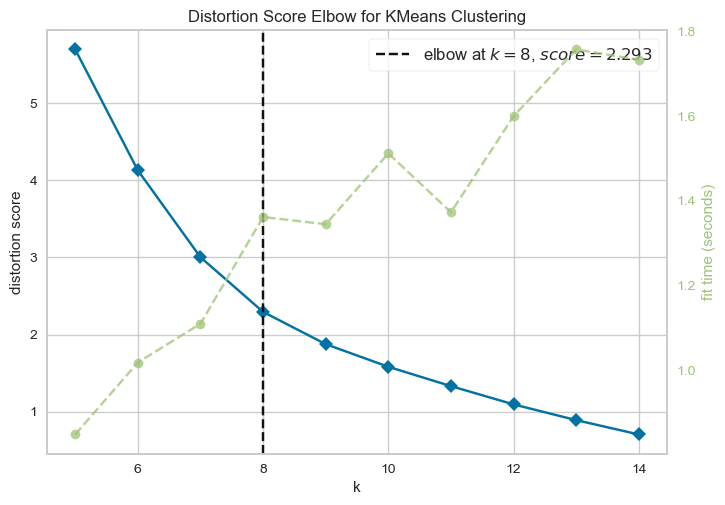

Silhouette score


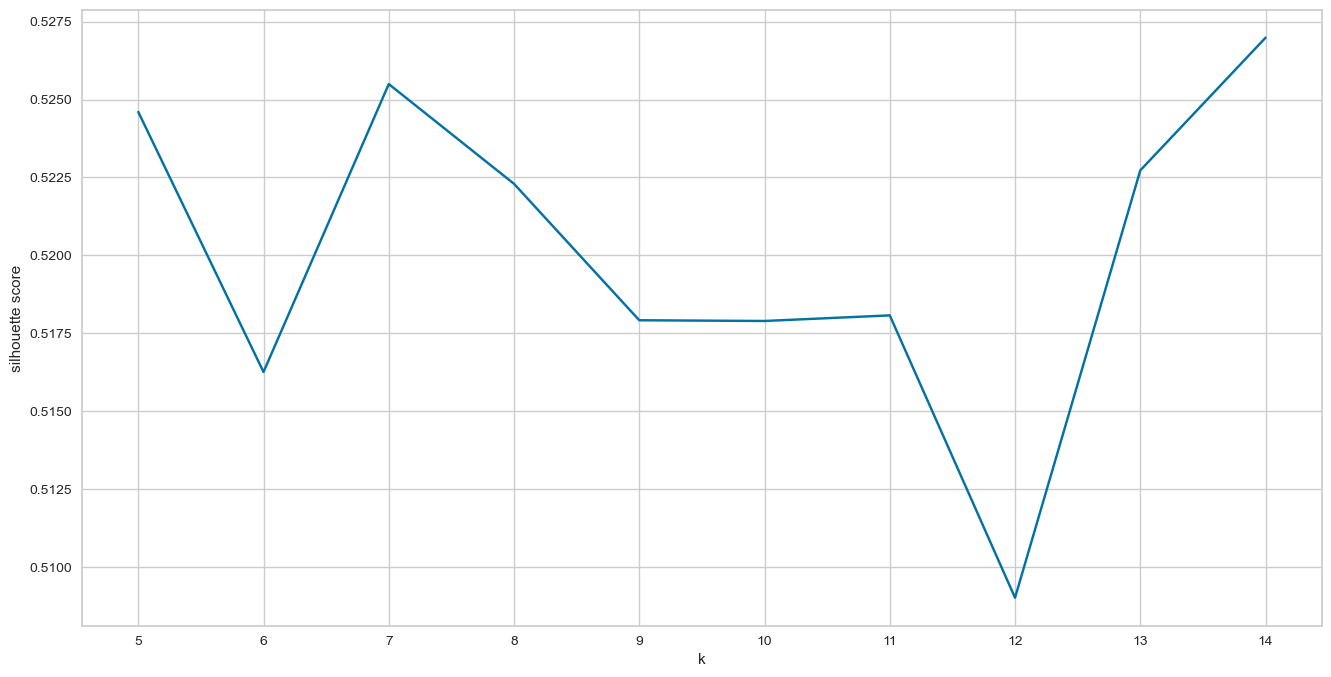

In [150]:
w2v_model, embeddings1 = embeddings_and_find_k(text_data, "notes_norm_removed_reduced", 5, 15)

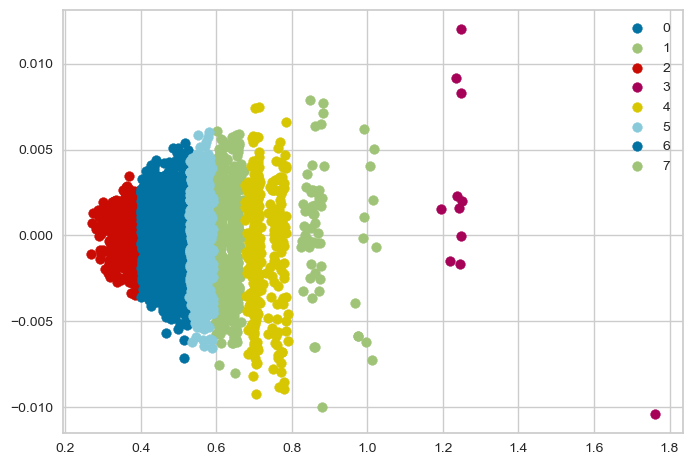

In [151]:
plot_clusters_kmeans(embeddings1, 8)

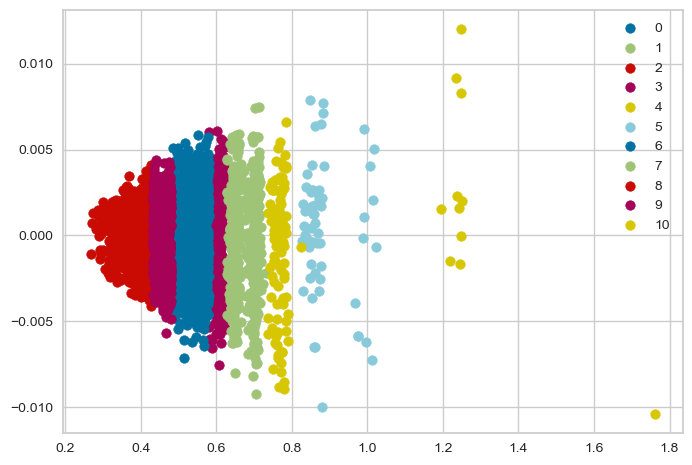

In [152]:
plot_clusters_kmeans(embeddings1, 11)

Elbow visualization: Inertia


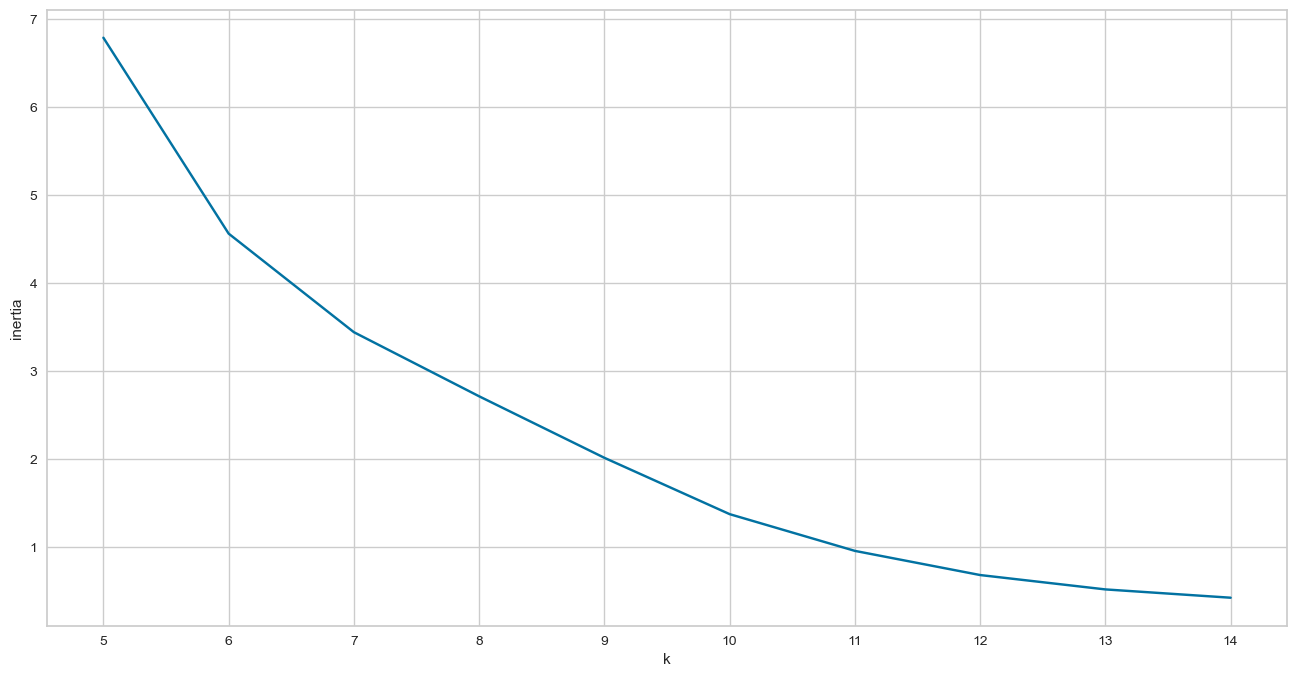

Elbow visualization: Distortion Score (KElbowVisualizer)


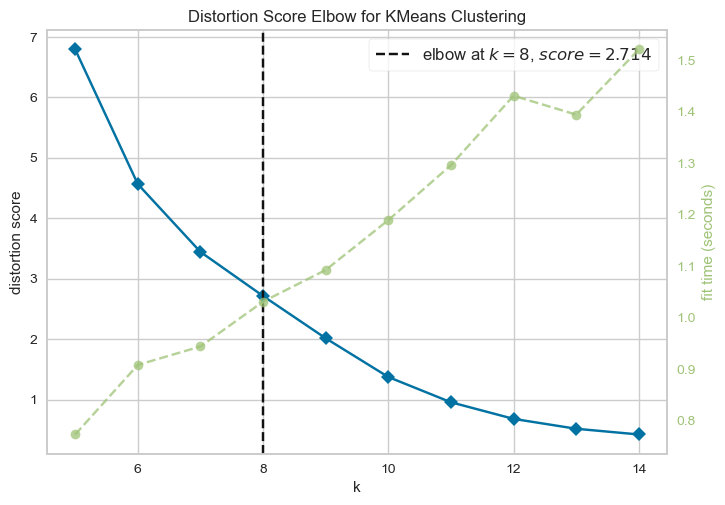

Silhouette score


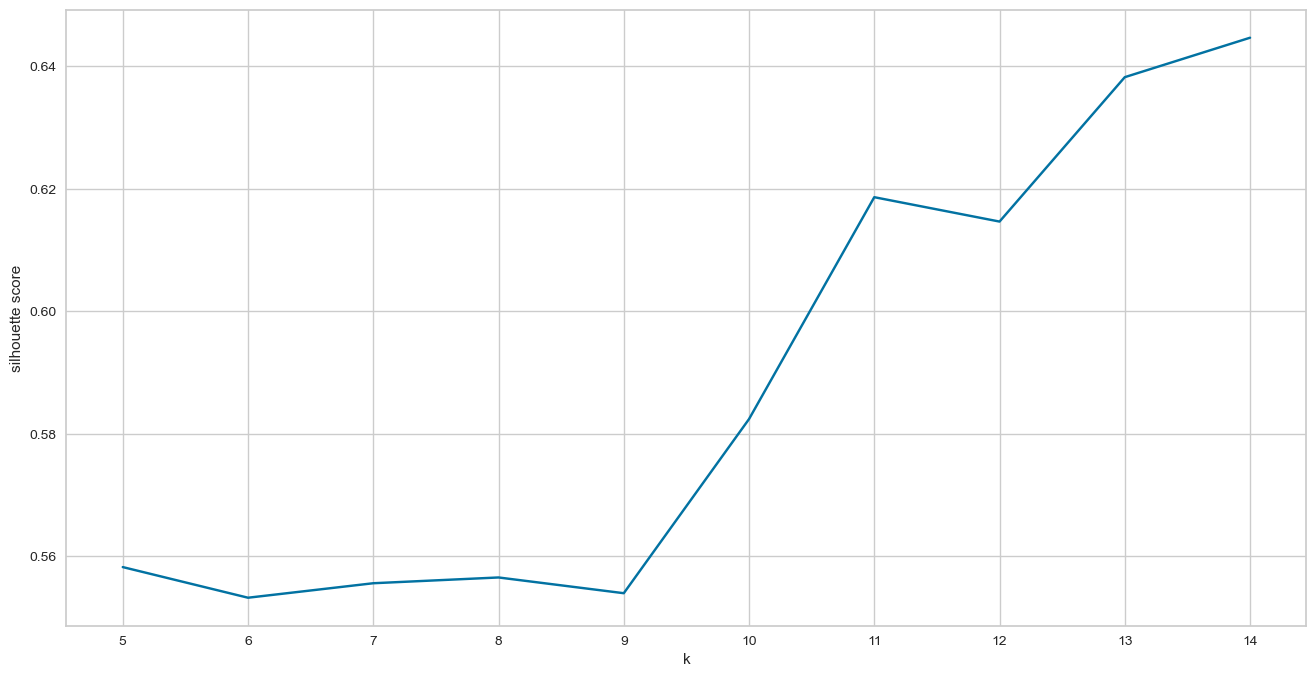

In [153]:
w2v_model, embeddings100 = embeddings_and_find_k(text_data, "notes_norm_removed_reduced100", 5, 15)

In the inertia visualization there is a potential elbow in 7. We will try also with 9 (elbow detected by KElbowVisualizer) and 14 (higher SC)

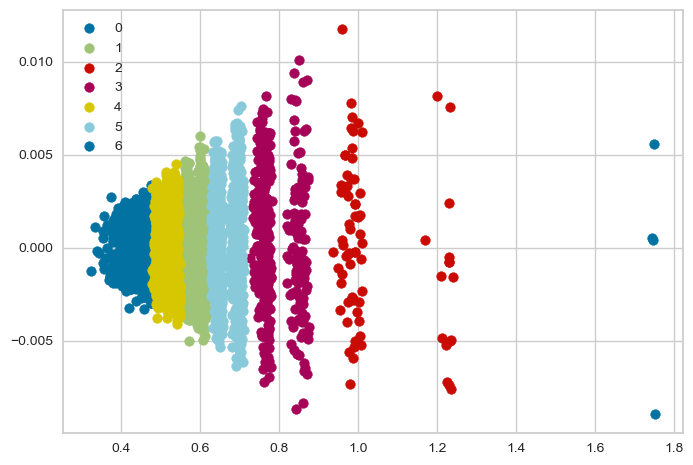

In [154]:
plot_clusters_kmeans(embeddings100, 7)

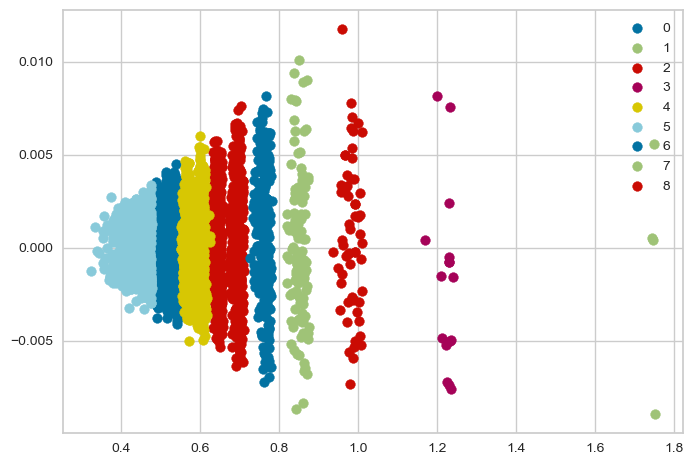

In [155]:
plot_clusters_kmeans(embeddings100, 9)

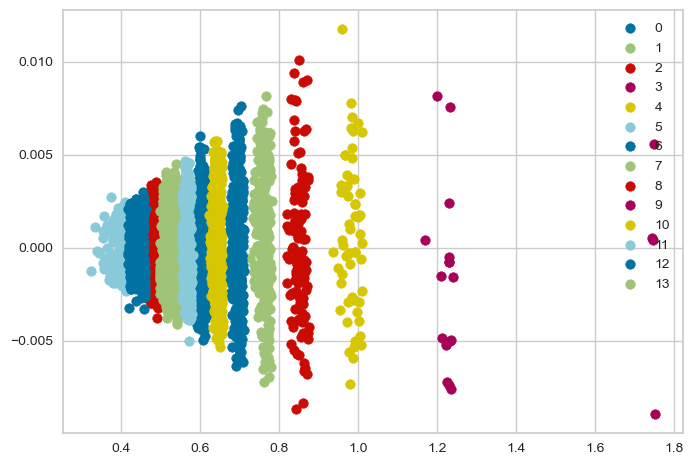

In [156]:
plot_clusters_kmeans(embeddings100, 14)

Elbow visualization: Inertia


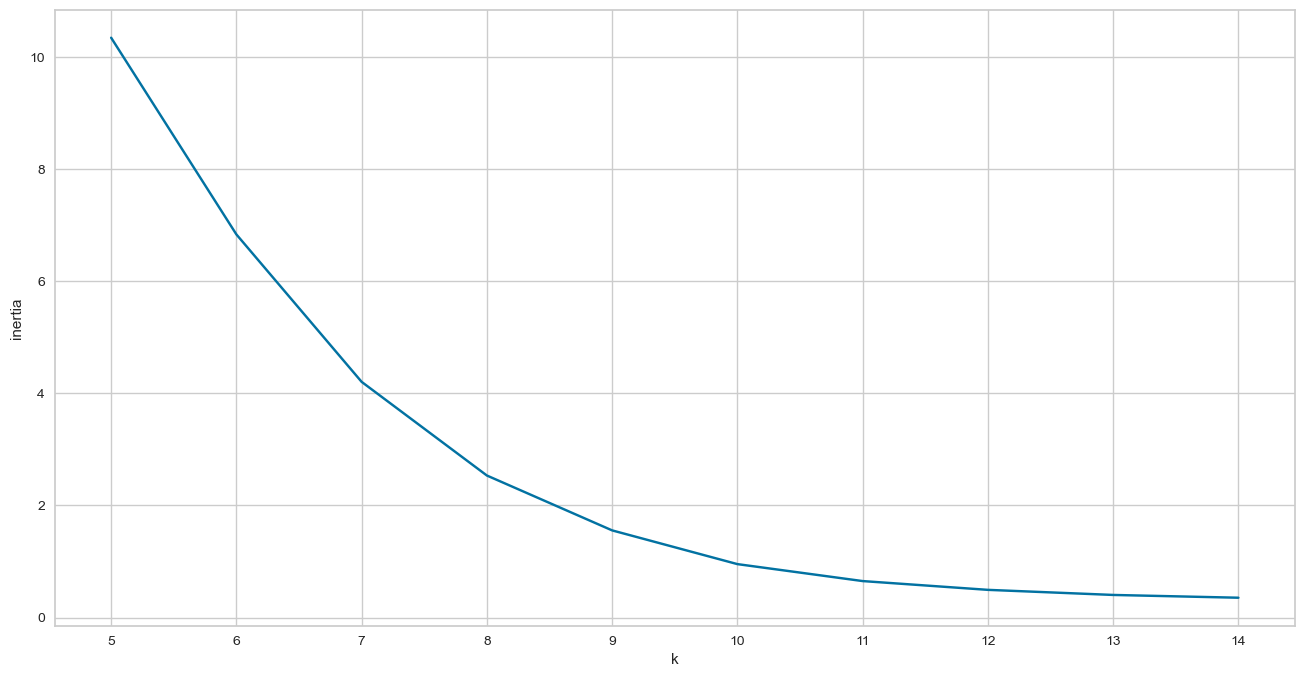

Elbow visualization: Distortion Score (KElbowVisualizer)


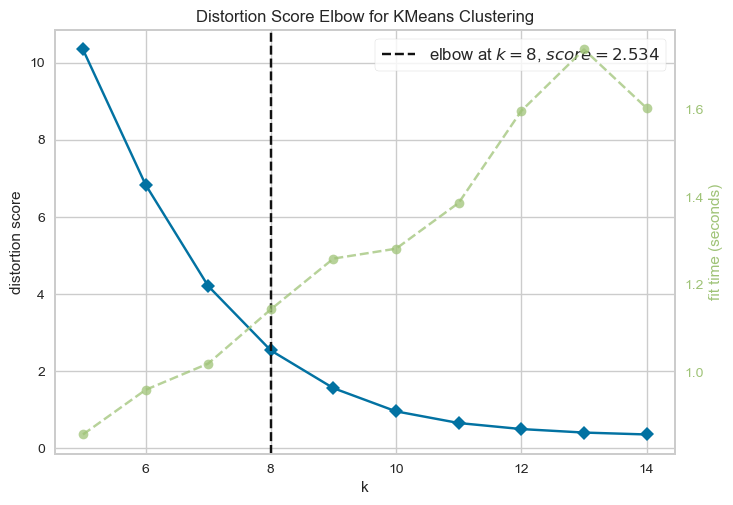

Silhouette score


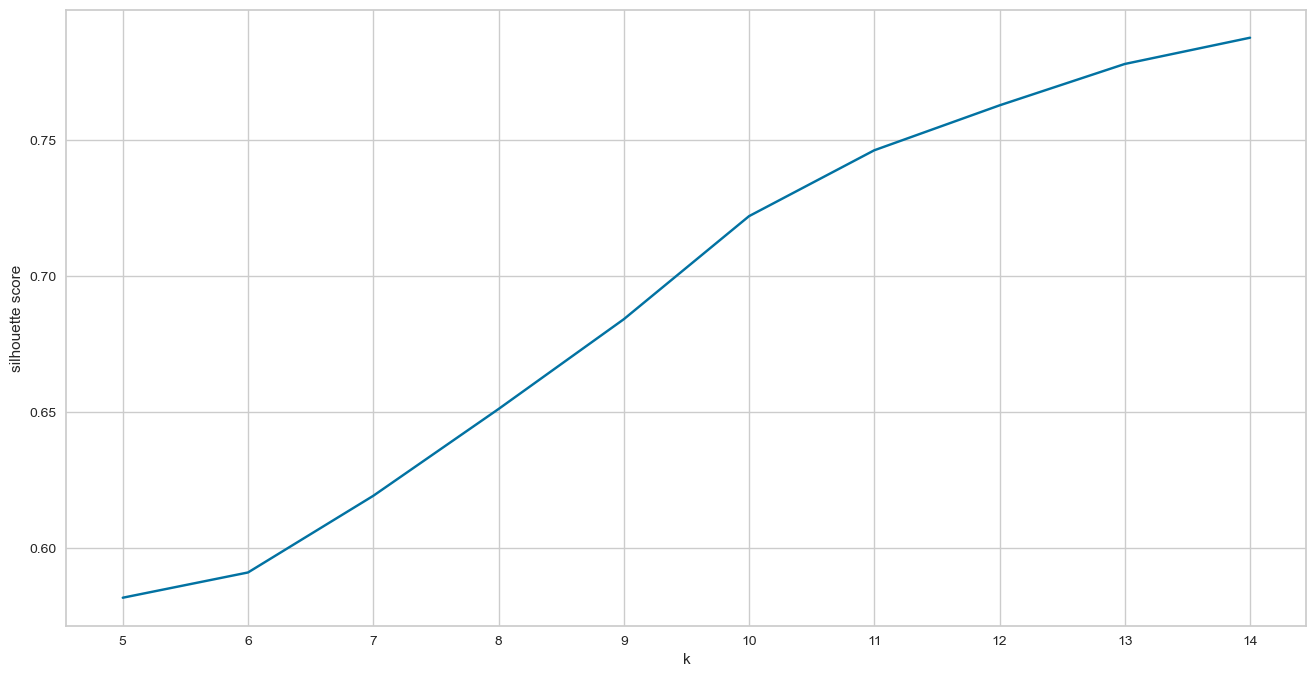

In [157]:
w2v_model, embeddings300 = embeddings_and_find_k(text_data, "notes_norm_removed_reduced300", 5, 15)

K=8 is the elbow but 14 has a much higher silhouette score. 

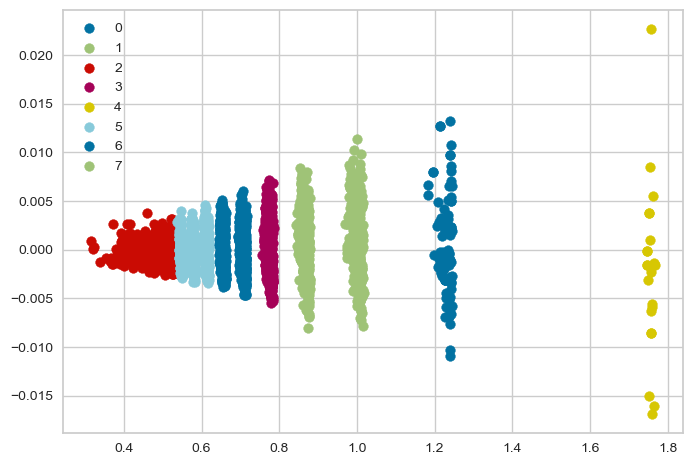

In [158]:
plot_clusters_kmeans(embeddings300, 8)

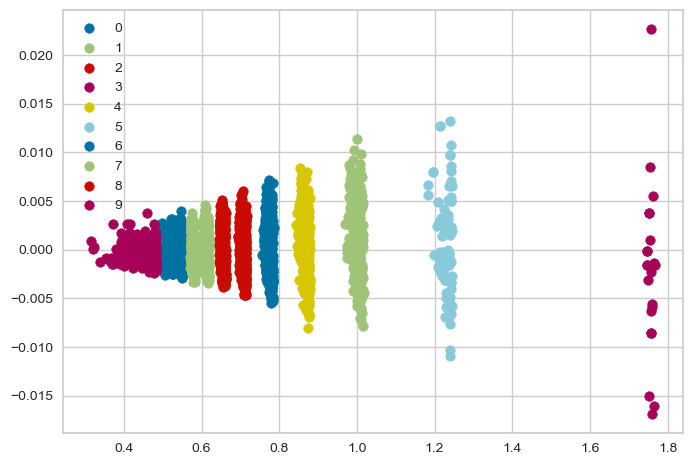

In [159]:
plot_clusters_kmeans(embeddings300, 10)

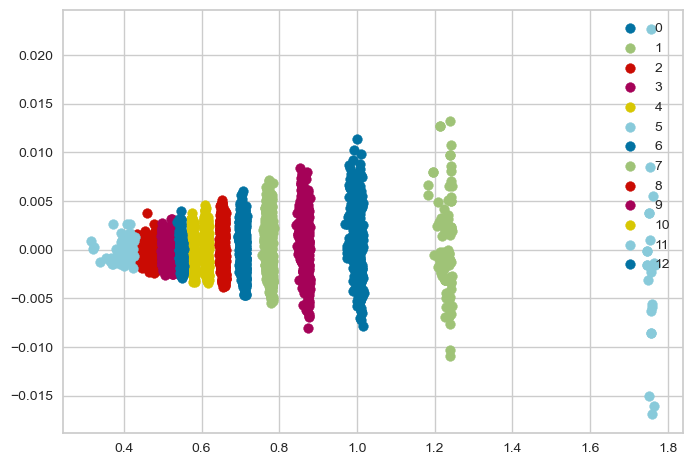

In [160]:
plot_clusters_kmeans(embeddings300, 13)

# Cluster with DBSCAN

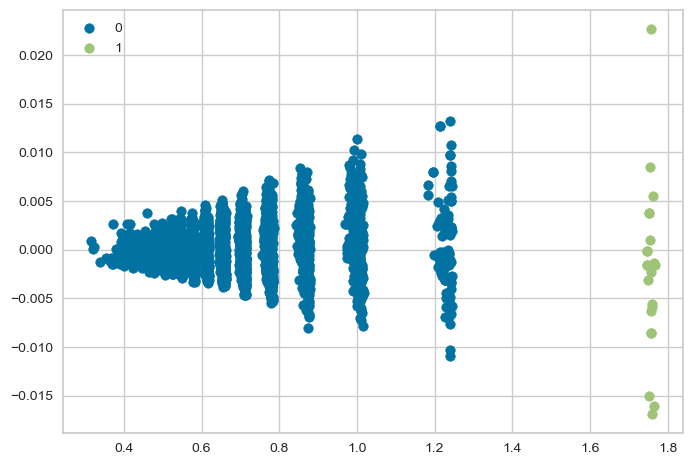

In [161]:
plot_clusters_dbscan(embeddings300, 0.5)

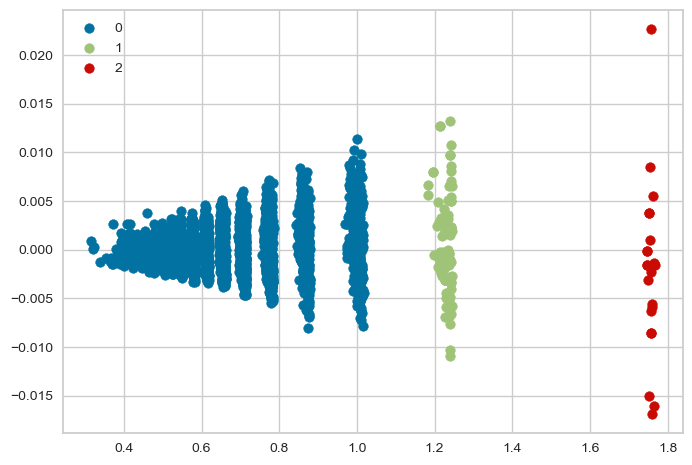

In [162]:
plot_clusters_dbscan(embeddings300, 0.1)

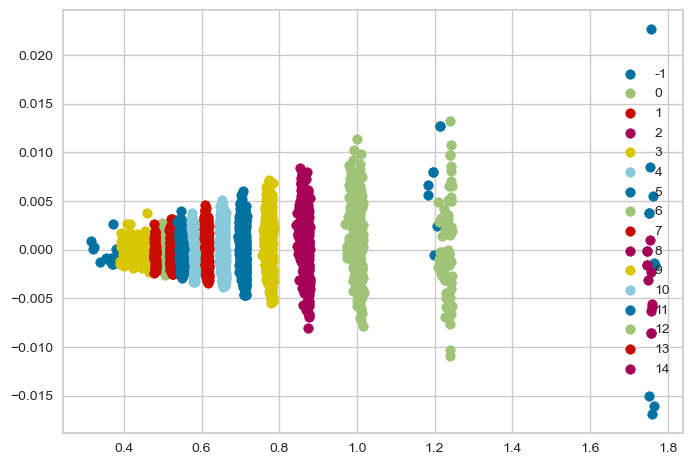

In [163]:
plot_clusters_dbscan(embeddings300, 0.005)

DBSCAN is clearly performing worse than KMeans for this dataset.

# Clustering with Gaussian Mixtures

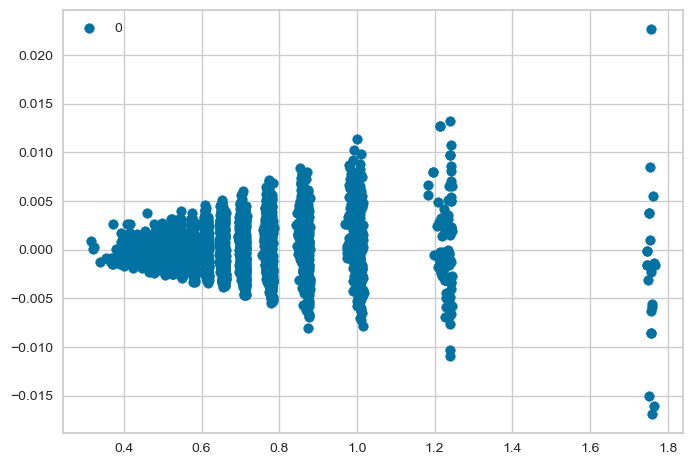

In [164]:
plot_clusters_gaussian(embeddings300, 1)

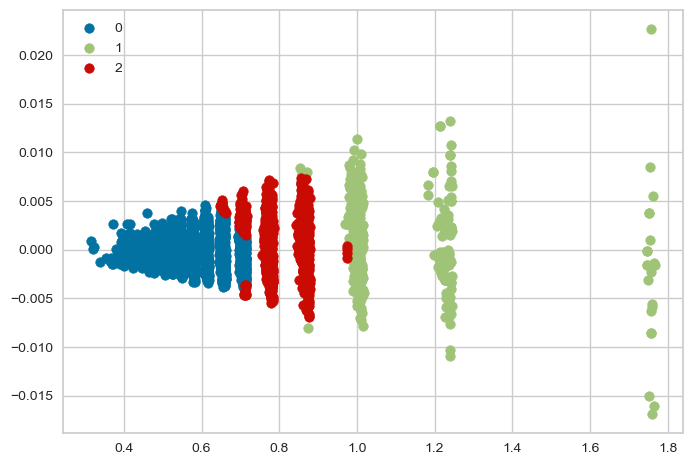

In [165]:
plot_clusters_gaussian(embeddings300, 3)

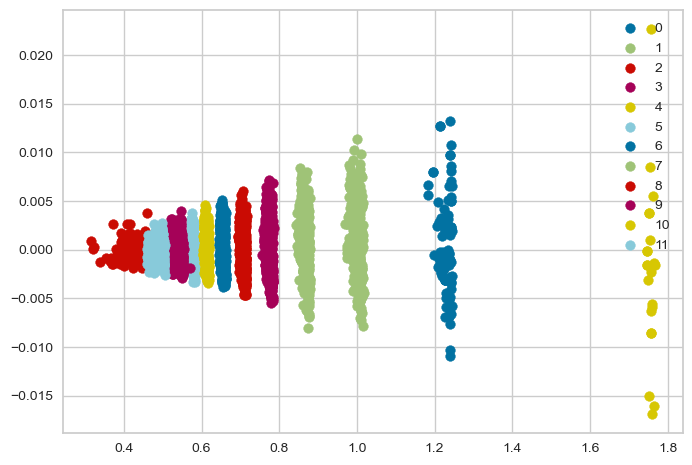

In [166]:
plot_clusters_gaussian(embeddings300, 12)

## Preliminary conclusions
We have tried three types of models: KMeans, DBSCAN and Gaussian Mixtures, and KMeans is performing much better than the other two for this dataset. <br>
We have also tried different thresholds for dropping the less common descriptors, and dropping all the terms that appear less than 300 times greatly improves the performance of the model, as shown by the Silhouette Score and by the clusters visualizations. <br>
However, this removes 88% of our descriptors. To make sure that the principal characteristics of the wines are preserved, we have done a new reduction of the tasting notes descriptors (see the EDA notebook).

### New reduction of the tasting notes descriptors

Elbow visualization: Inertia


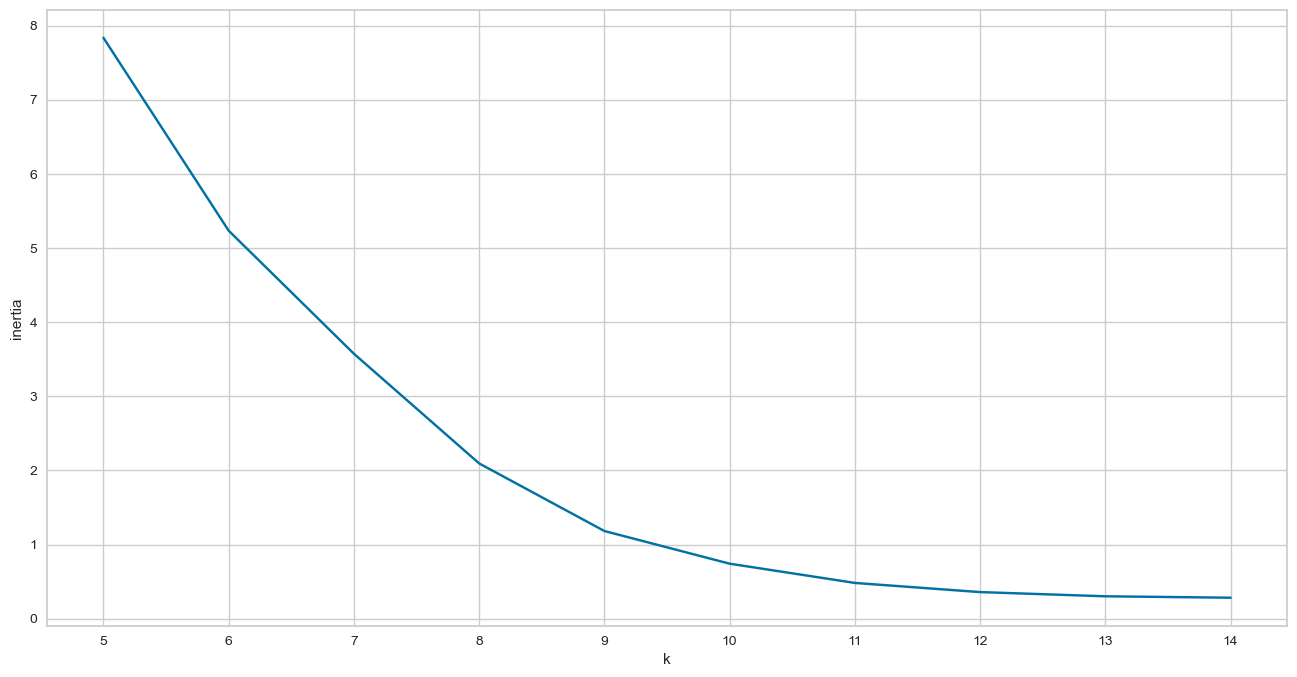

Elbow visualization: Distortion Score (KElbowVisualizer)


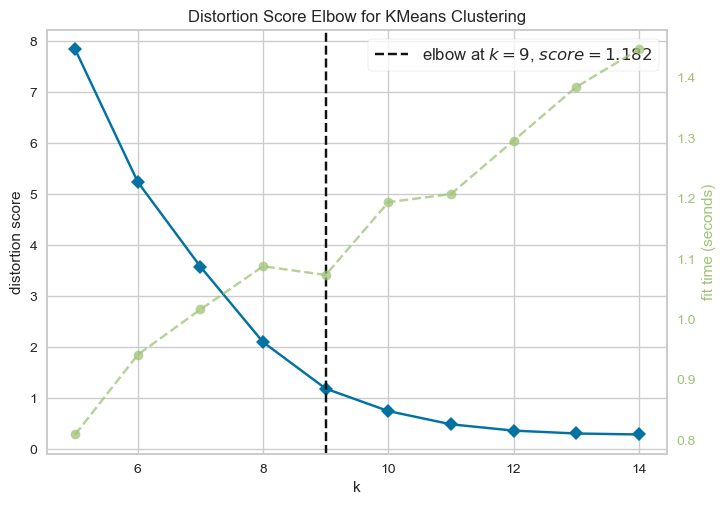

Silhouette score


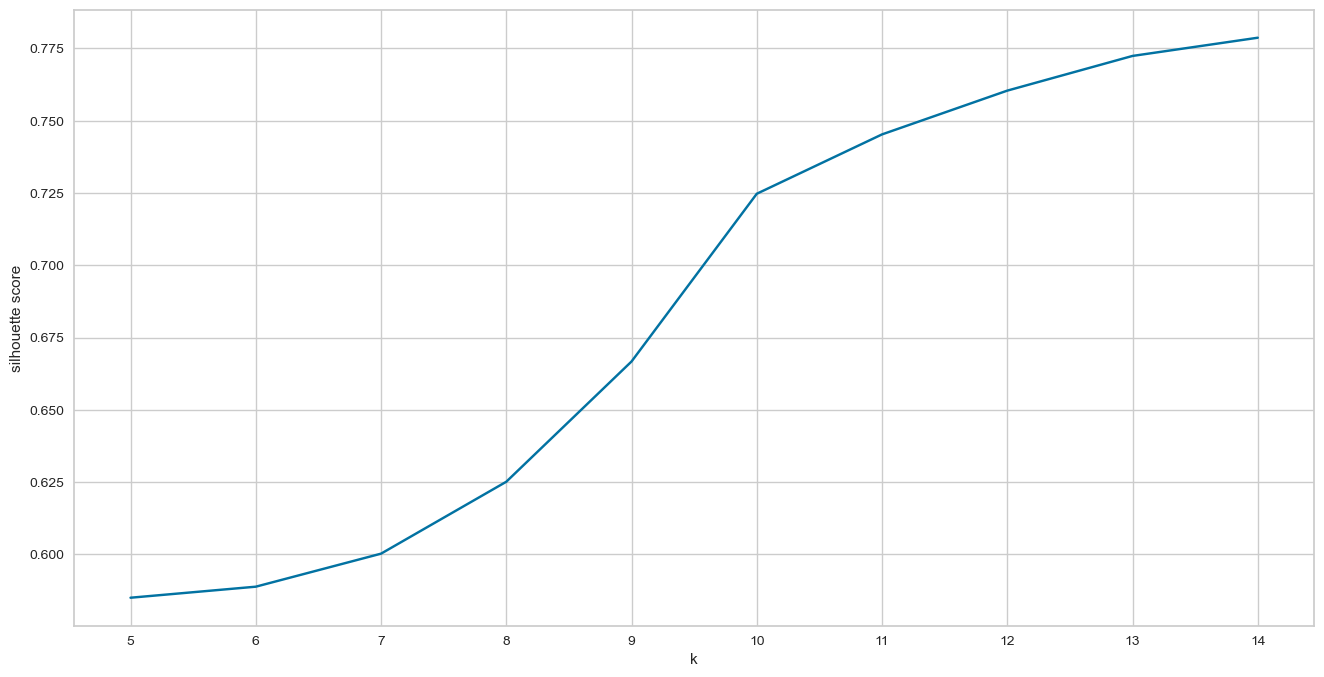

In [100]:
w2v_model, new_embeddings = embeddings_and_find_k(text_data, "notes_norm_removed_new_reduction_dropped", mink=5, maxk=15)

In [101]:
# Get the vocabulary of the Word2Vec model
word2vec_vocabulary = list(set(w2v_model.wv.index_to_key))
word2vec_vocabulary

['mineral',
 'structured',
 'citrus_fruit',
 'bottle_aging',
 'stone_fruit',
 'rounded',
 'black_fruit',
 'complex',
 'herbs',
 'spices',
 'full',
 'good_acidity',
 'unctuous',
 'balanced',
 'rich',
 'long',
 'powerful',
 'red_fruit',
 'dried_cooked_fruits',
 'flavoursome',
 'silky',
 'fresh',
 'toasty',
 'floral',
 'crunchy',
 'wood',
 'pleasant',
 'ageing',
 'tropical_fruit',
 'smooth',
 'elegant',
 'tannins',
 'balsamic',
 'green_fruit',
 'white_fruit',
 'persistent',
 'aromatic',
 'finish']

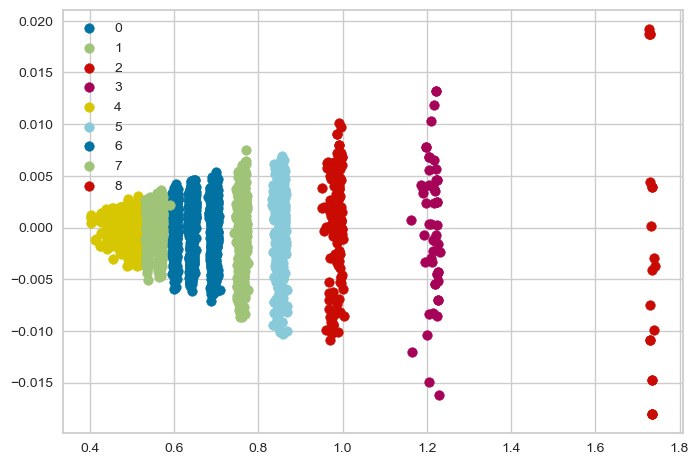

In [102]:
plot_clusters_kmeans(new_embeddings, 9)

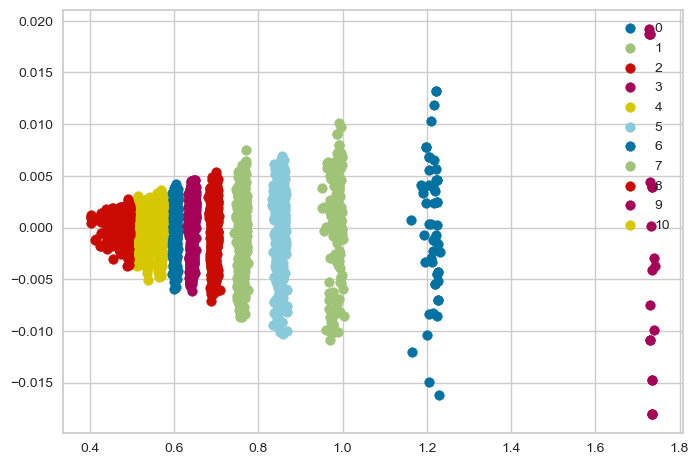

In [103]:
plot_clusters_kmeans(new_embeddings, 11)

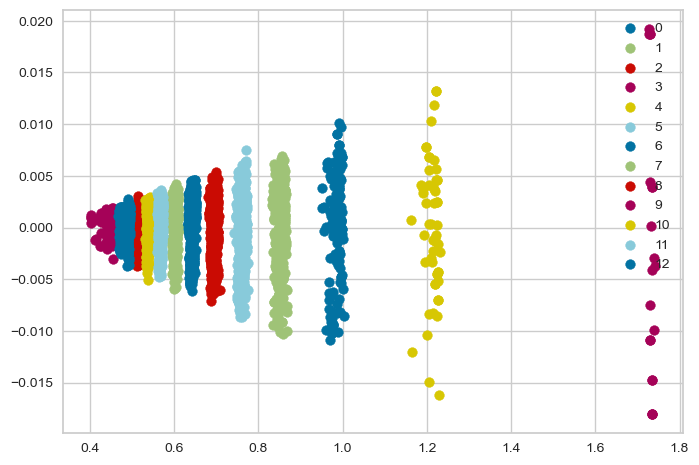

In [104]:
plot_clusters_kmeans(new_embeddings, 13)

In [168]:
for k in [9, 11, 13]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(new_embeddings)
    clusters = kmeans.predict(new_embeddings)
    metrics = clustering_metrics(new_embeddings, clusters)
    evaluation_results[f"Kmeans embeddings with {k} clusters in notes_norm_removed_new_reduction_dropped"] = metrics
        
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840499679008},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888211255},
 'Kmeans Embeddings': {'Silhouette': 0.4936323},
 'Reduced tasting notes + encoding': {'Silhouette': 0.011371676352794449},
 'Reduced tasting notes + td idf': {'Silhouette': 0.028068851513071116},
 'Reduced tasting notes + embeddings': {'Silhouette': 0.5261307},
 'Kmeans embeddings with 9 clusters in notes_norm_removed_new_reduction_dropped': {'Silhouette': 0.66673744},
 'Kmeans embeddings with 11 clusters in notes_norm_removed_new_reduction_dropped': {'Silhouette': 0.74527305},
 'Kmeans embeddings with 13 clusters in notes_norm_removed_new_reduction_dropped': {'Silhouette': 0.772409}}

## Explore the clusters
We will have a look into the clusters obtained with K=11 and with K=13.

In [105]:
kmeans = KMeans(n_clusters=11, random_state=42)
kmeans.fit(new_embeddings)
clusters11 = kmeans.predict(new_embeddings)
text_data["cluster11"] = clusters11

In [106]:
kmeans = KMeans(n_clusters=13, random_state=42)
kmeans.fit(new_embeddings)
clusters13 = kmeans.predict(new_embeddings)
text_data["cluster13"] = clusters13

In [108]:
# text_data.head()

### K=11

In [109]:
text_data["cluster11"].value_counts()

0     593
8     555
2     492
10    477
5     472
7     416
9     317
1     279
6     140
4      55
3      20
Name: cluster11, dtype: int64

CLUSTER 0
The size of this cluster is 593 wines


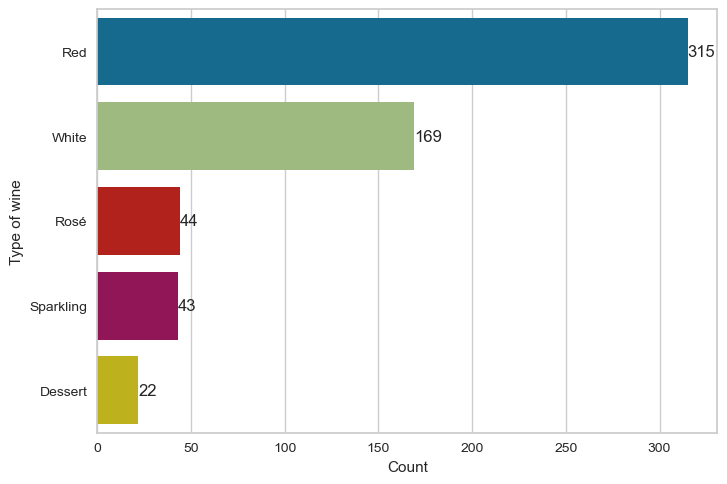

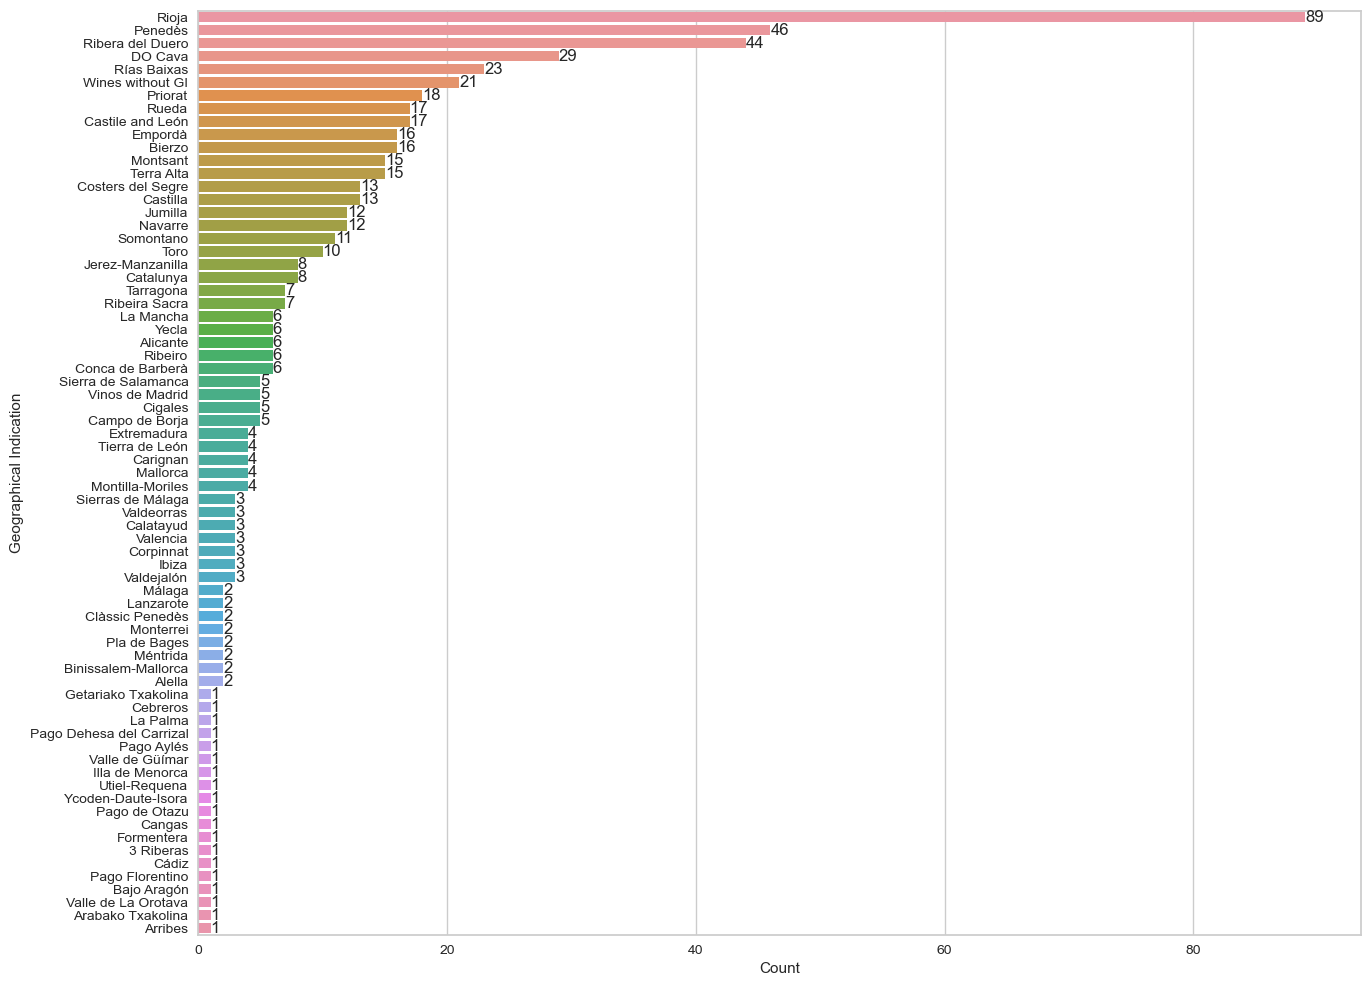

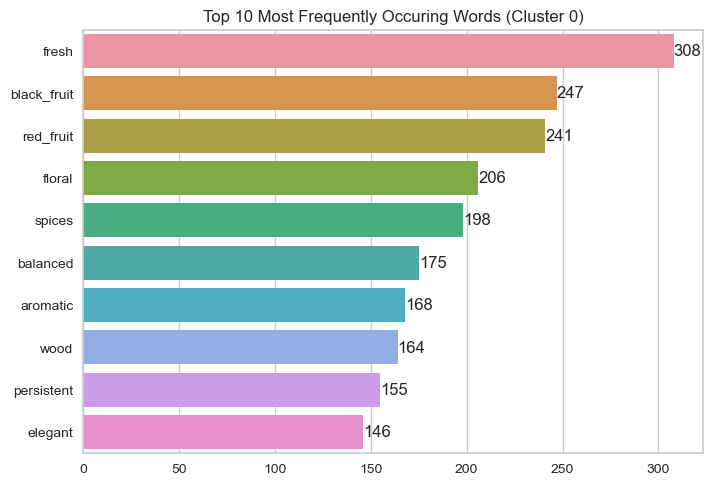

CLUSTER 1
The size of this cluster is 279 wines


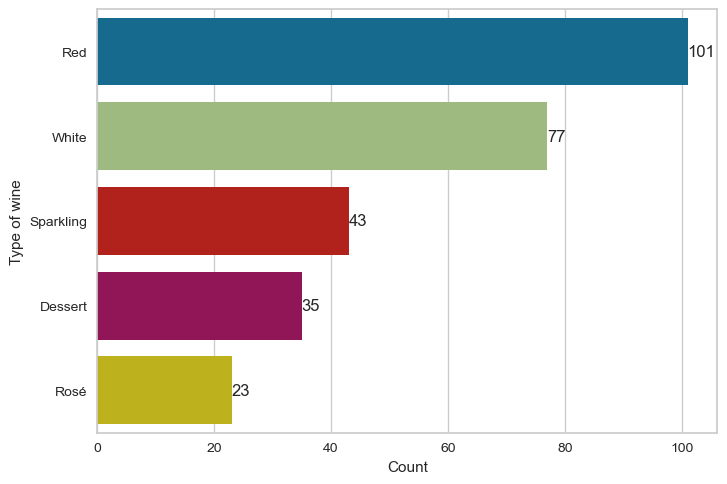

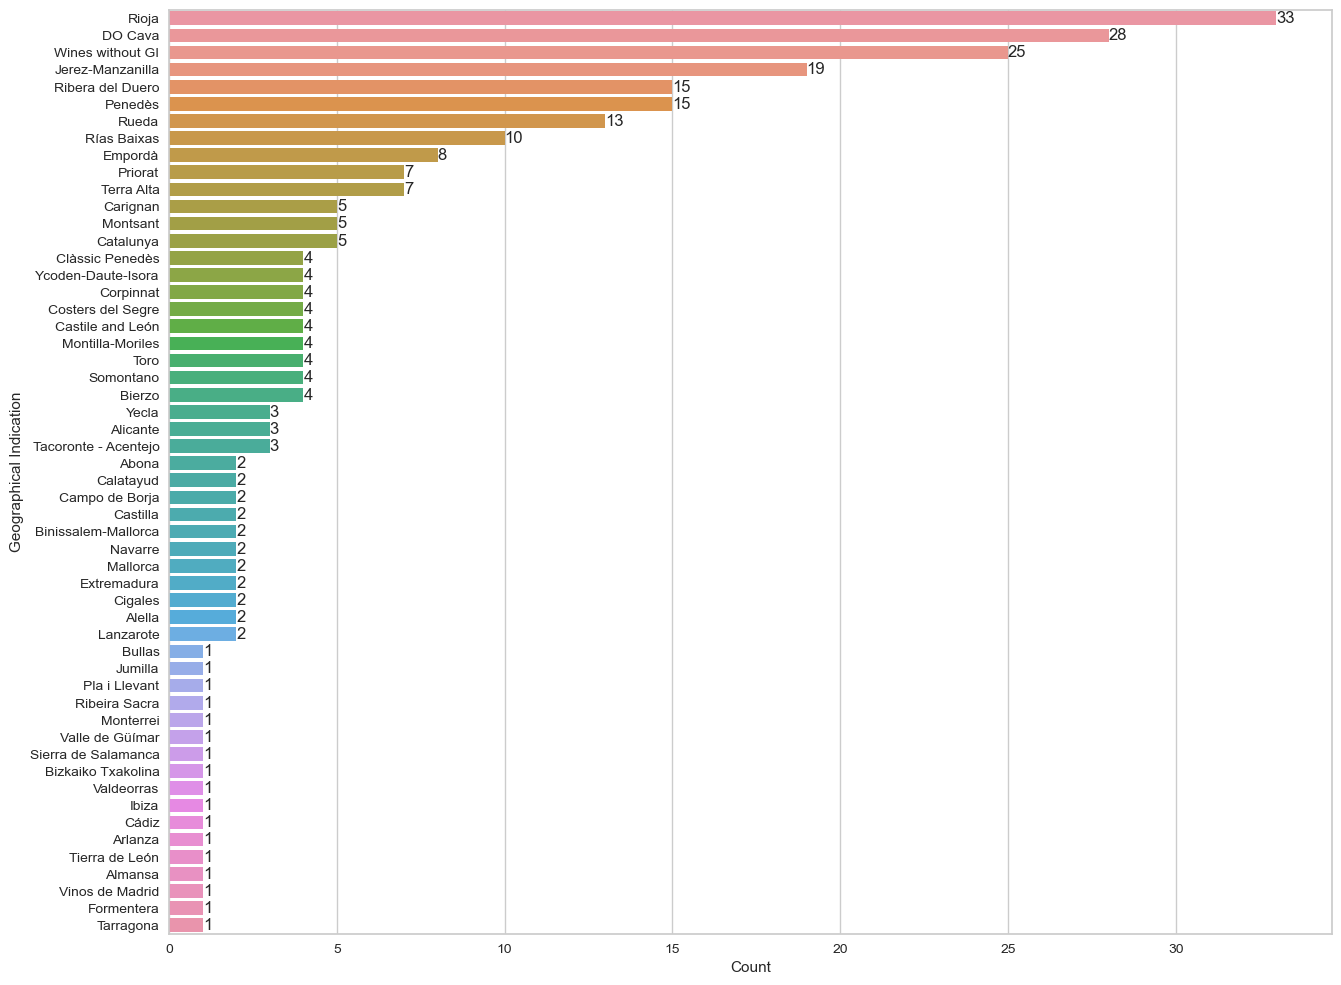

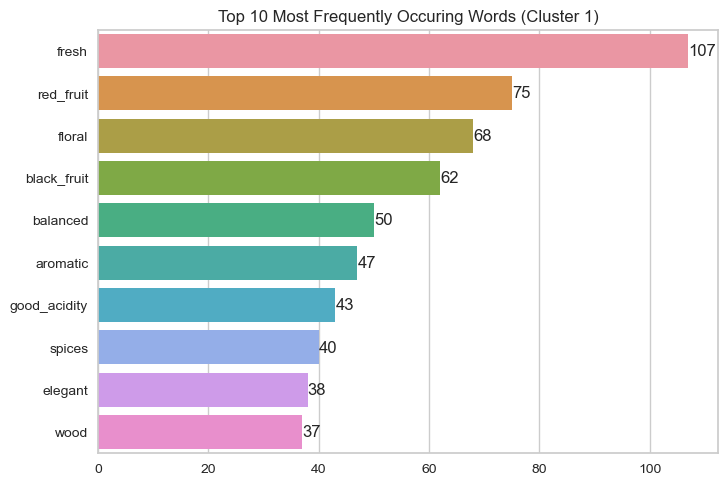

CLUSTER 2
The size of this cluster is 492 wines


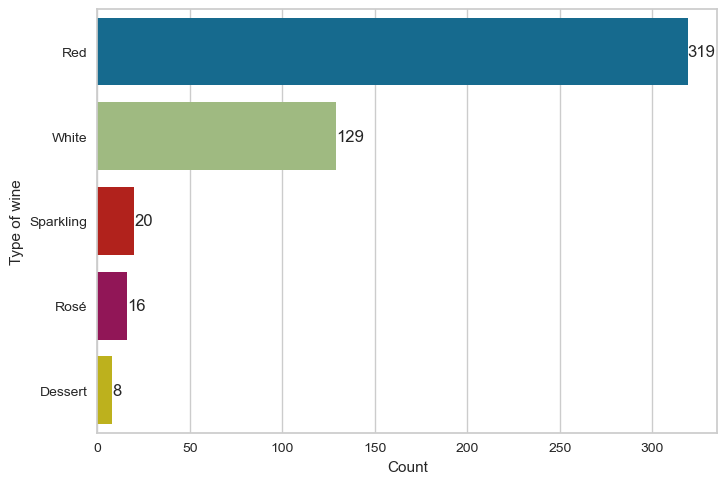

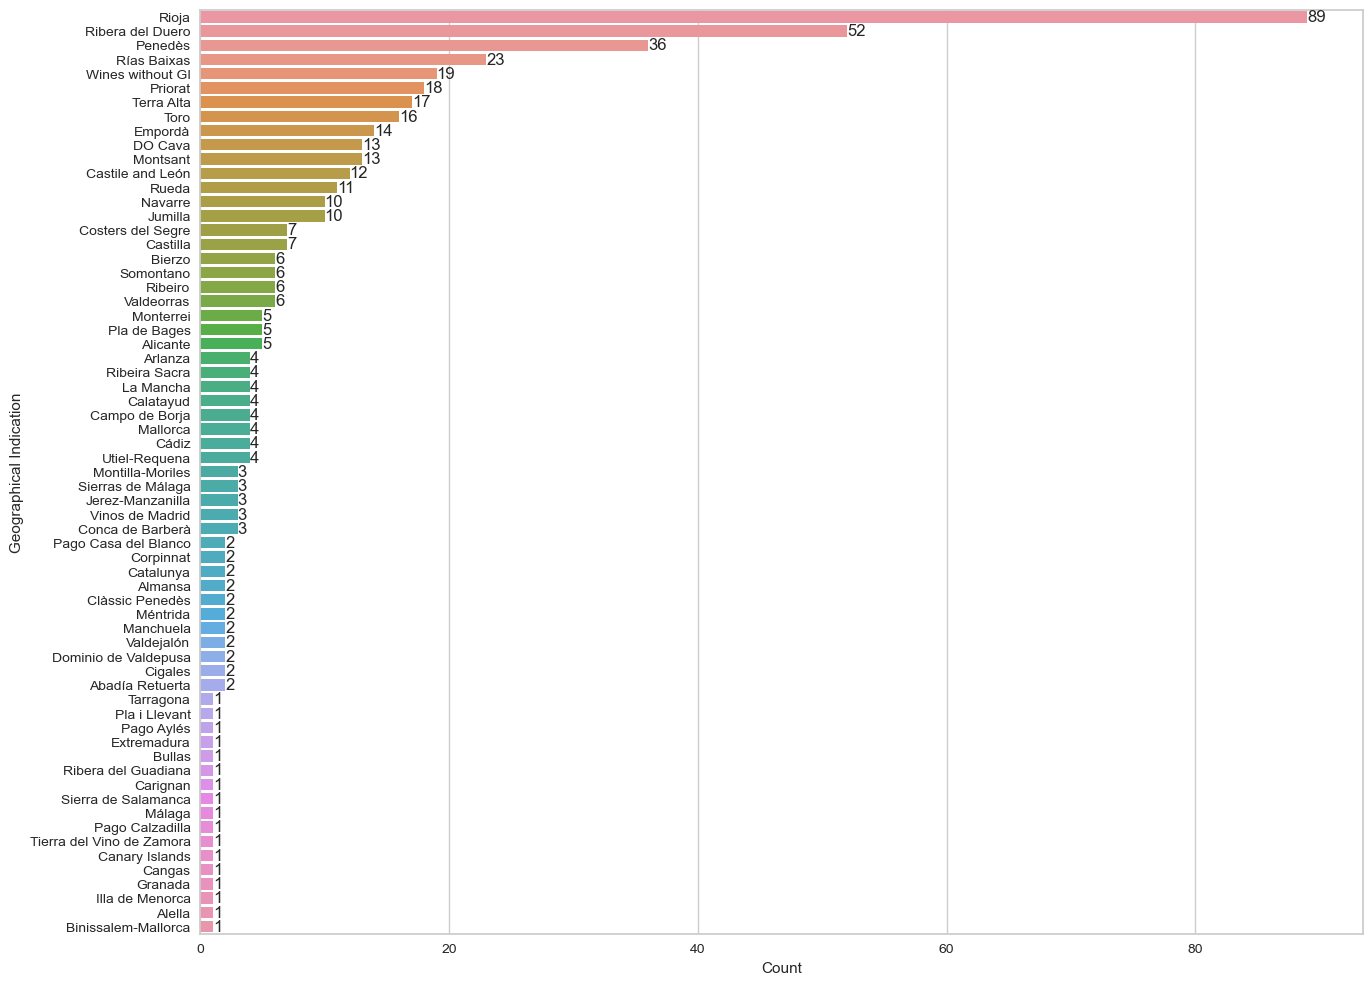

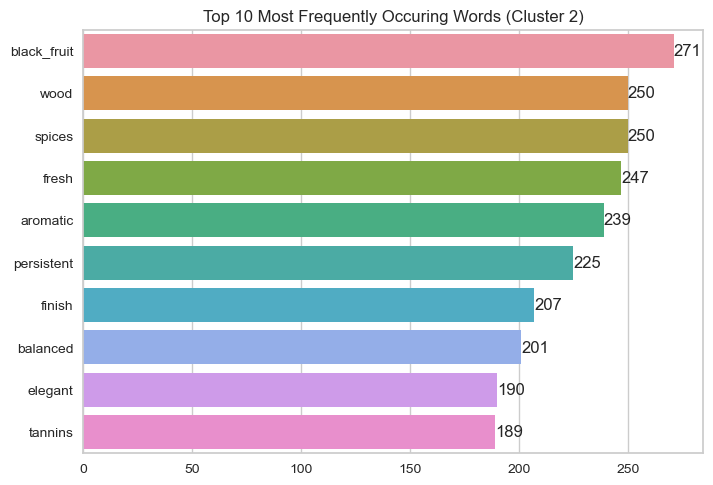

CLUSTER 3
The size of this cluster is 20 wines


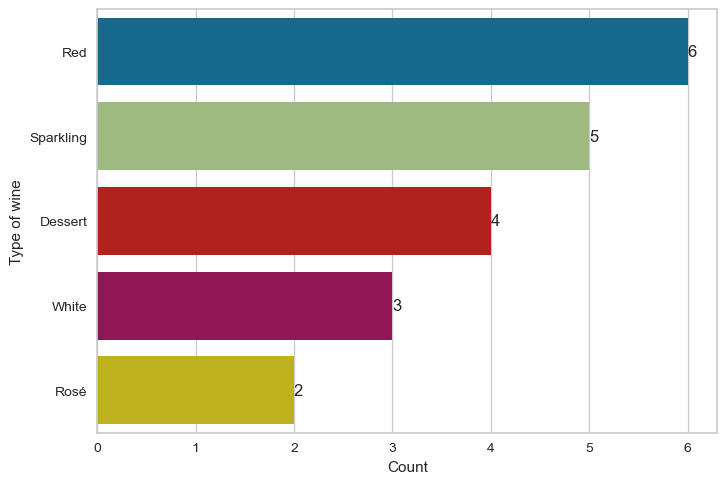

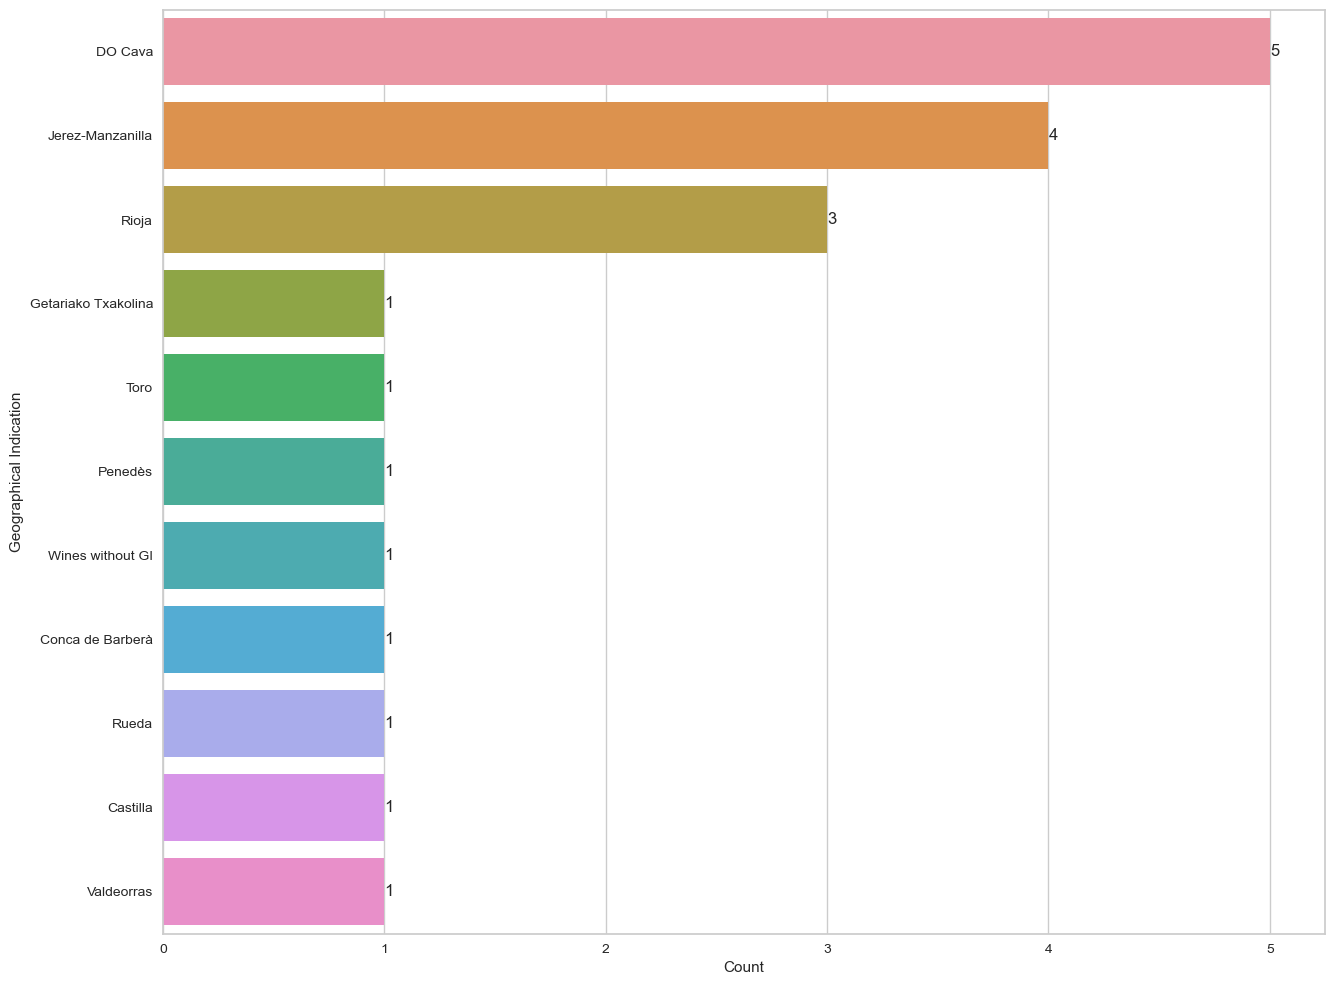

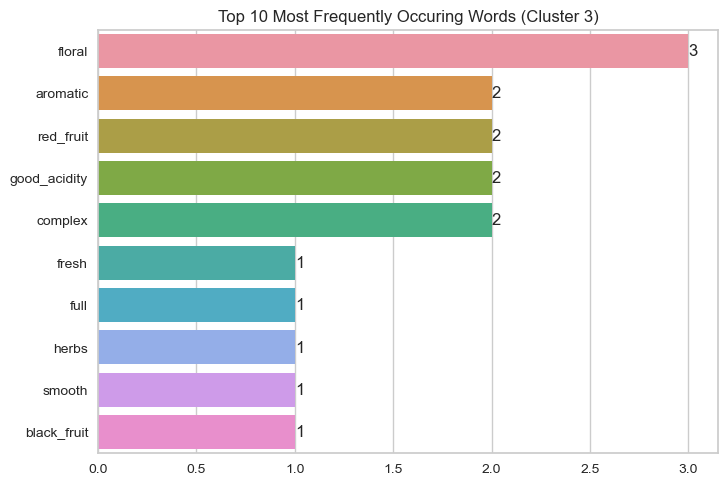

CLUSTER 4
The size of this cluster is 55 wines


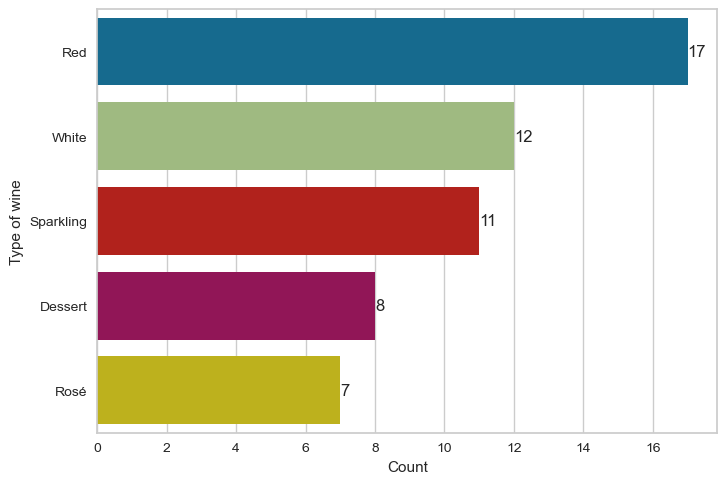

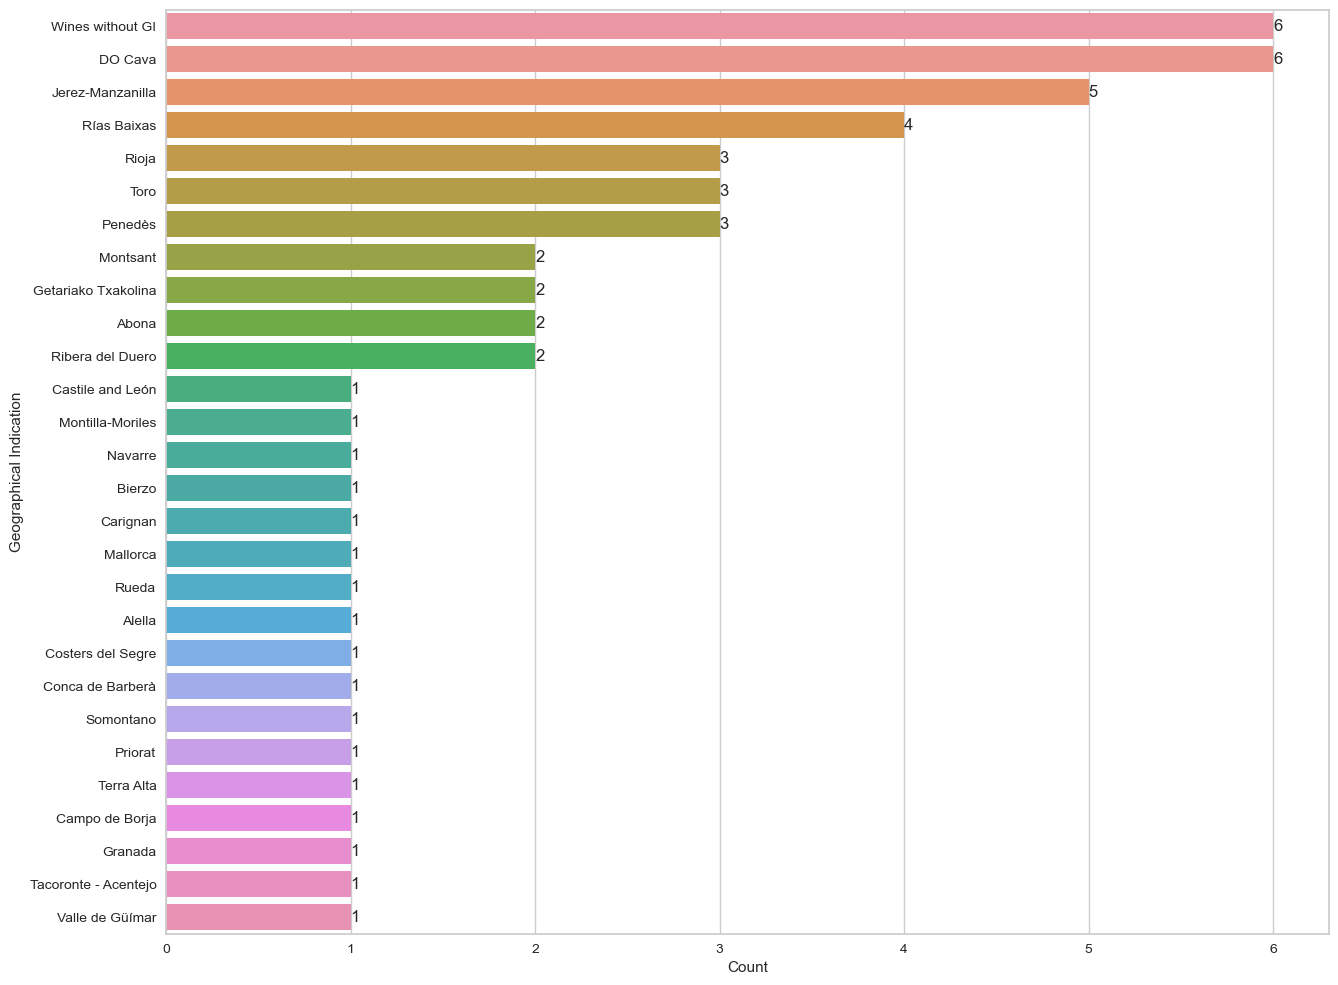

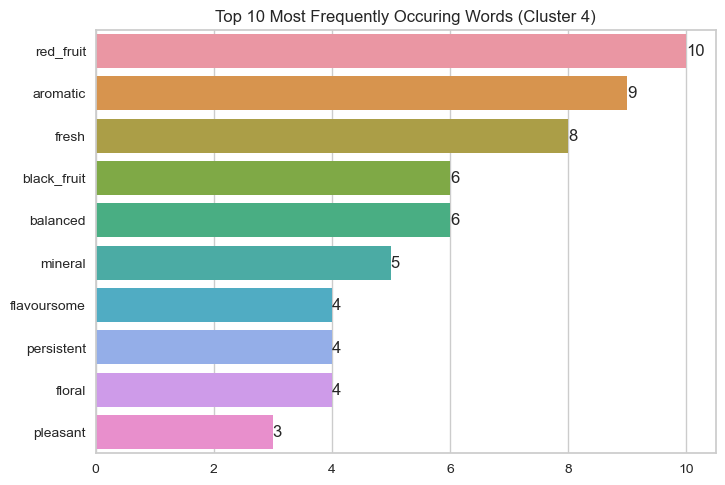

CLUSTER 5
The size of this cluster is 472 wines


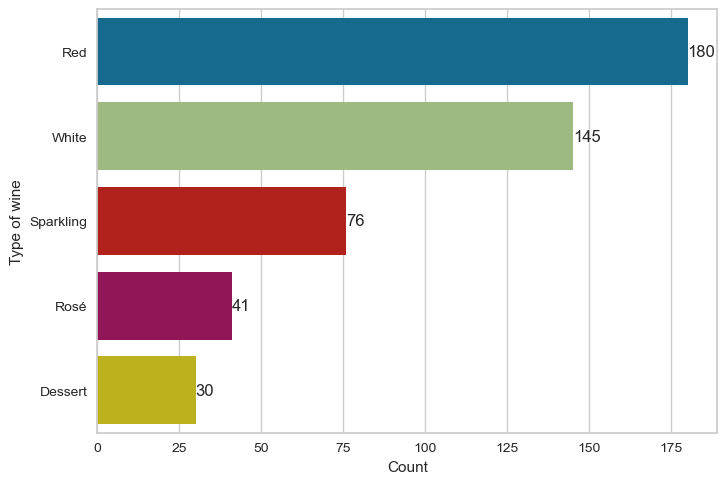

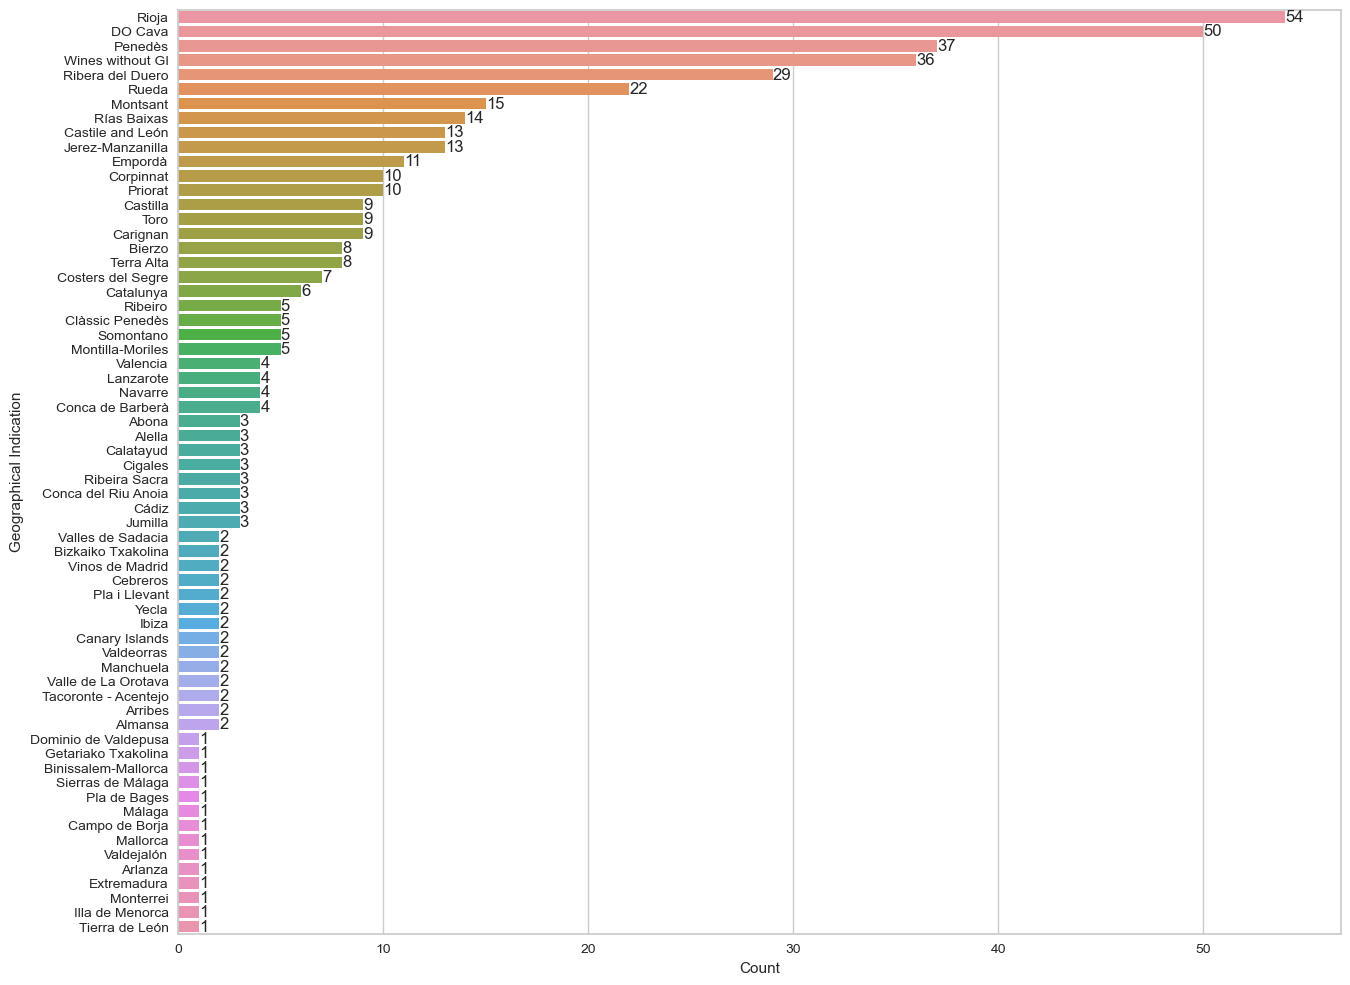

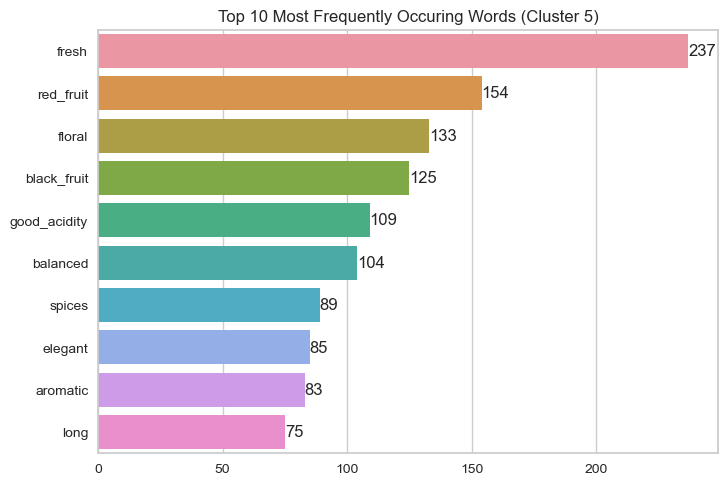

CLUSTER 6
The size of this cluster is 140 wines


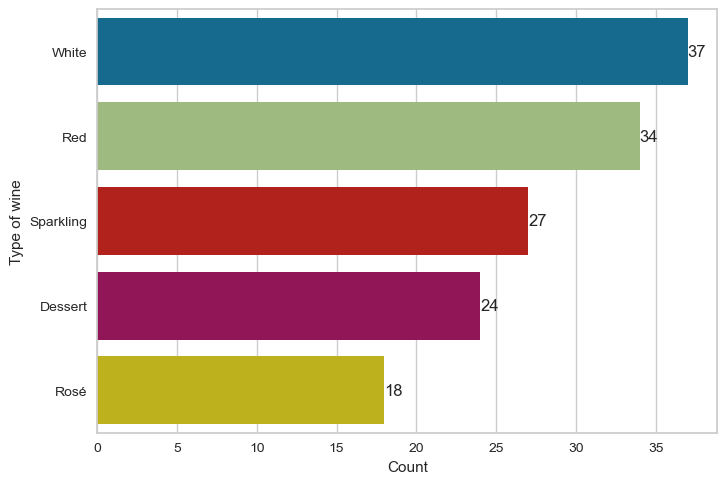

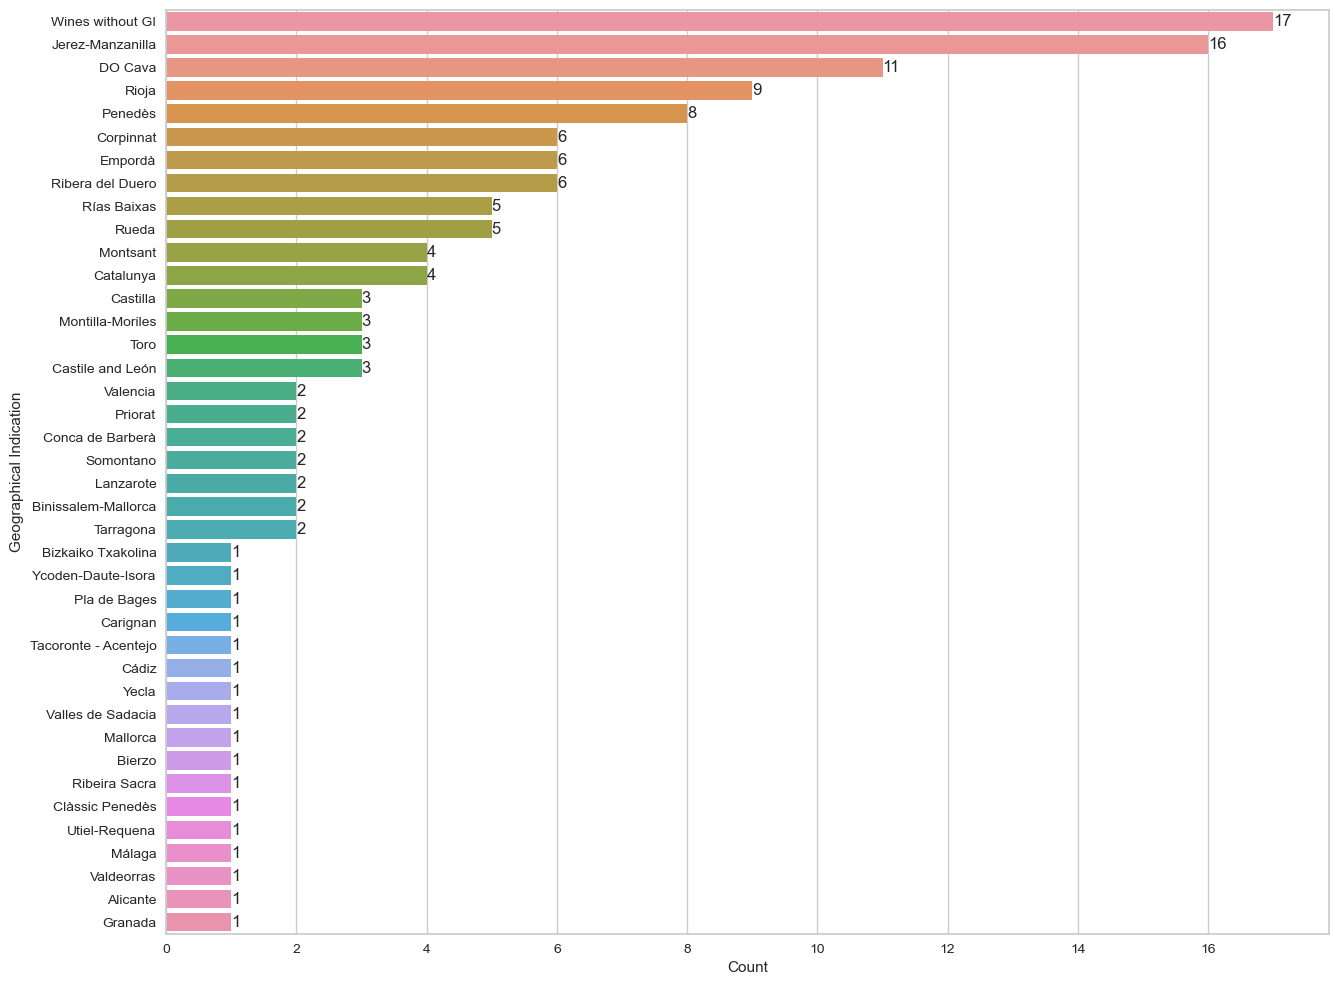

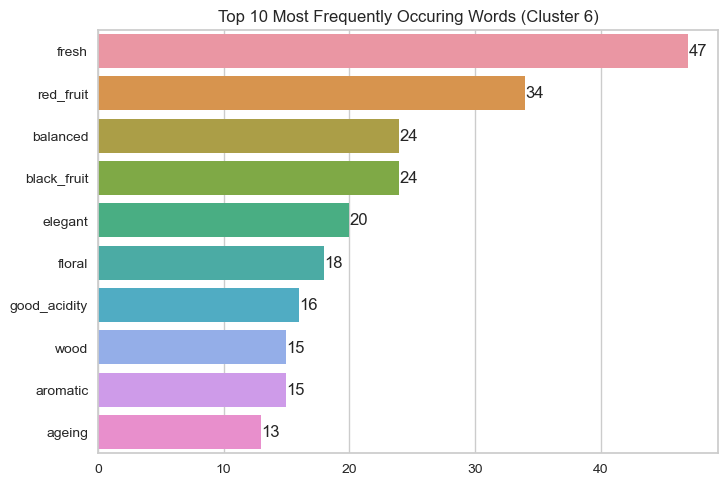

CLUSTER 7
The size of this cluster is 416 wines


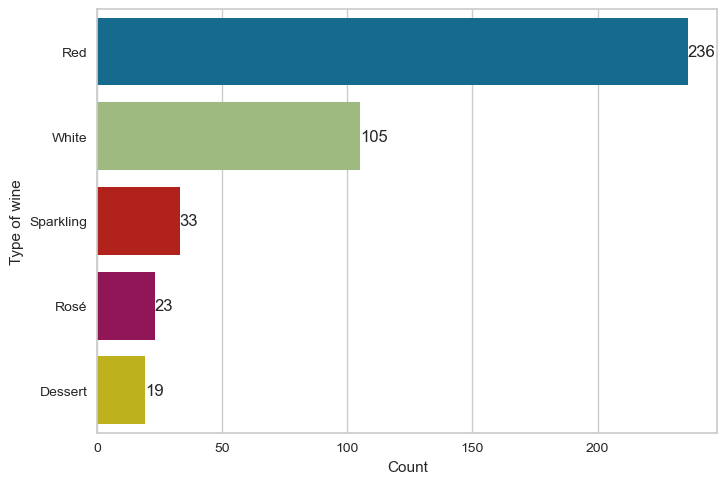

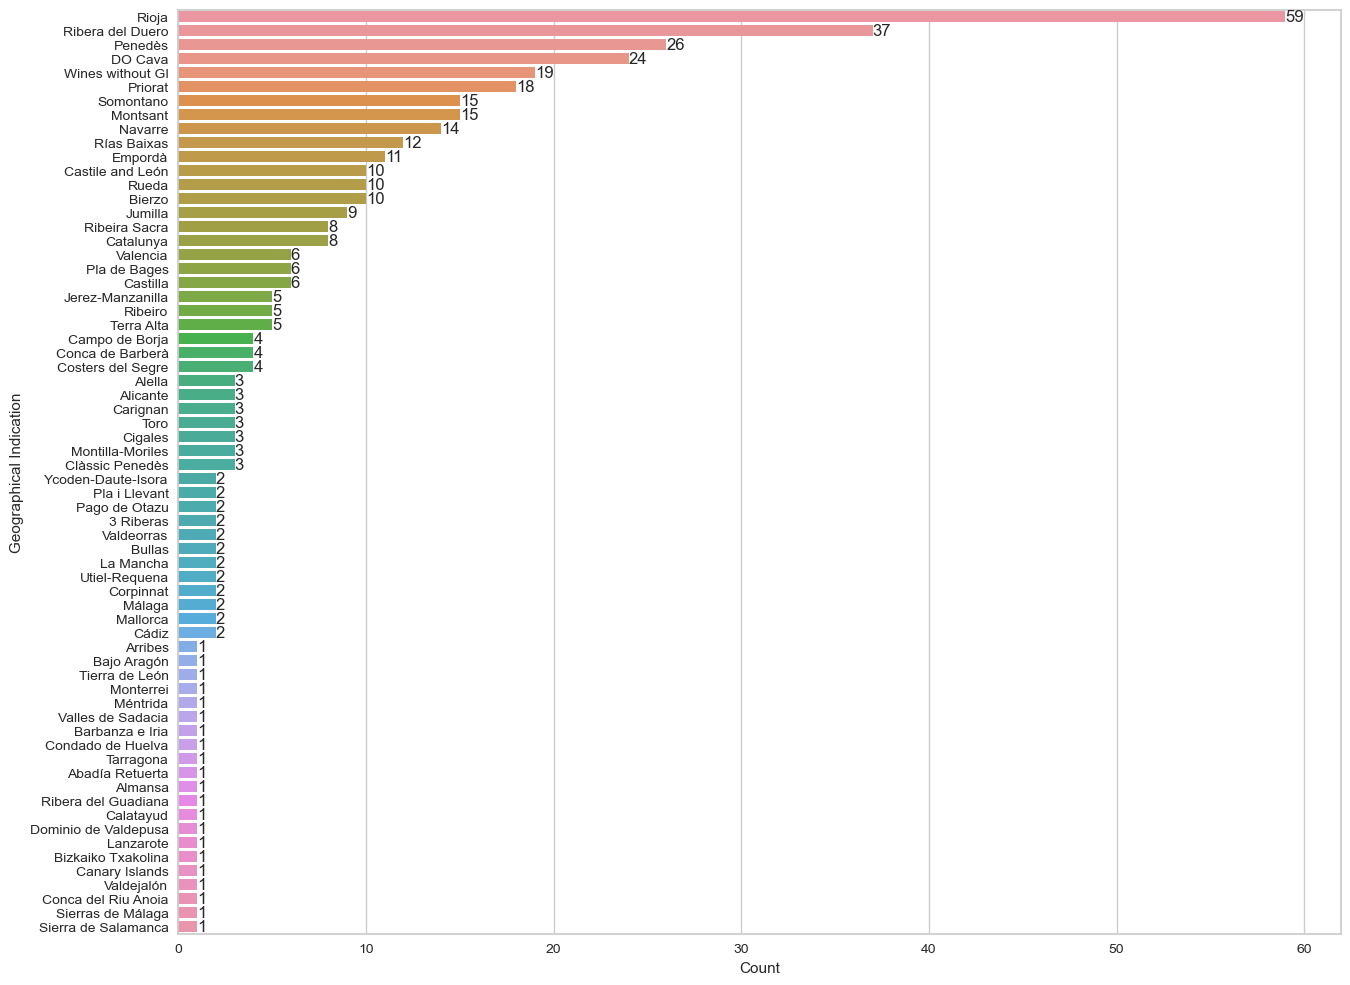

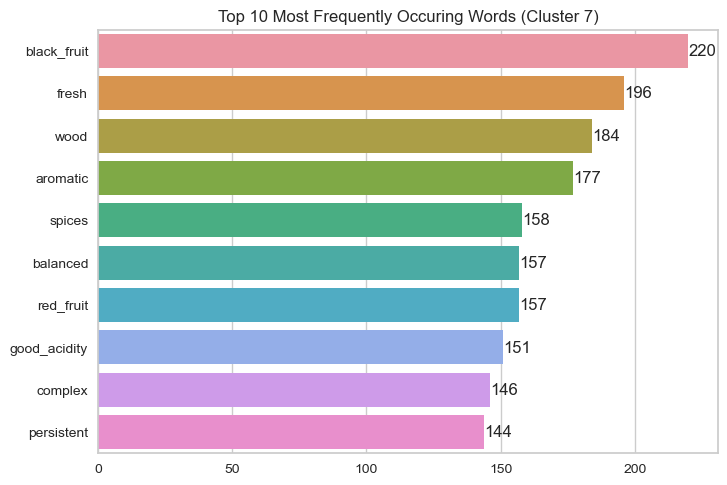

CLUSTER 8
The size of this cluster is 555 wines


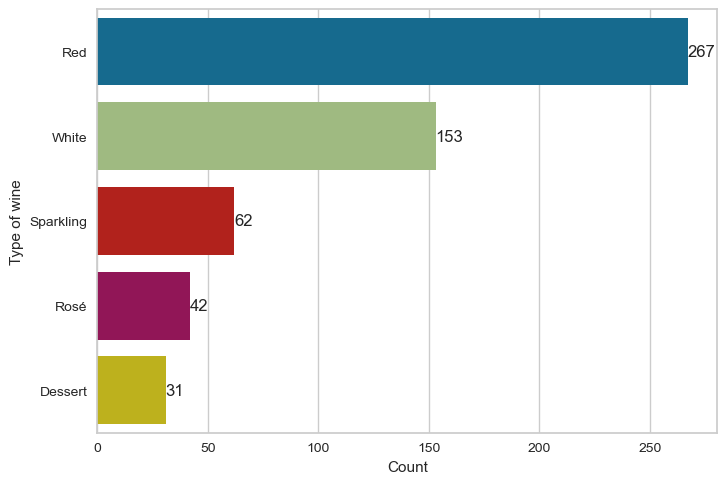

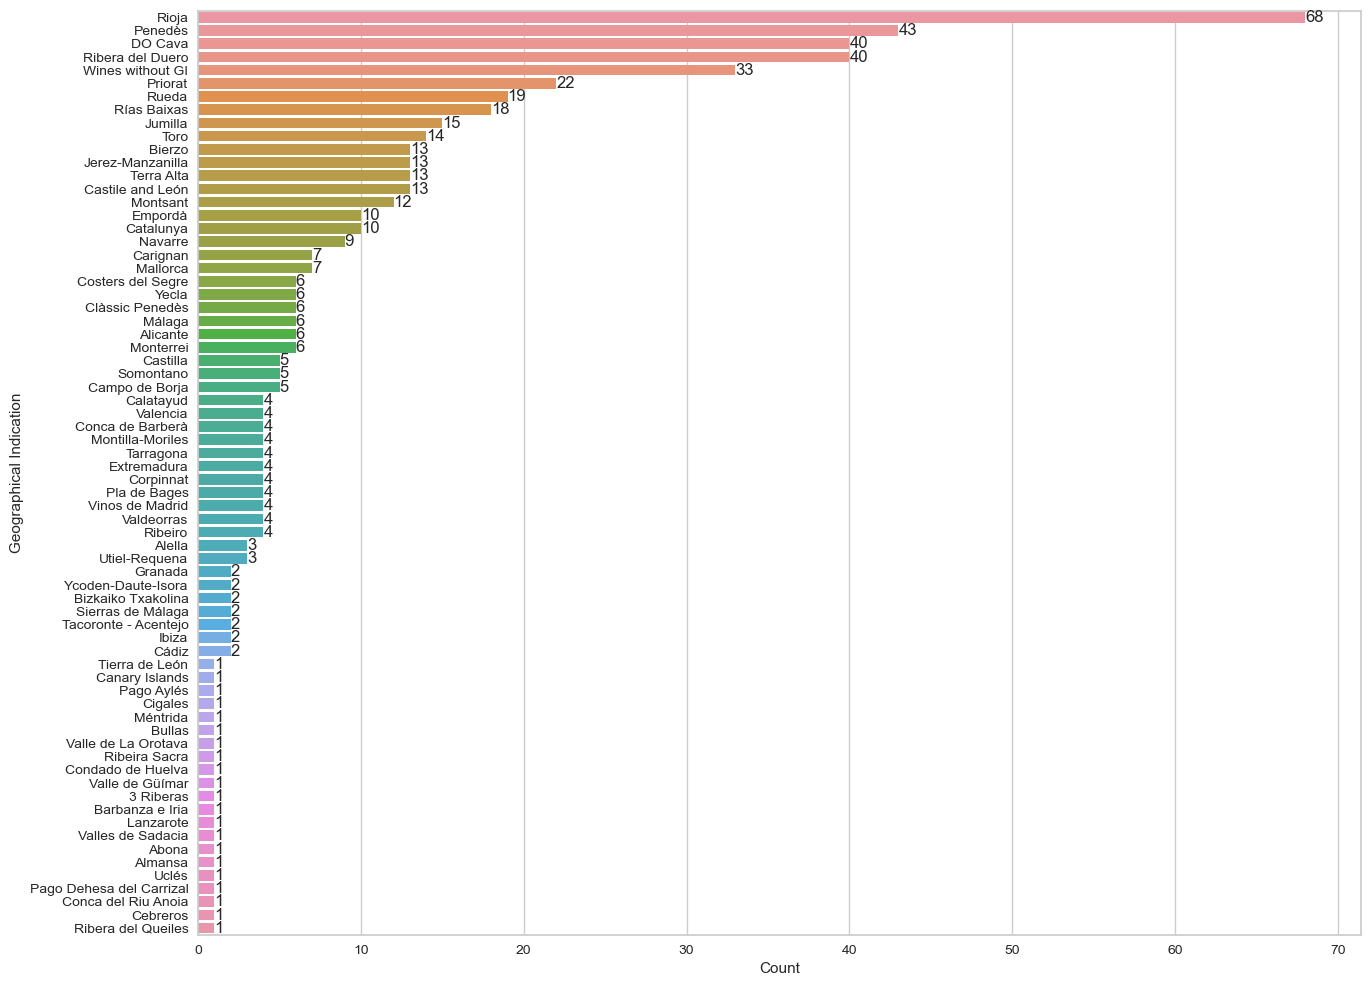

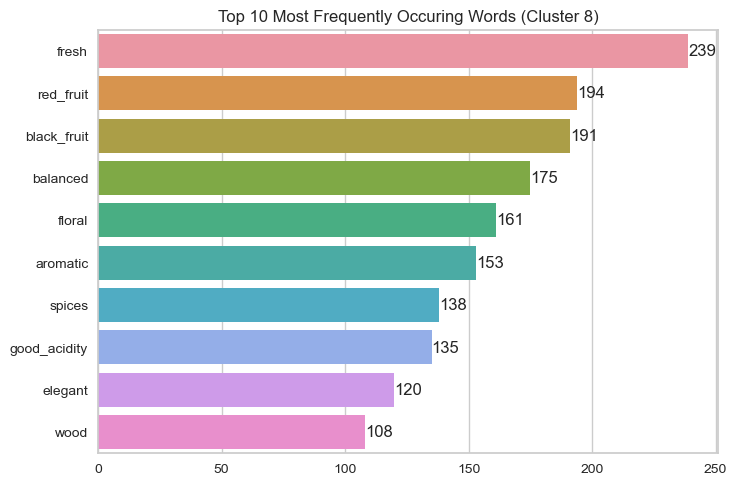

CLUSTER 9
The size of this cluster is 317 wines


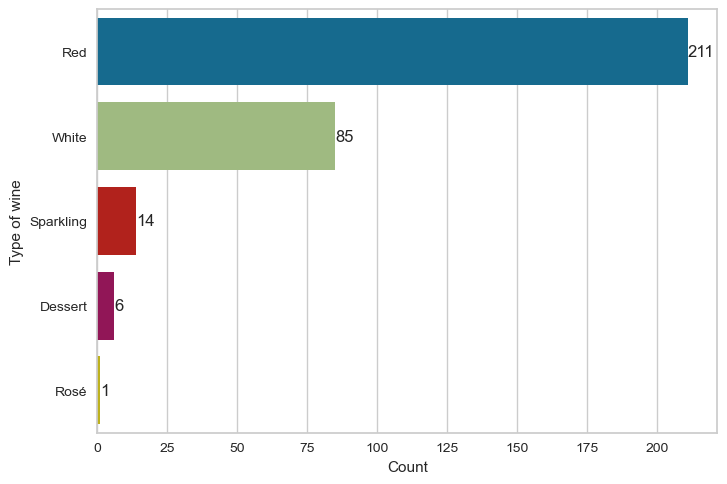

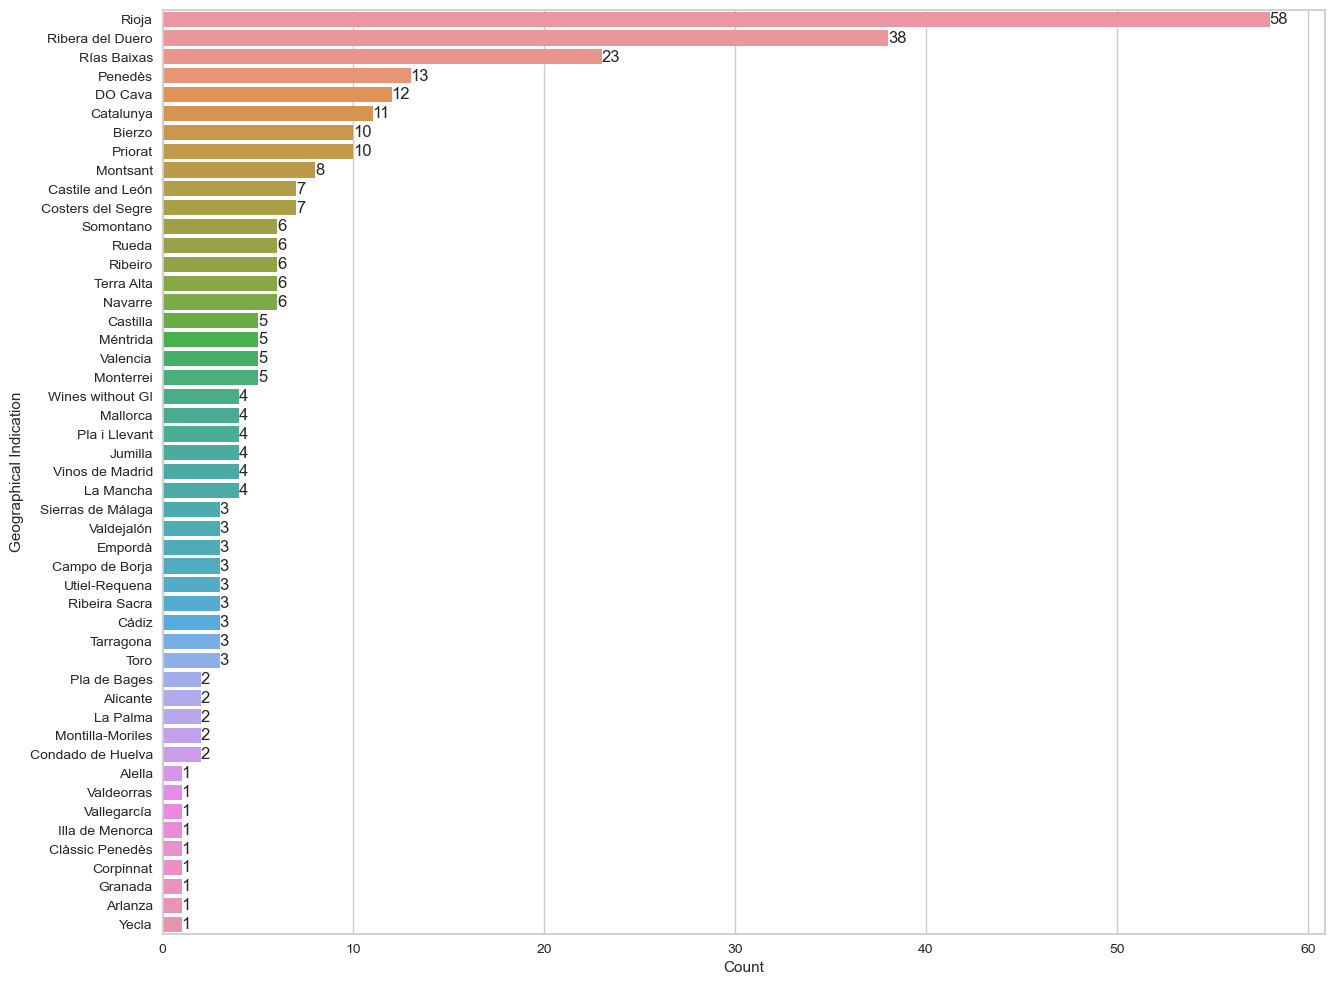

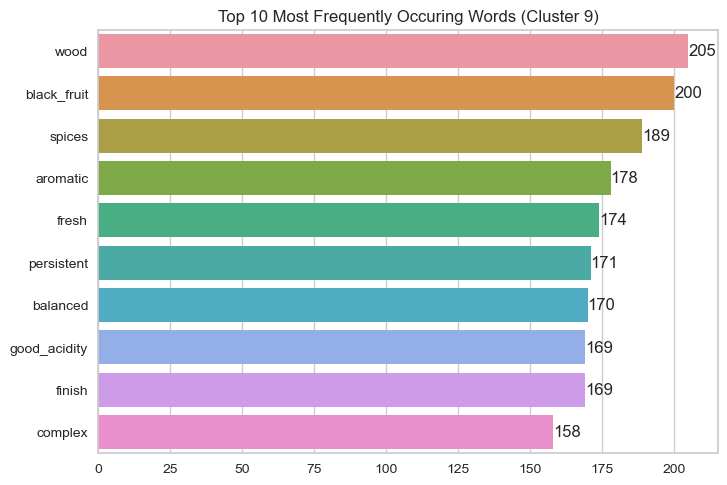

CLUSTER 10
The size of this cluster is 477 wines


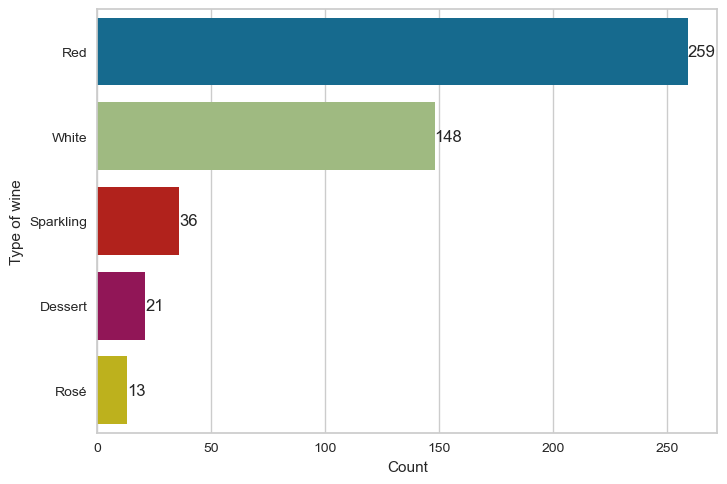

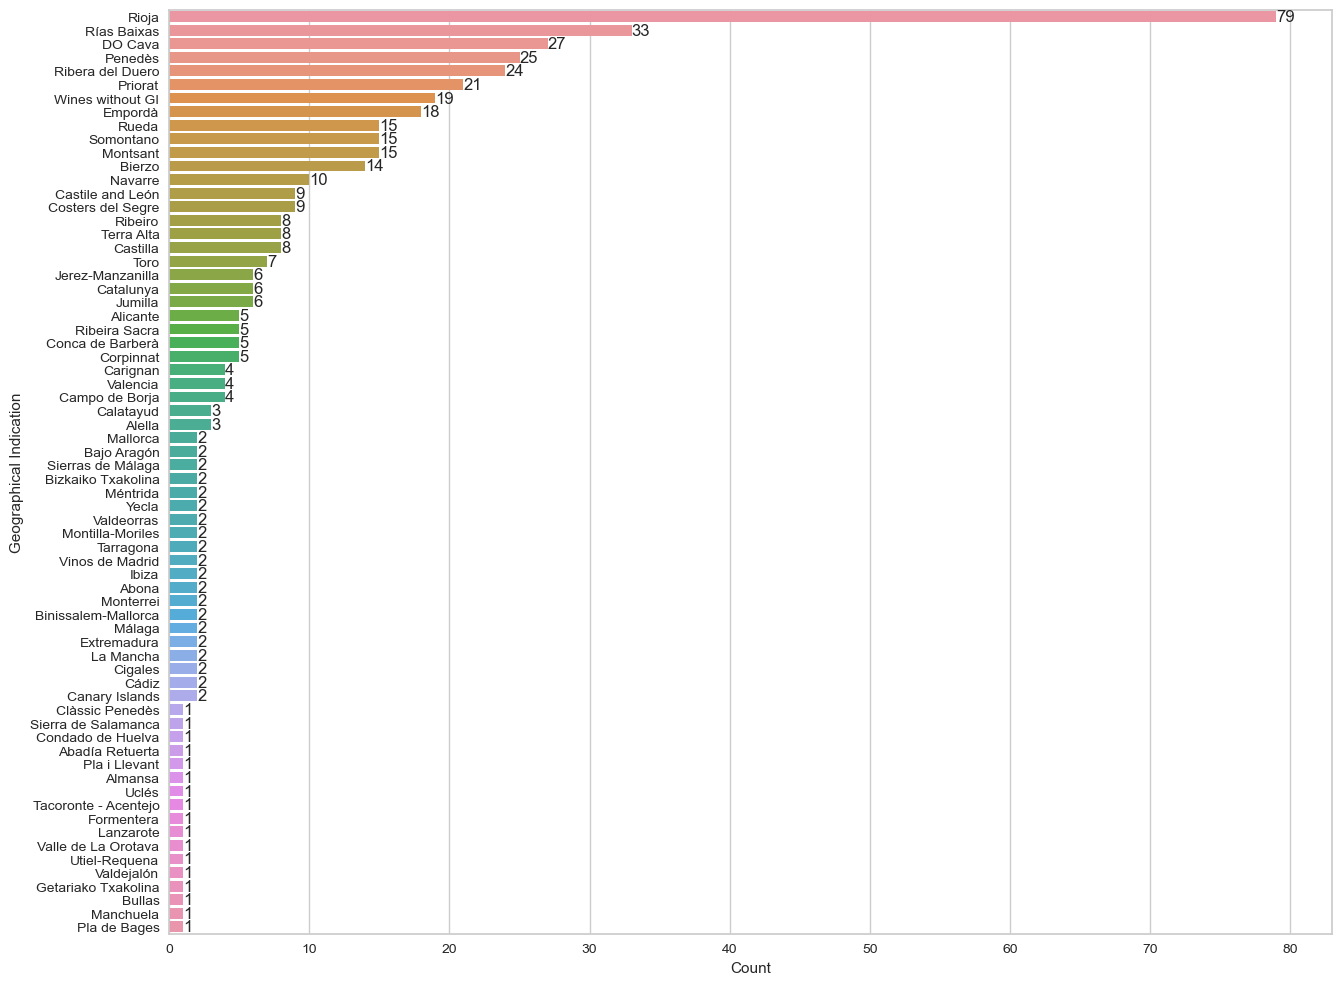

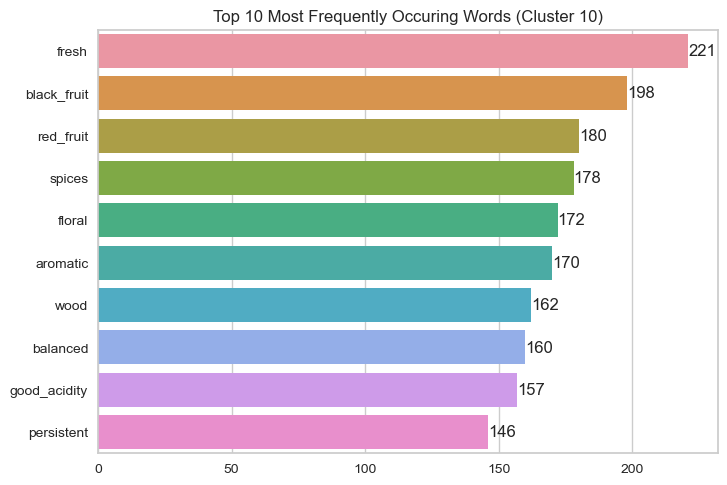

In [124]:
for cluster in range(0,11):
    explore_clusters(text_data, "notes_norm_removed_new_reduction_dropped", "cluster11", cluster)

In [126]:
text_data[text_data["cluster11"]==3]

wine    year  \
30                             Rioja Bordón Blanco 2022  2022.0   
282                            Txomin Etxaniz Rosé 2021  2021.0   
625                                    Viore Tinto 2021  2021.0   
912                              Atrium Chardonnay 2022  2022.0   
1211       Canals & Munné Dionysus Brut Nature Eco 2020  2020.0   
1391                                     Corriente 2020  2020.0   
1392                             Fino Quinta de Osborne     NaN   
1434                        Montsant Artesà Brut Nature     NaN   
1477                             Tío Pepe Fino Muy Seco     NaN   
1644                  Naterra Rosé 2020 (Bag in box 3L)     NaN   
1802        Bertha Cardús Brut Nature Gran Reserva 2018  2018.0   
2050                    Clos Montblanc Merlot Únic 2018  2018.0   
2490                 González Byass Leonor Palo Cortado     NaN   
2678  Lustau Almacenista Oloroso Pata de Gallina (0....     NaN   
2843           ADN Canals Brut Nature Gran Reserva 2014  2014.0   
3262              Martivillí Fermentado En Barrica 2018  2018.0   
3390             Tutusaus Gran Reserva Brut Nature 2017  2017.0   
3400                     Hello World Prieto Picudo 2017  2017.0   
3548                                        Tineta 2012  2012.0   
3690                     Lar de Paula Cepas Viejas 2005  2005.0   

                                    winery  \
30                Bodegas Franco Españolas   
282                         Txomin Etxaniz   
625                       Bodegas Riojanas   
912               Propiedad Bodegas Torres   
1211                        Canals & Munné   
1391  Compañía de Vinos de Telmo Rodríguez   
1392                               Osborne   
1434                       Caves Monastell   
1477                        González Byass   
1644                       Maison Ginestet   
1802                           Cava Bertha   
2050                        Clos Montblanc   
2490                        González Byass   
2678                         Emilio Lustau   
2843                        Canals & Munné   
3262                 Angel Lorenzo Cachazo   
3390                            Valldolina   
3400                     Finca La Estacada   
3548                       Bodegas Ordóñez   
3690                          Lar de Paula   

                               winery_norm  price  bottle  type_wine  \
30                        franco espanolas   9.95    0.75      White   
282                         txomin etxaniz  16.20    0.75       Rosé   
625                               riojanas   9.60    0.75        Red   
912                       propiedad torres  14.60    0.75      White   
1211                        canals & munne  14.60    0.75  Sparkling   
1391  compania de vinos de telmo rodriguez  14.00    0.75        Red   
1392                               osborne  12.00    0.75    Dessert   
1434                       caves monastell  11.80    0.75  Sparkling   
1477                        gonzalez byass  12.00    0.75    Dessert   
1644                       maison ginestet  29.20    3.00       Rosé   
1802                           cava bertha  21.00    0.75  Sparkling   
2050                        clos montblanc  14.60    0.75        Red   
2490                        gonzalez byass  35.20     NaN    Dessert   
2678                         emilio lustau  23.15    0.50    Dessert   
2843                        canals & munne  18.40    0.75  Sparkling   
3262                 angel lorenzo cachazo  15.20    0.75      White   
3390                            valldolina  16.50    0.75  Sparkling   
3400                     finca la estacada   9.50    0.75        Red   
3548                               ordonez  14.90    0.75        Red   
3690                          lar de paula  25.55     NaN        Red   

        type_wine_details type_agriculture              region  ...  \
30                  White     Conventional            La Rioja  ...   
282                  

### K=13

In [125]:
text_data["cluster13"].value_counts()

8     593
5     555
10    477
3     472
0     416
11    290
1     279
12    233
9     202
7     140
6      84
2      55
4      20
Name: cluster13, dtype: int64

CLUSTER 0
The size of this cluster is 416 wines


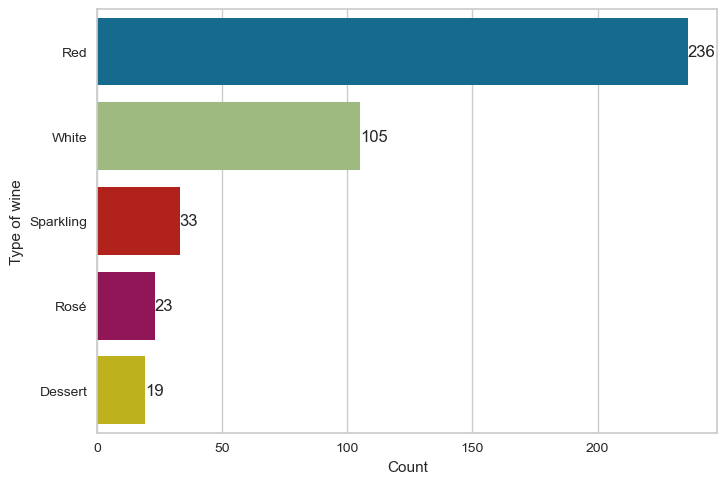

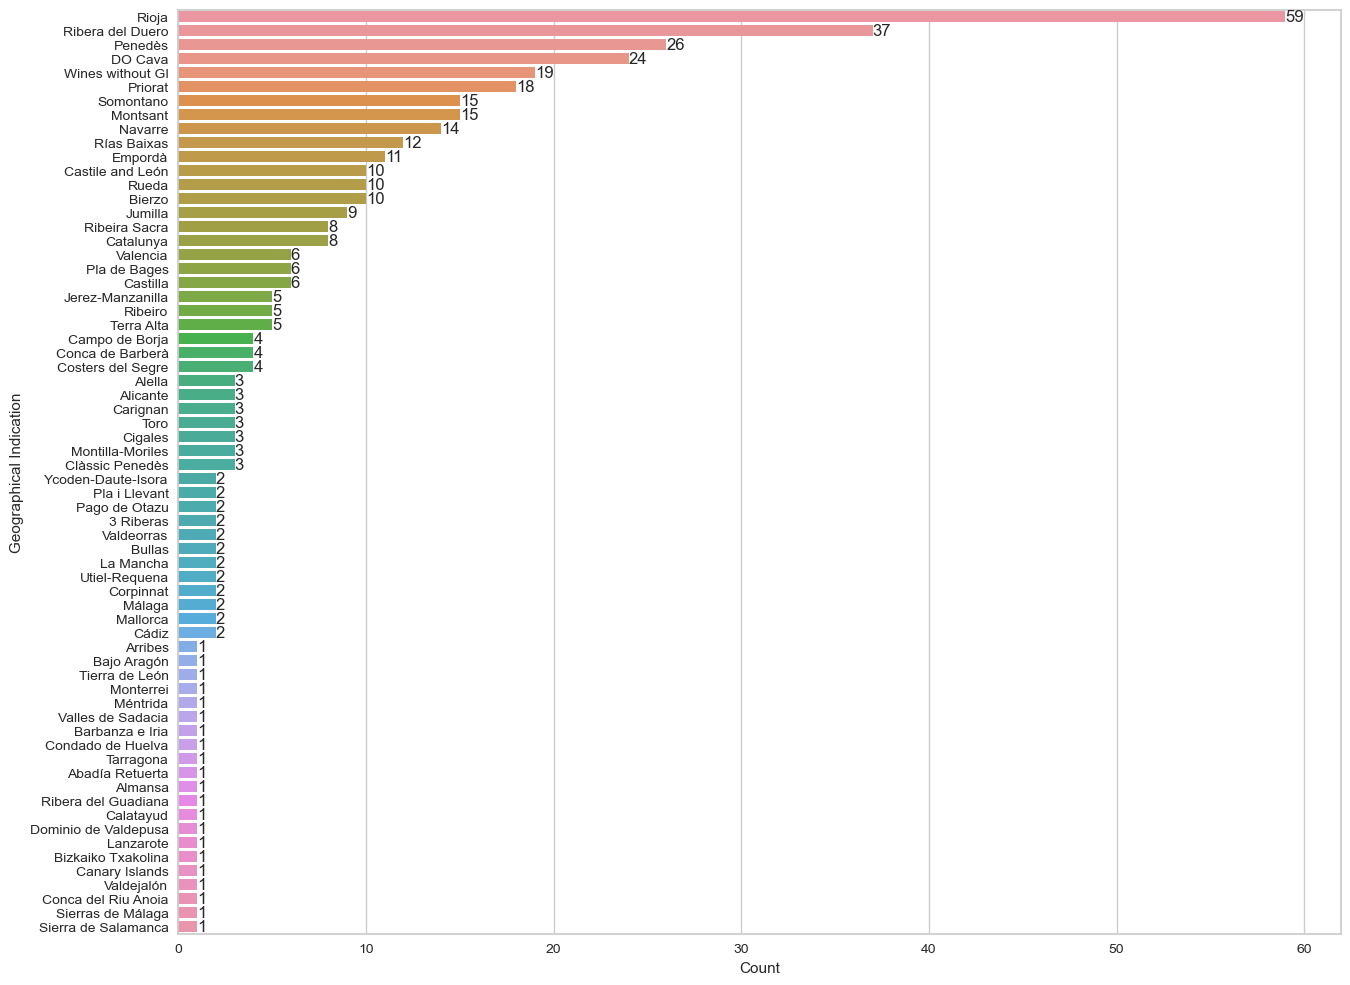

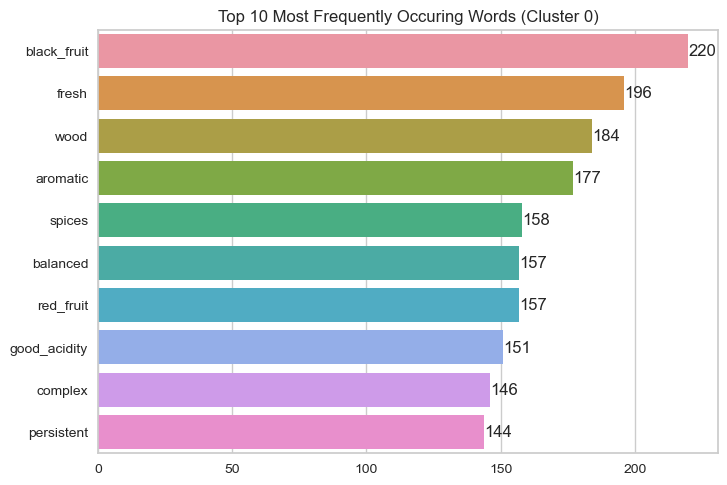

CLUSTER 1
The size of this cluster is 279 wines


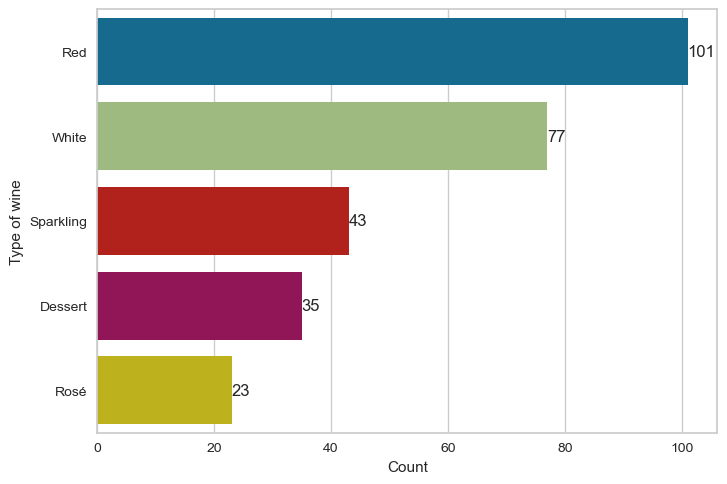

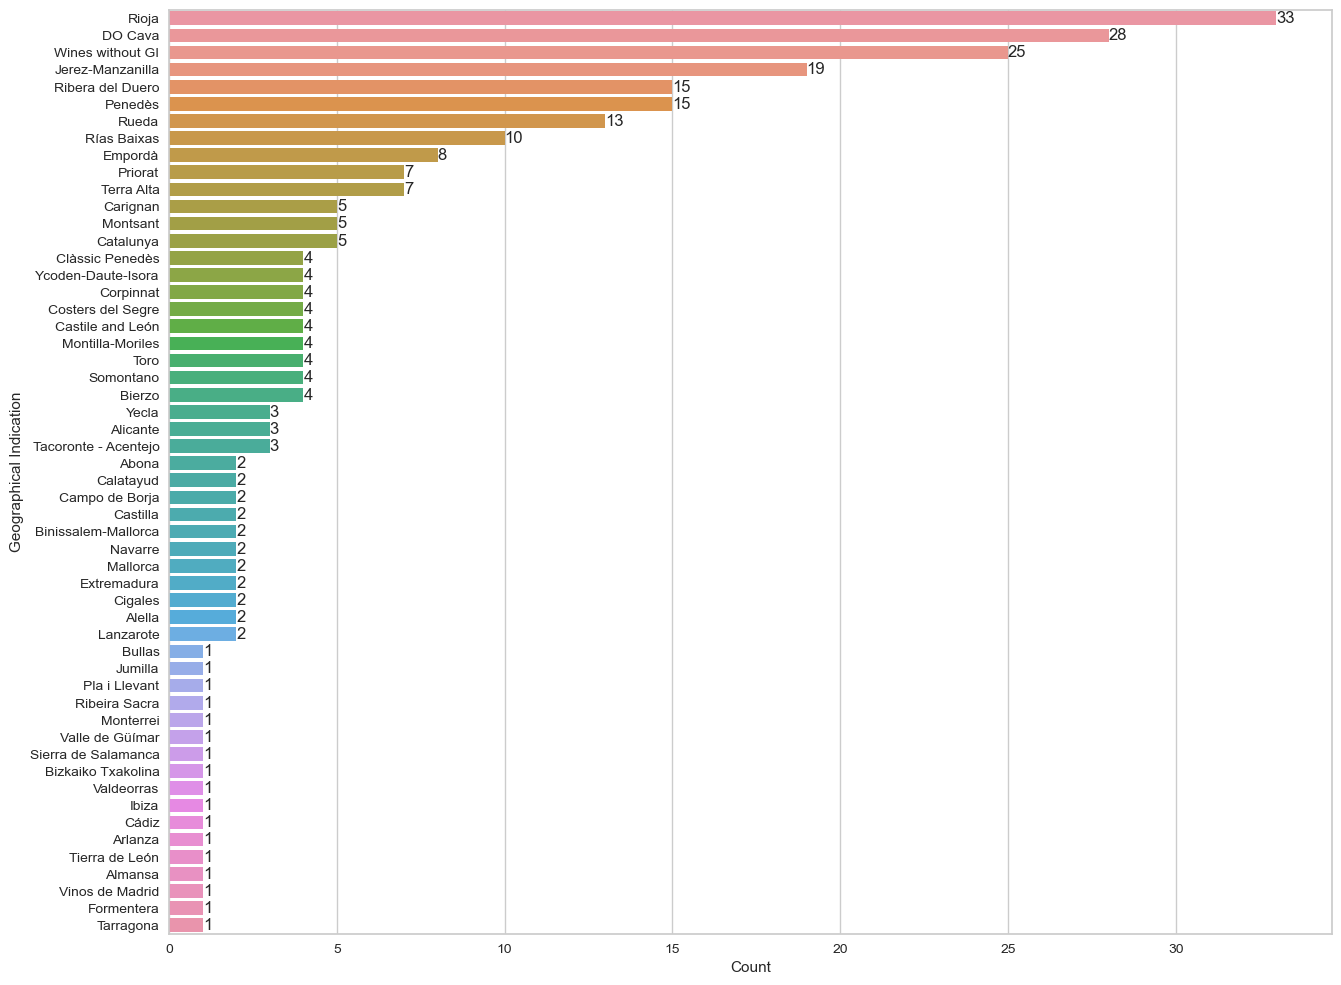

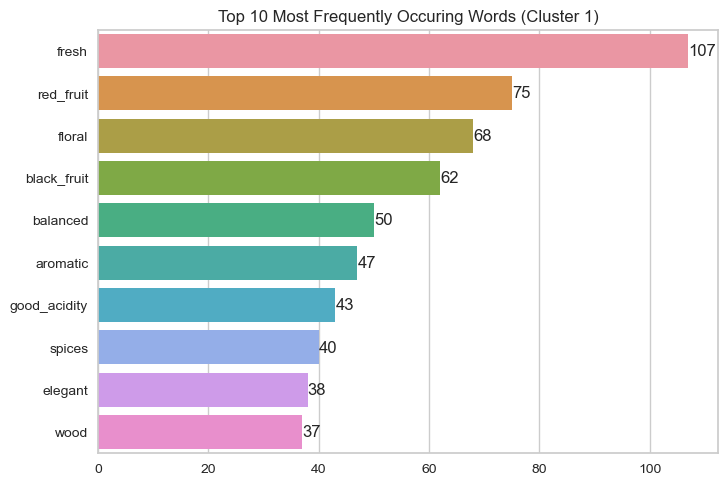

CLUSTER 2
The size of this cluster is 55 wines


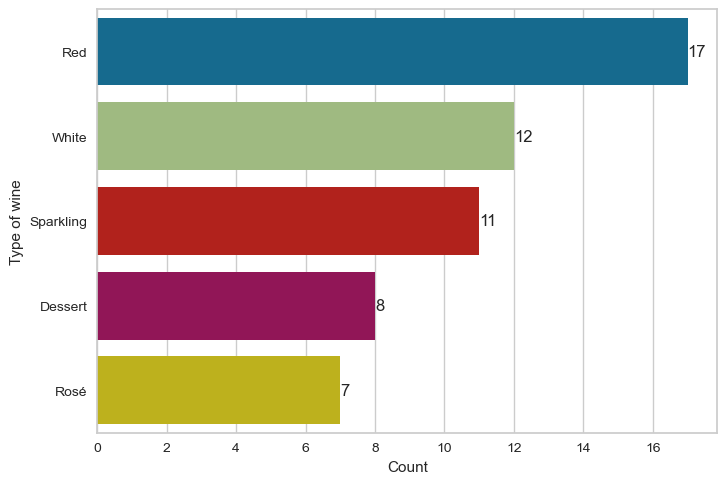

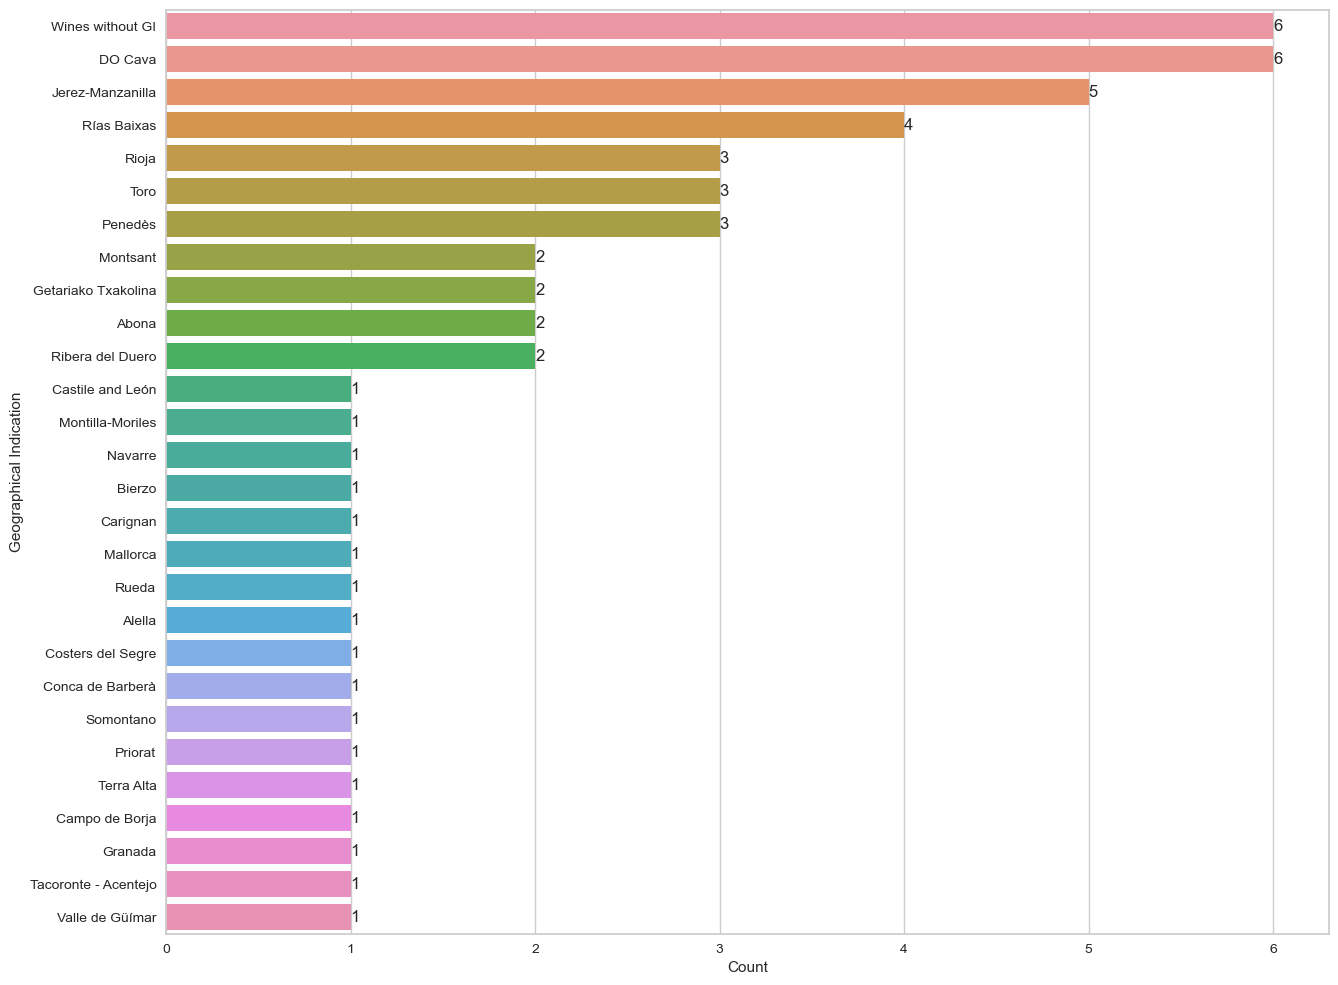

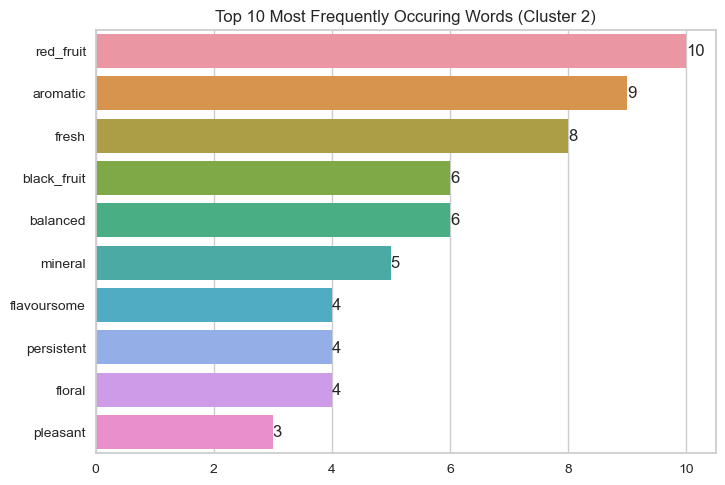

CLUSTER 3
The size of this cluster is 472 wines


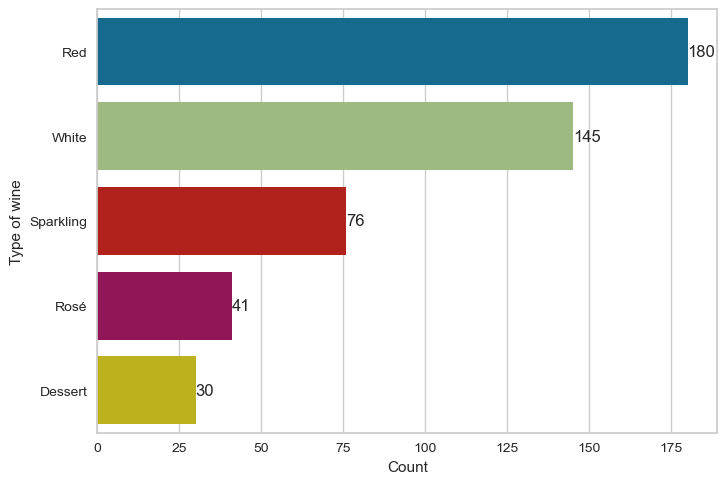

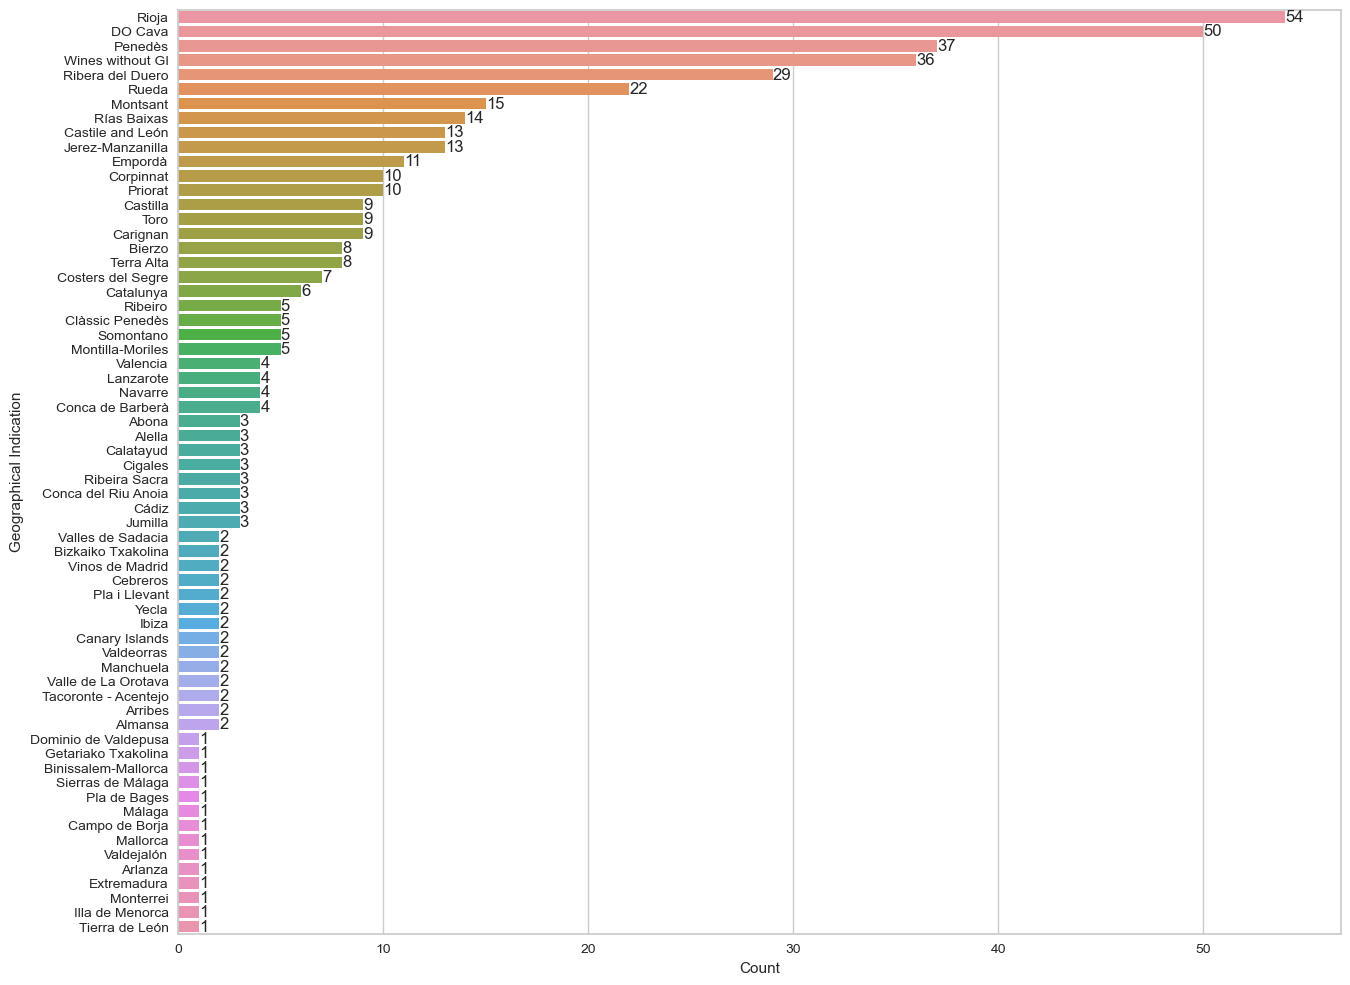

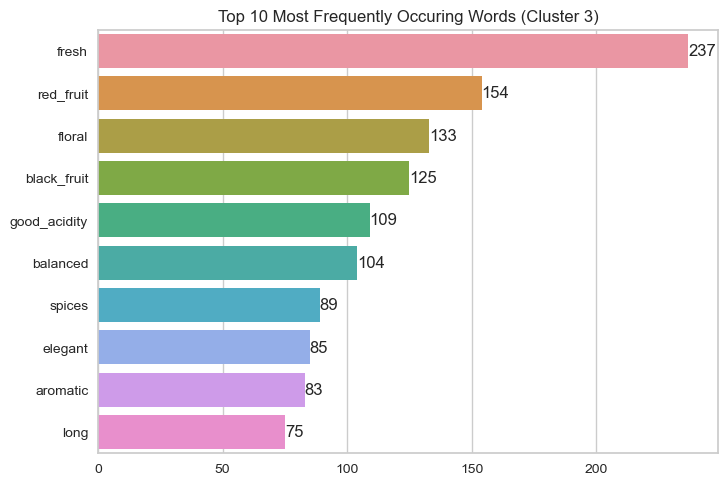

CLUSTER 4
The size of this cluster is 20 wines


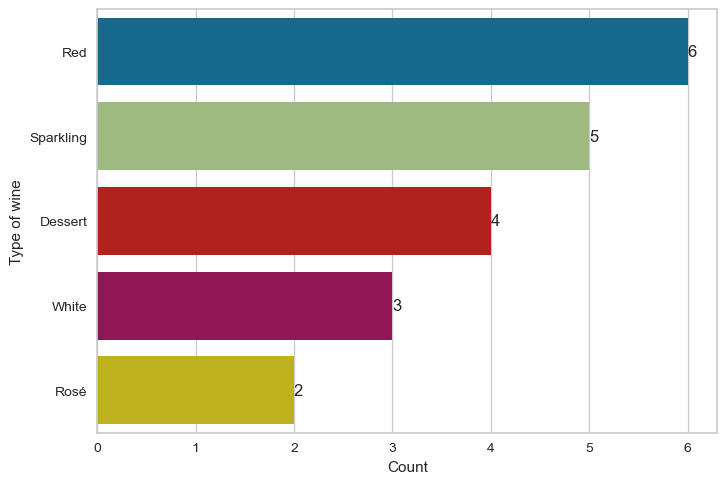

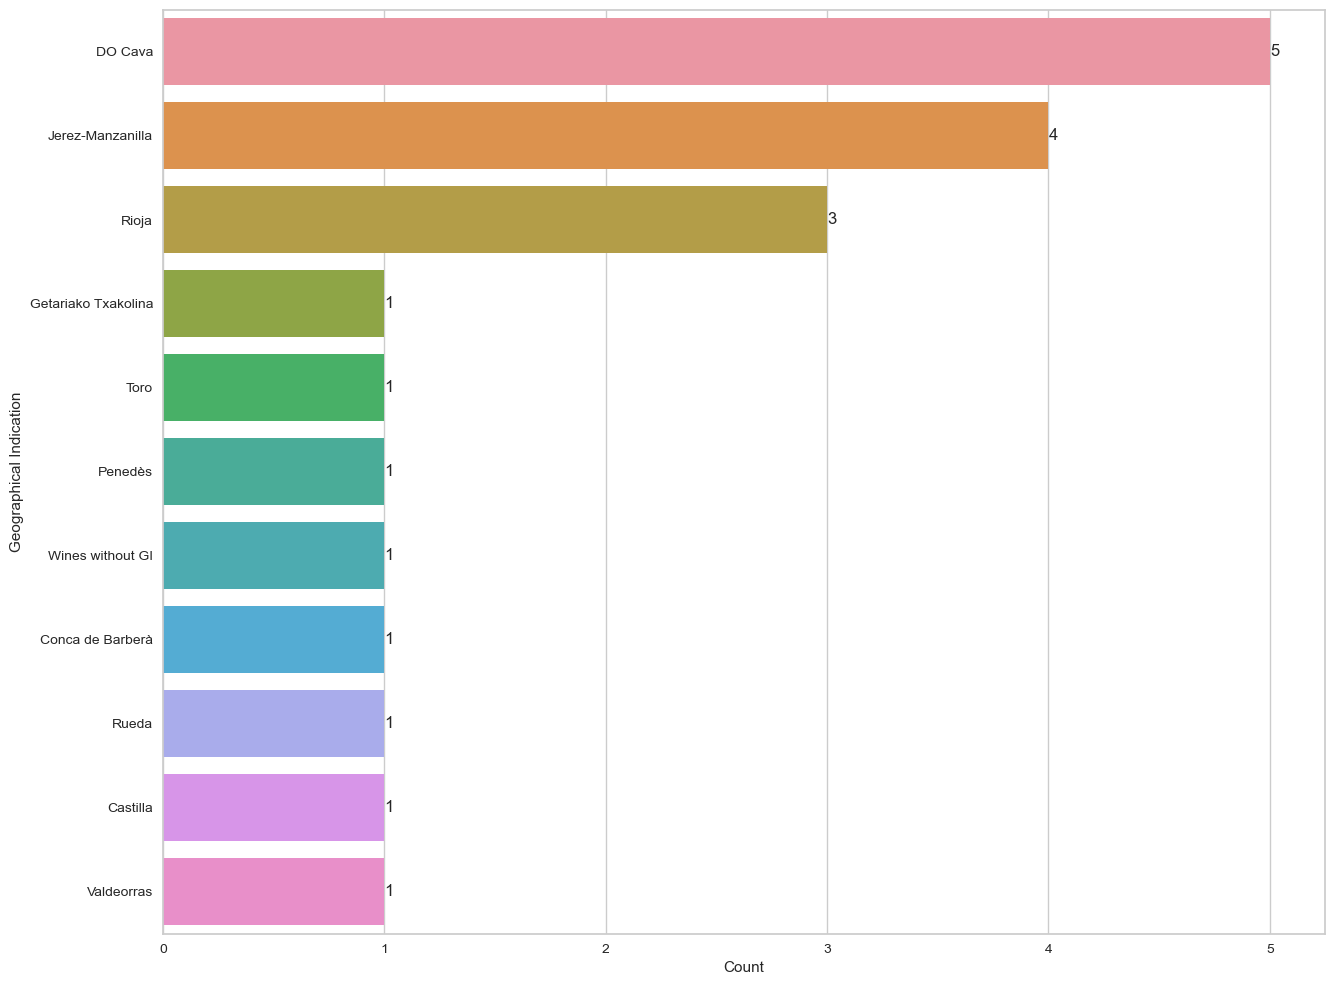

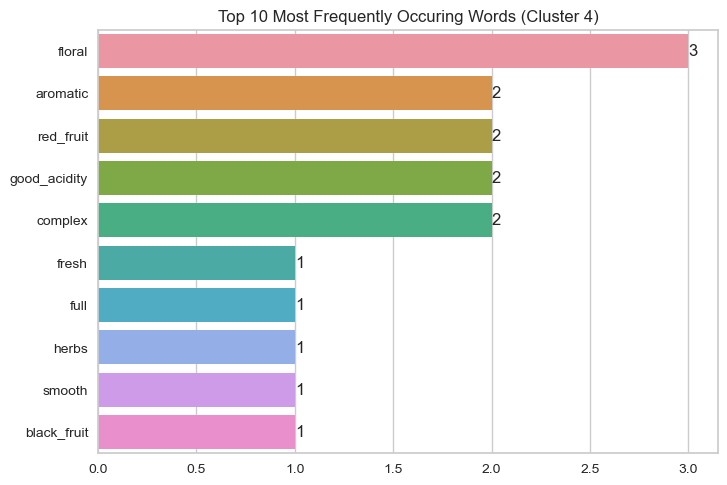

CLUSTER 5
The size of this cluster is 555 wines


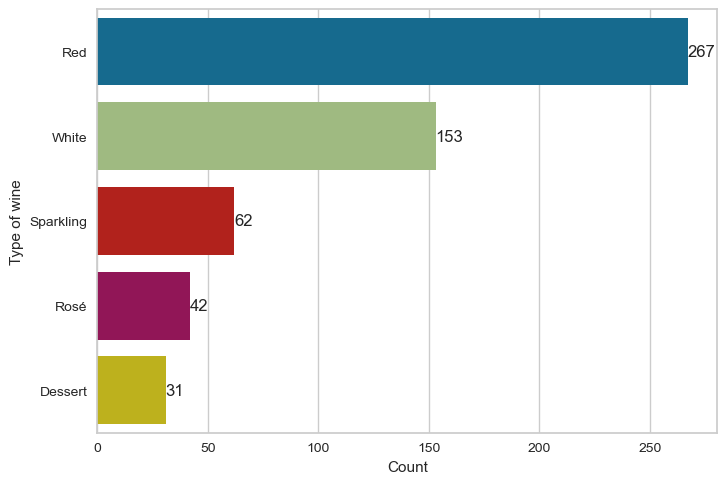

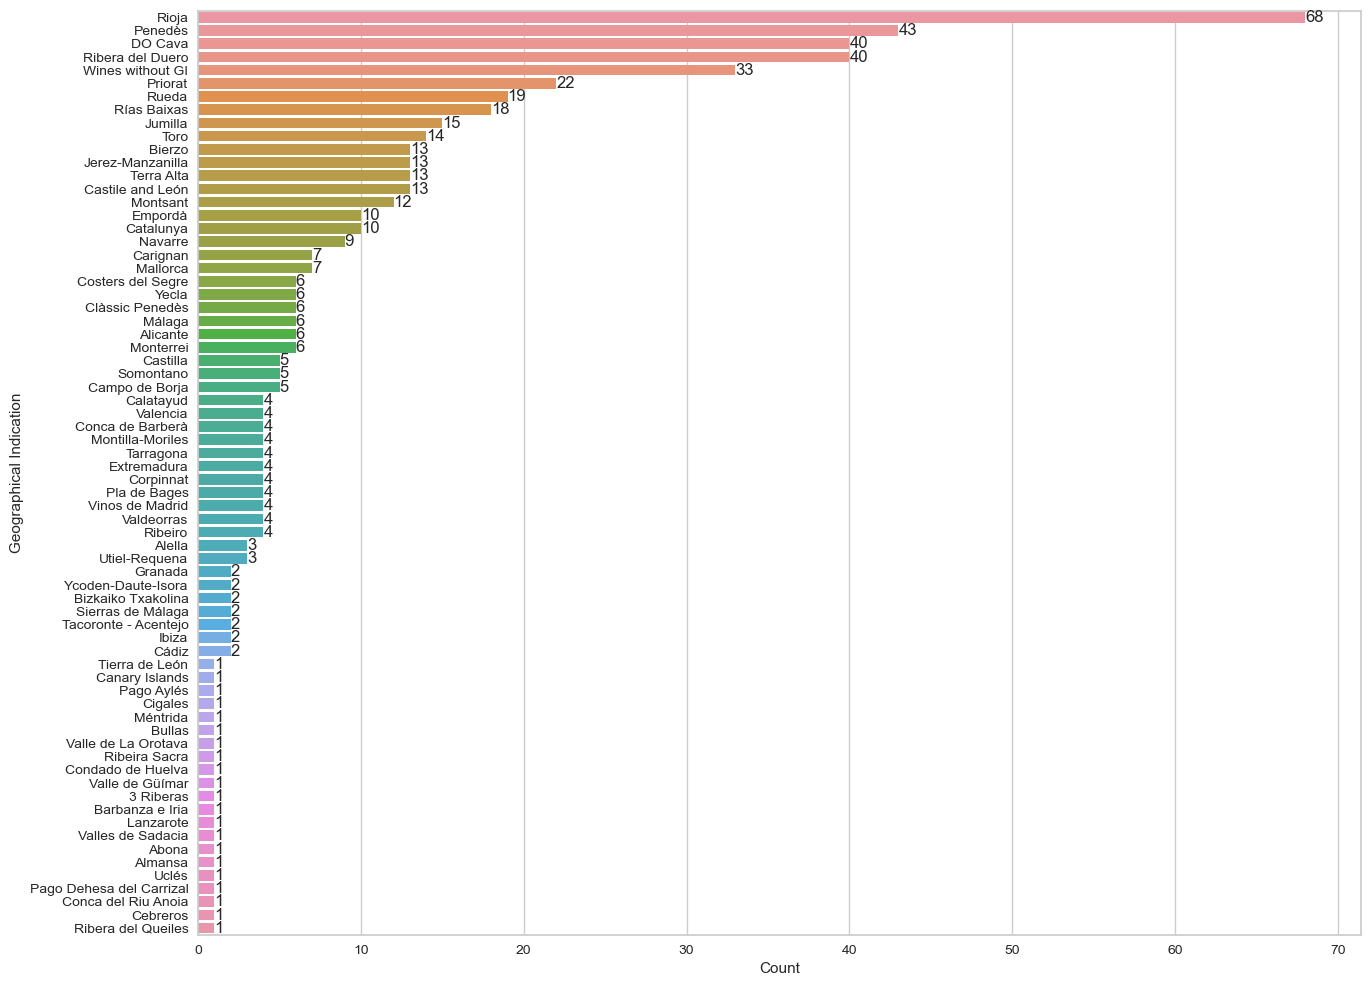

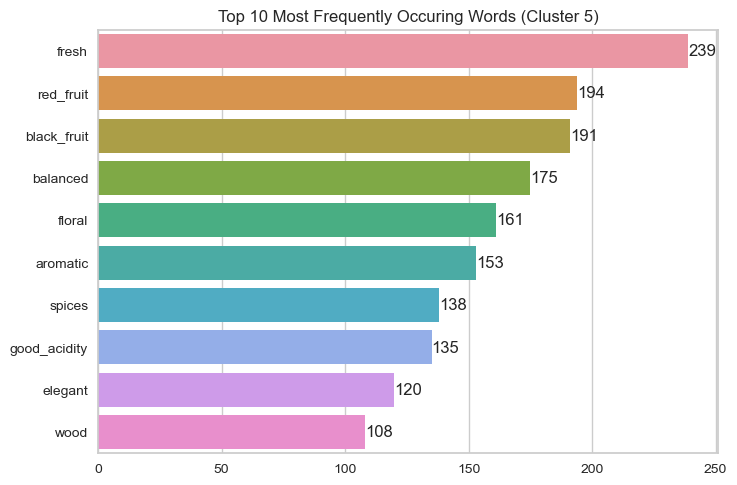

CLUSTER 6
The size of this cluster is 84 wines


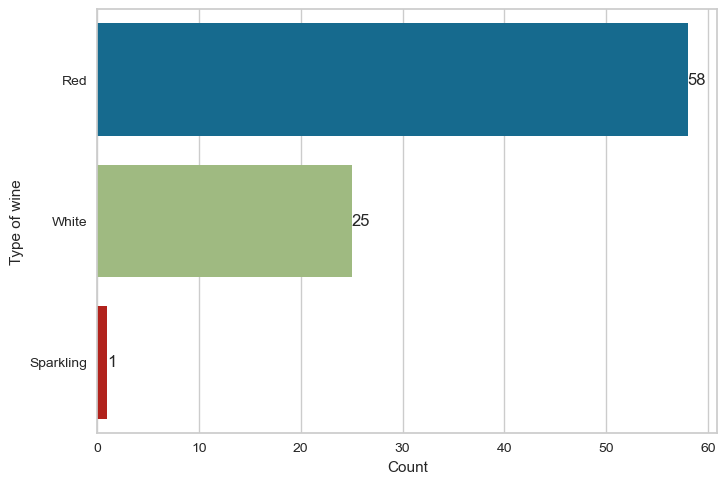

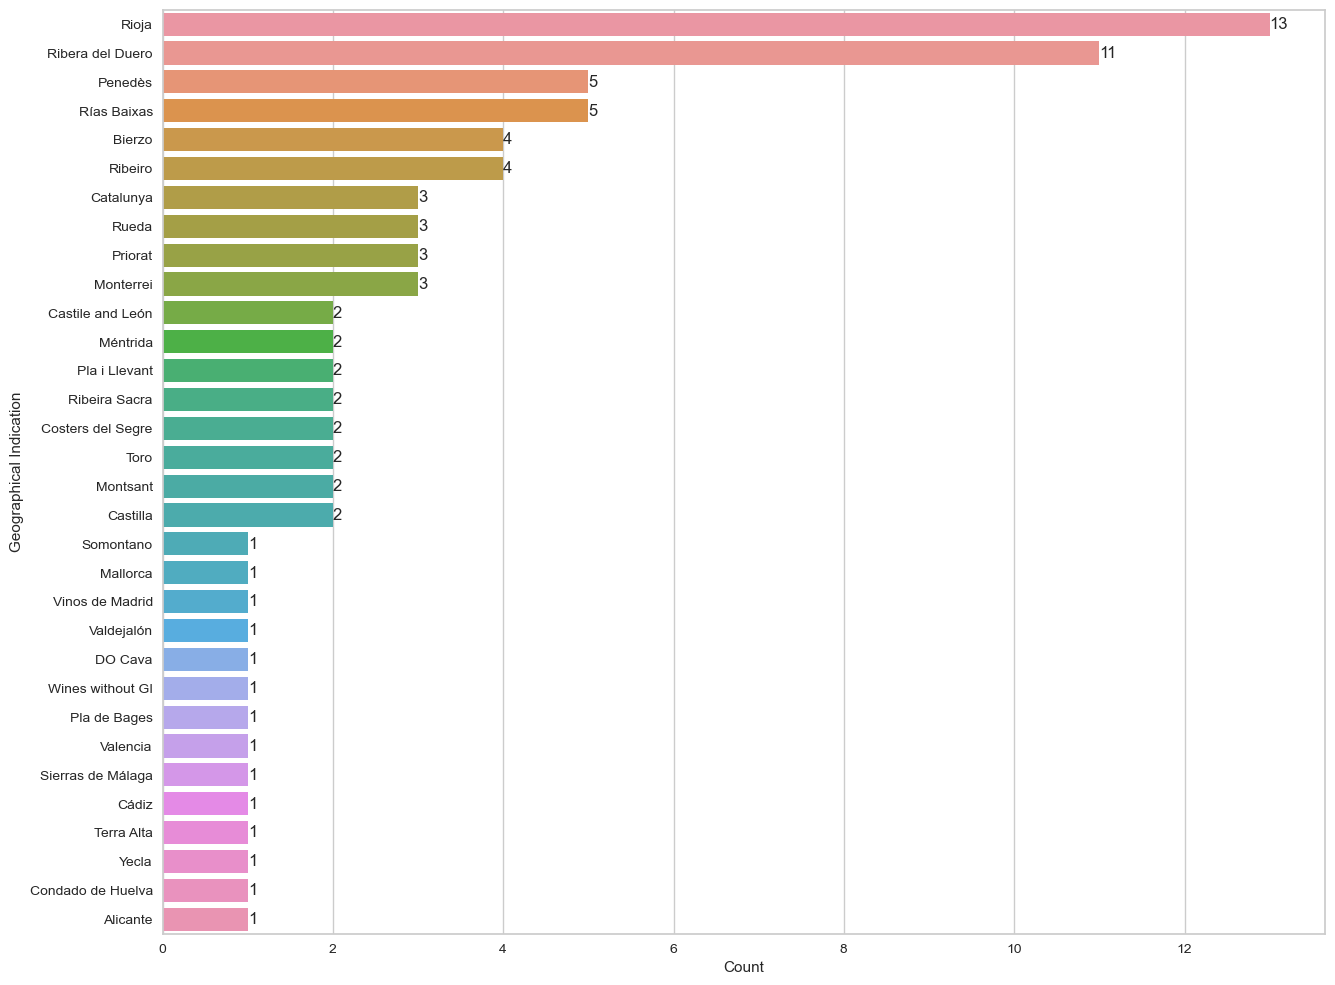

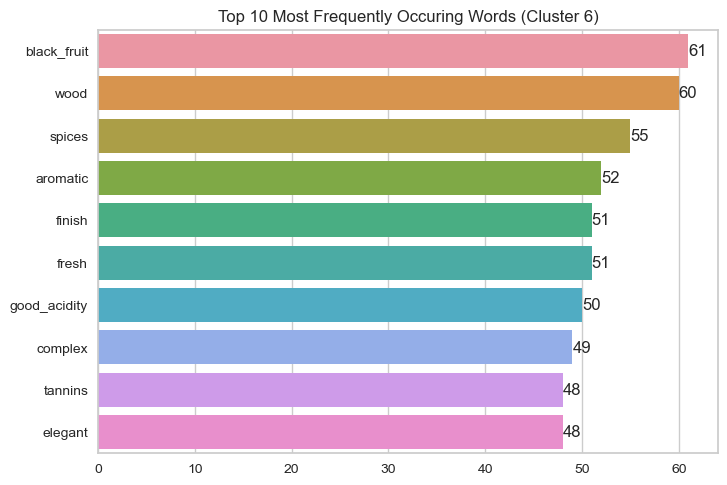

CLUSTER 7
The size of this cluster is 140 wines


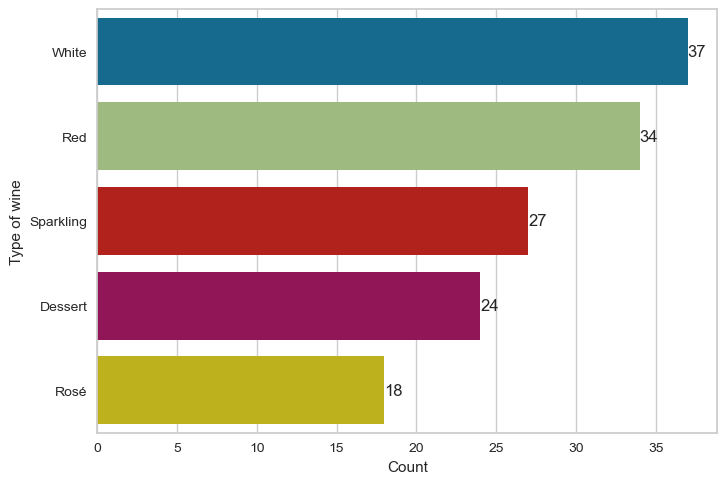

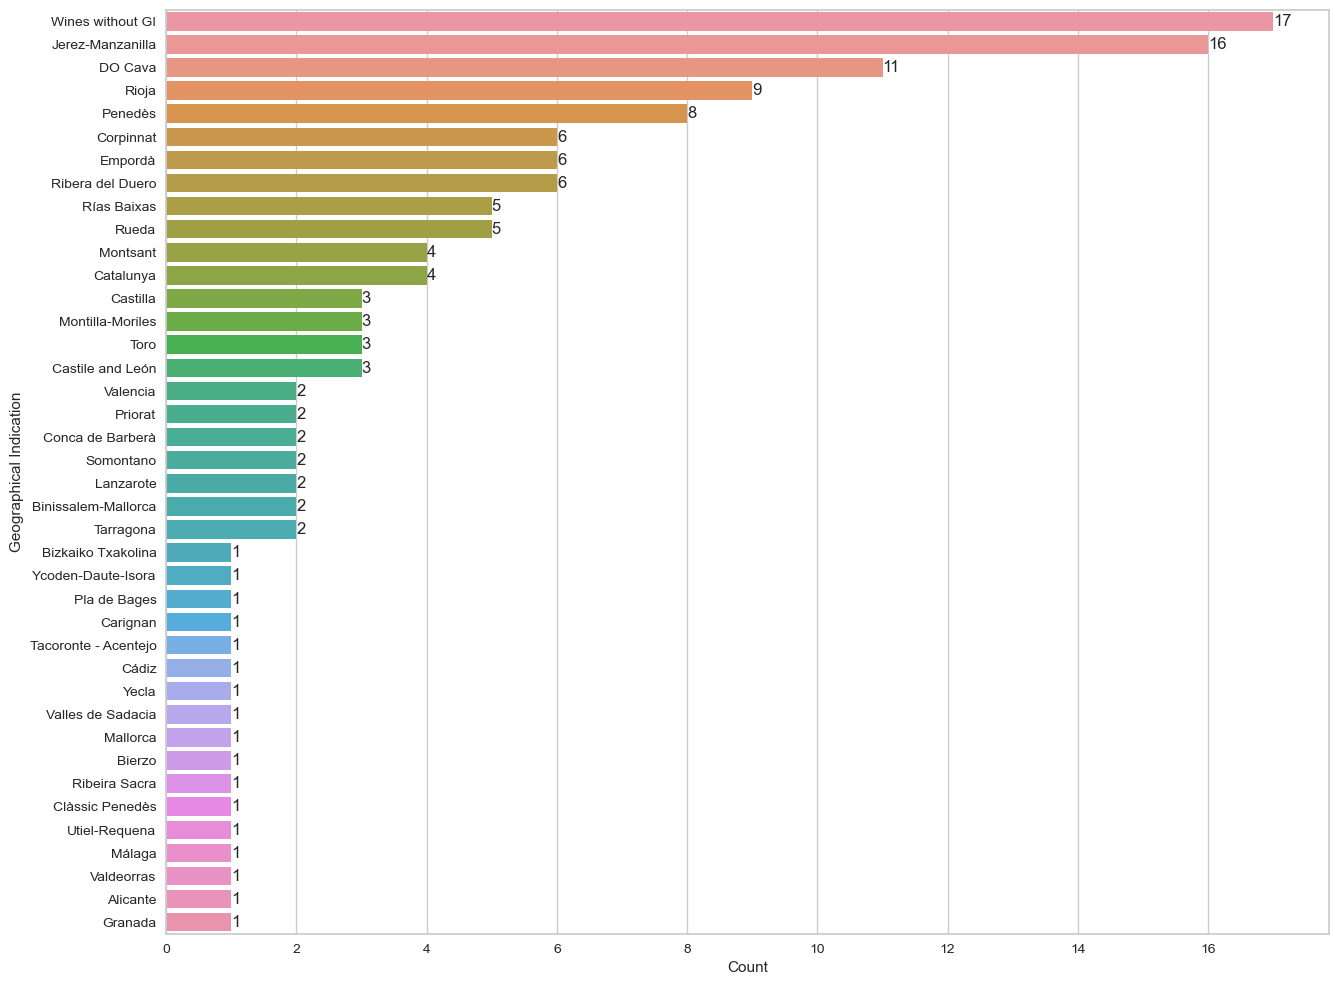

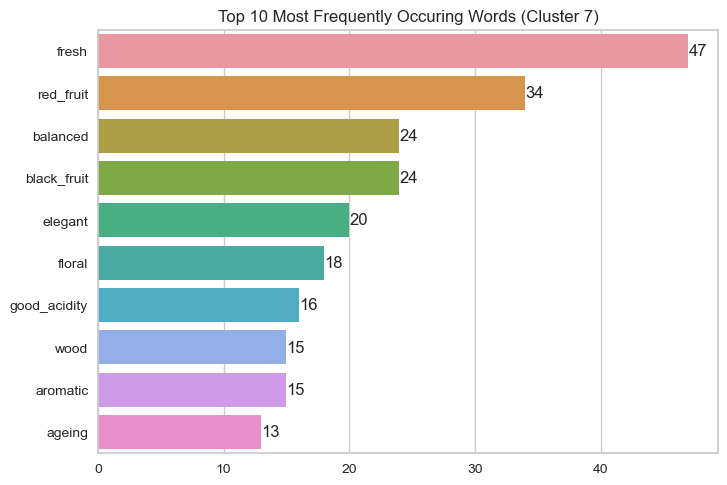

CLUSTER 8
The size of this cluster is 593 wines


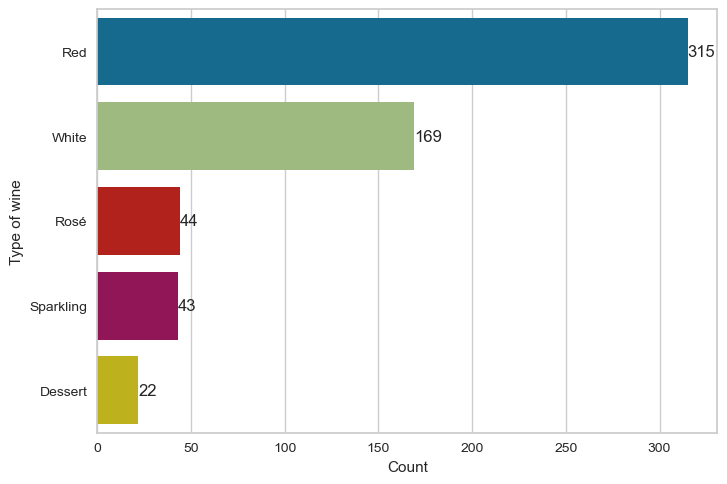

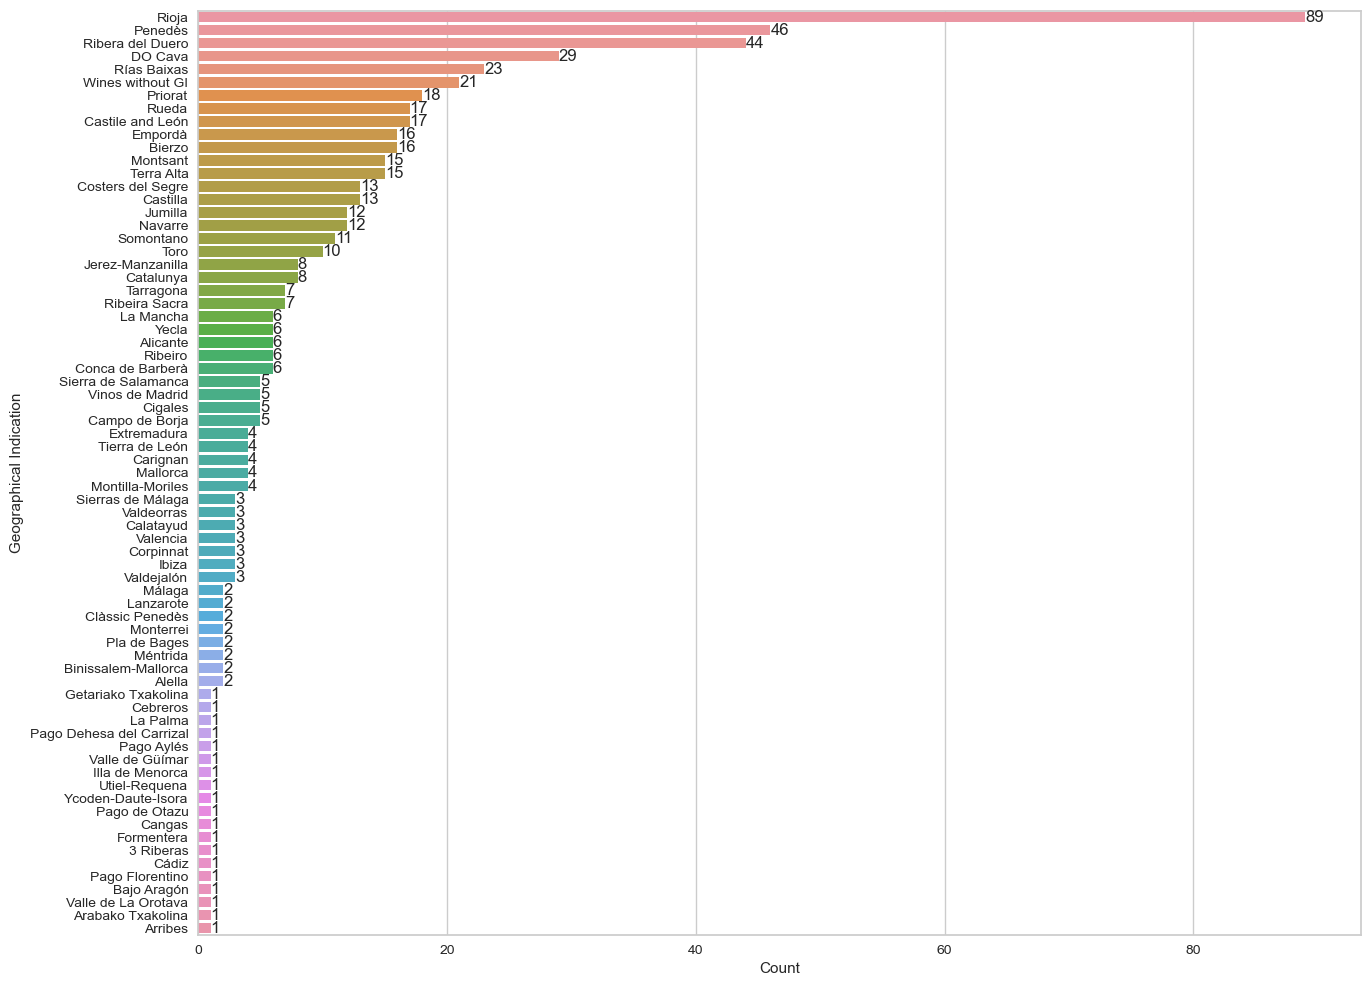

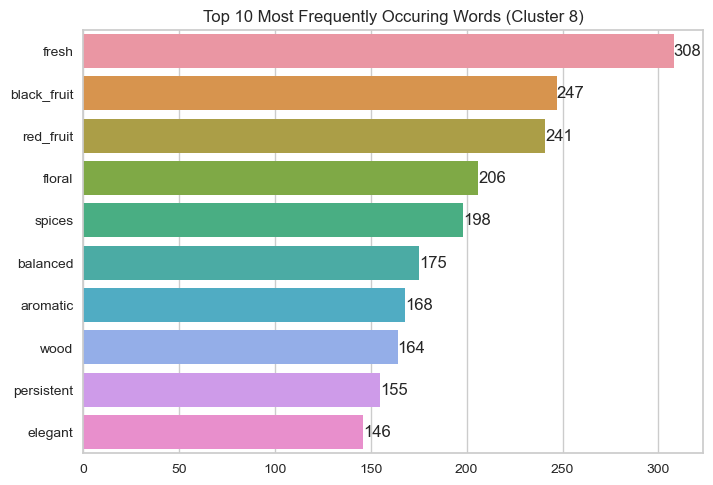

CLUSTER 9
The size of this cluster is 202 wines


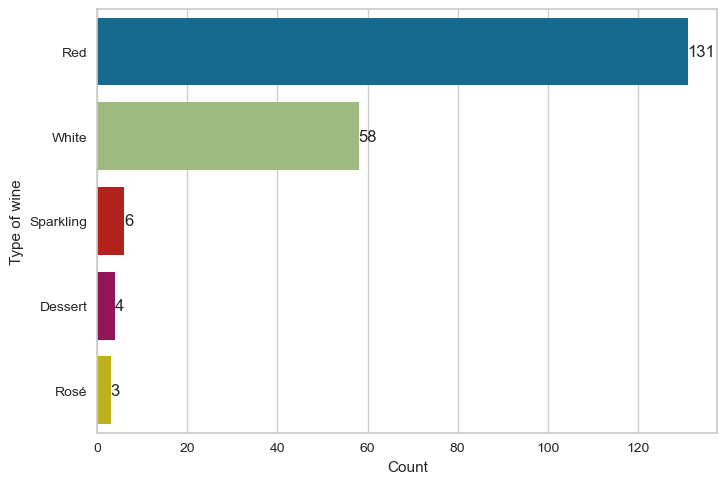

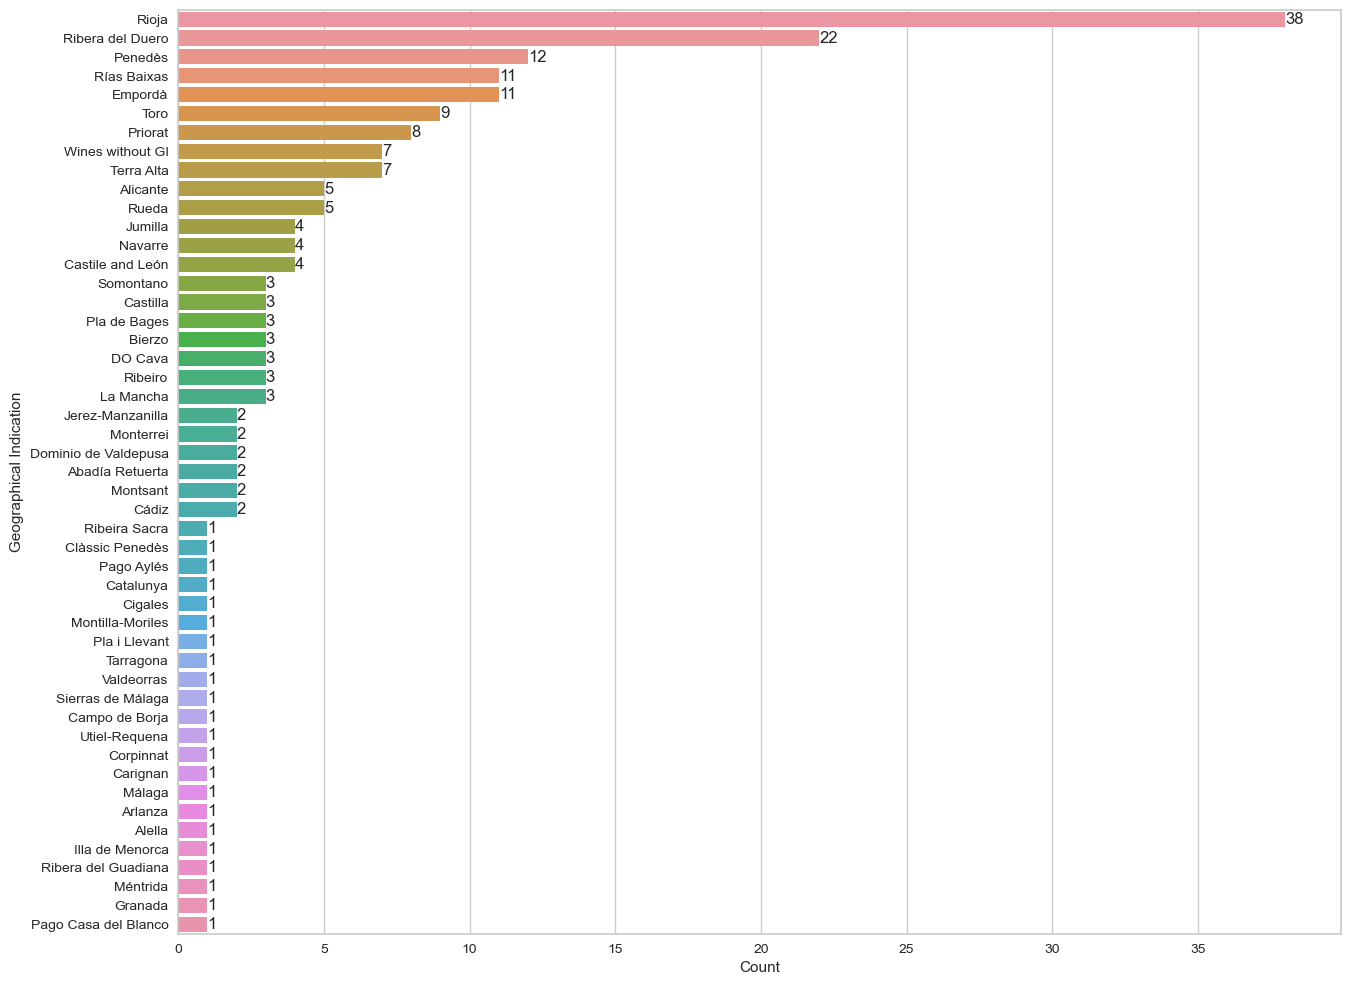

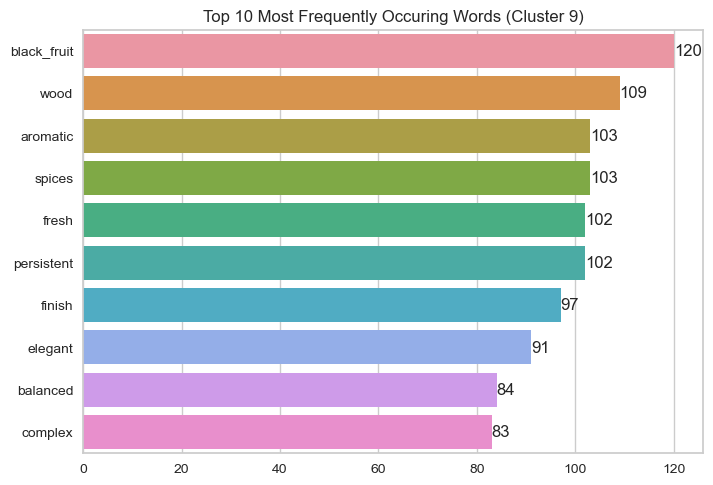

CLUSTER 10
The size of this cluster is 477 wines


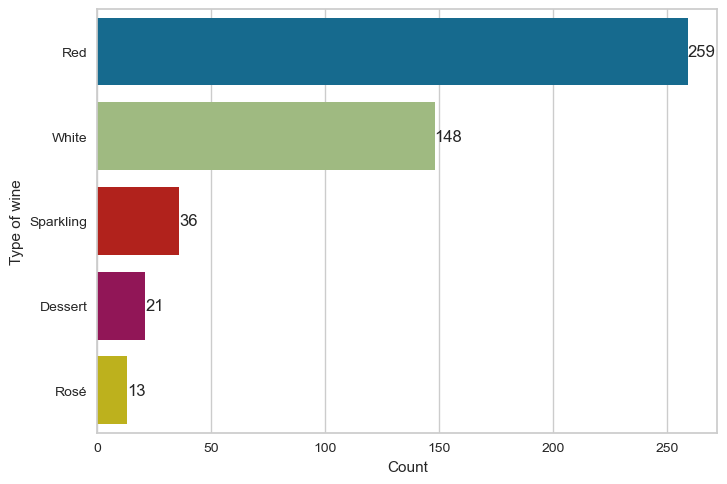

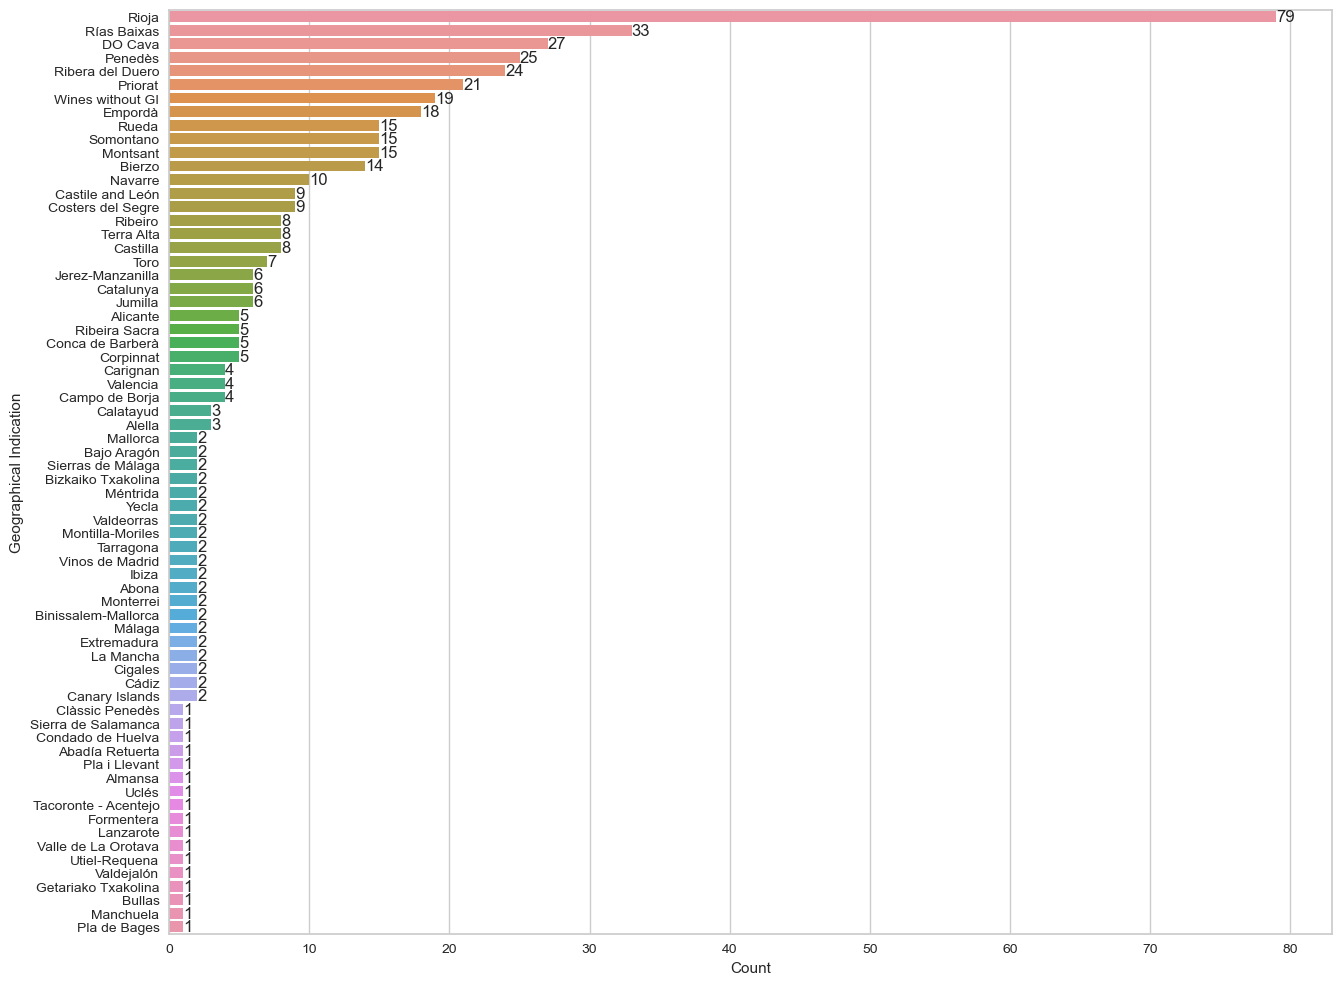

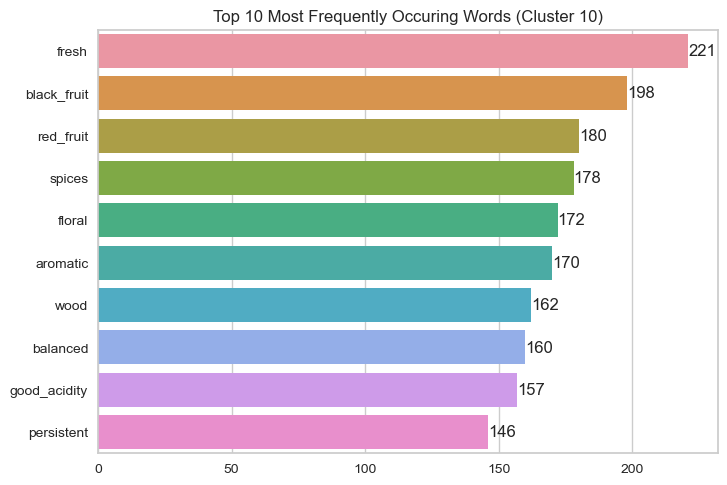

CLUSTER 11
The size of this cluster is 290 wines


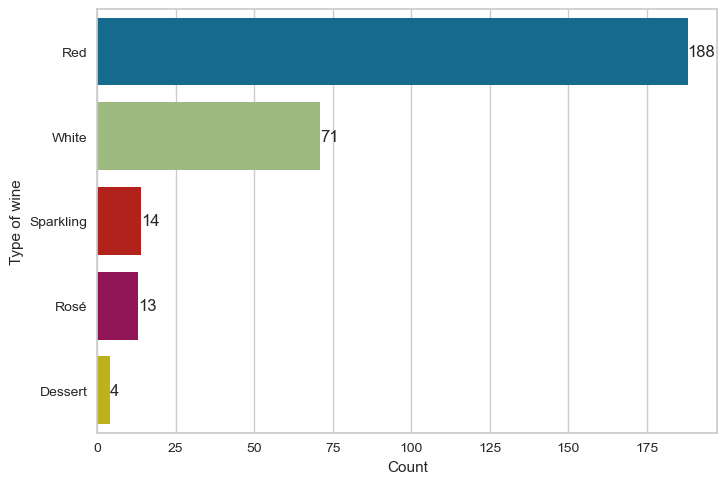

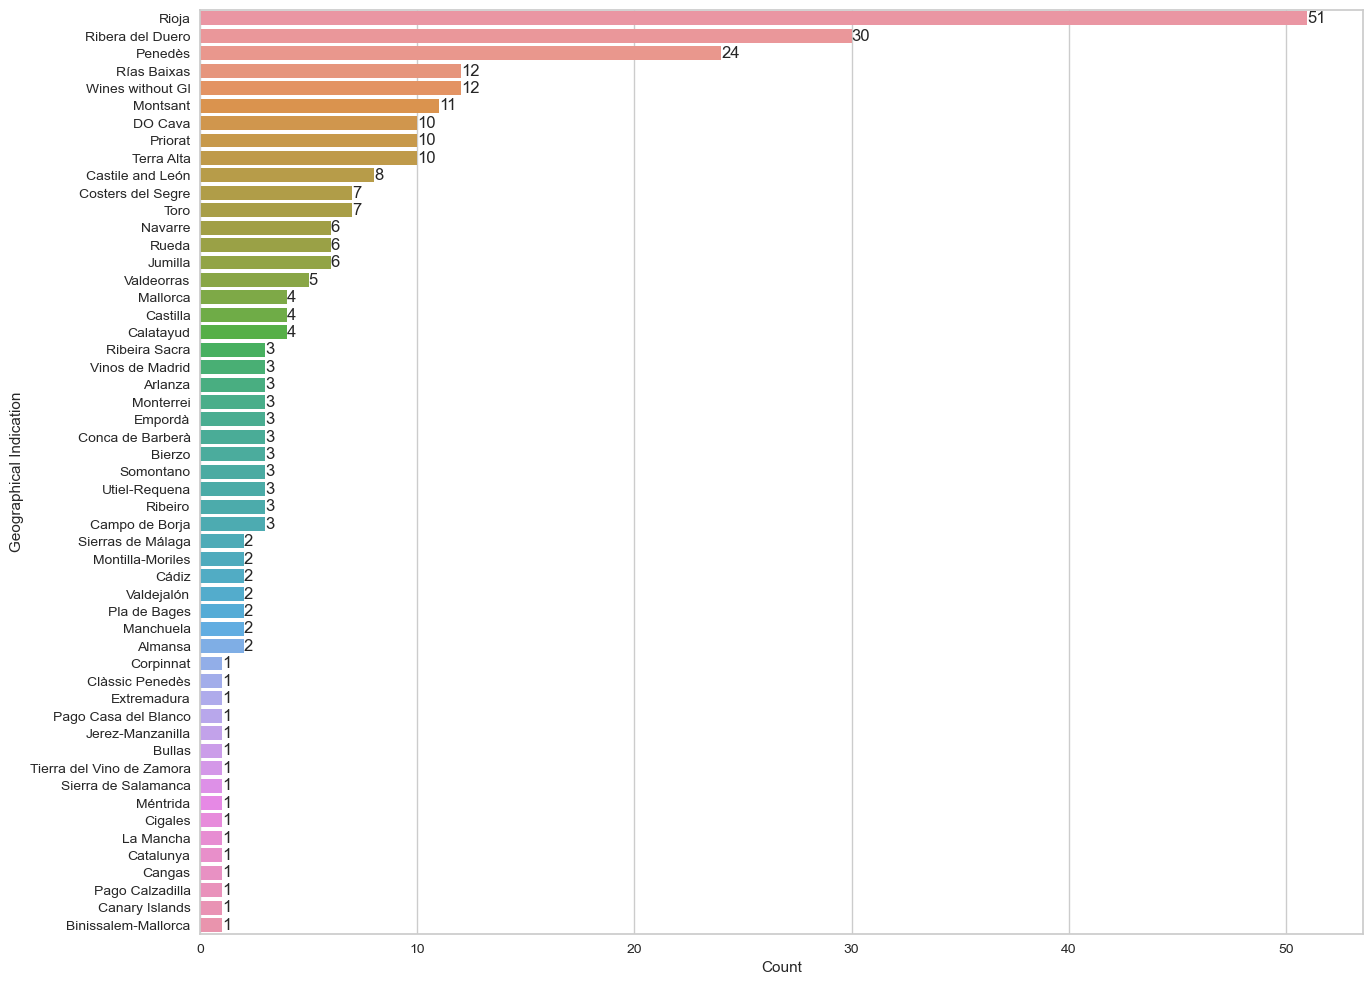

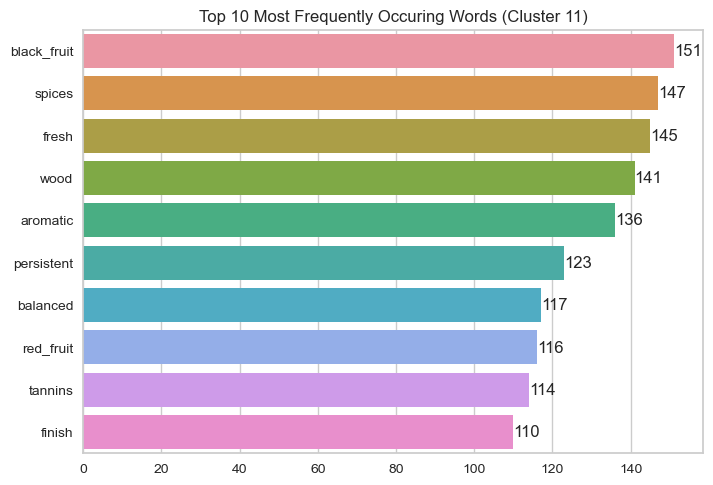

CLUSTER 12
The size of this cluster is 233 wines


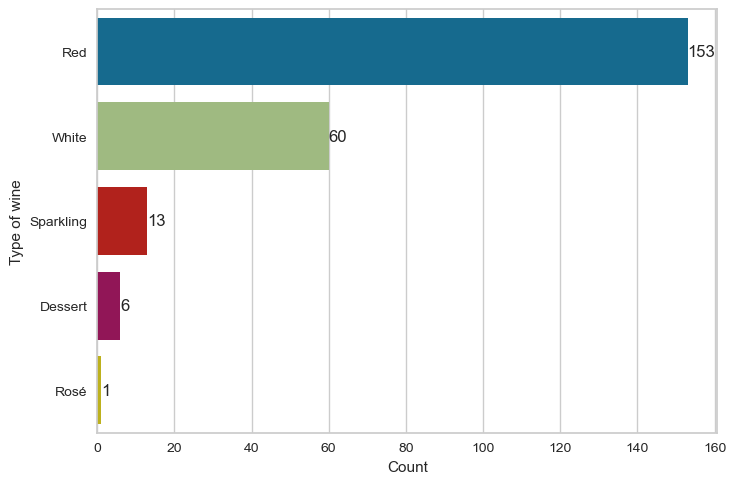

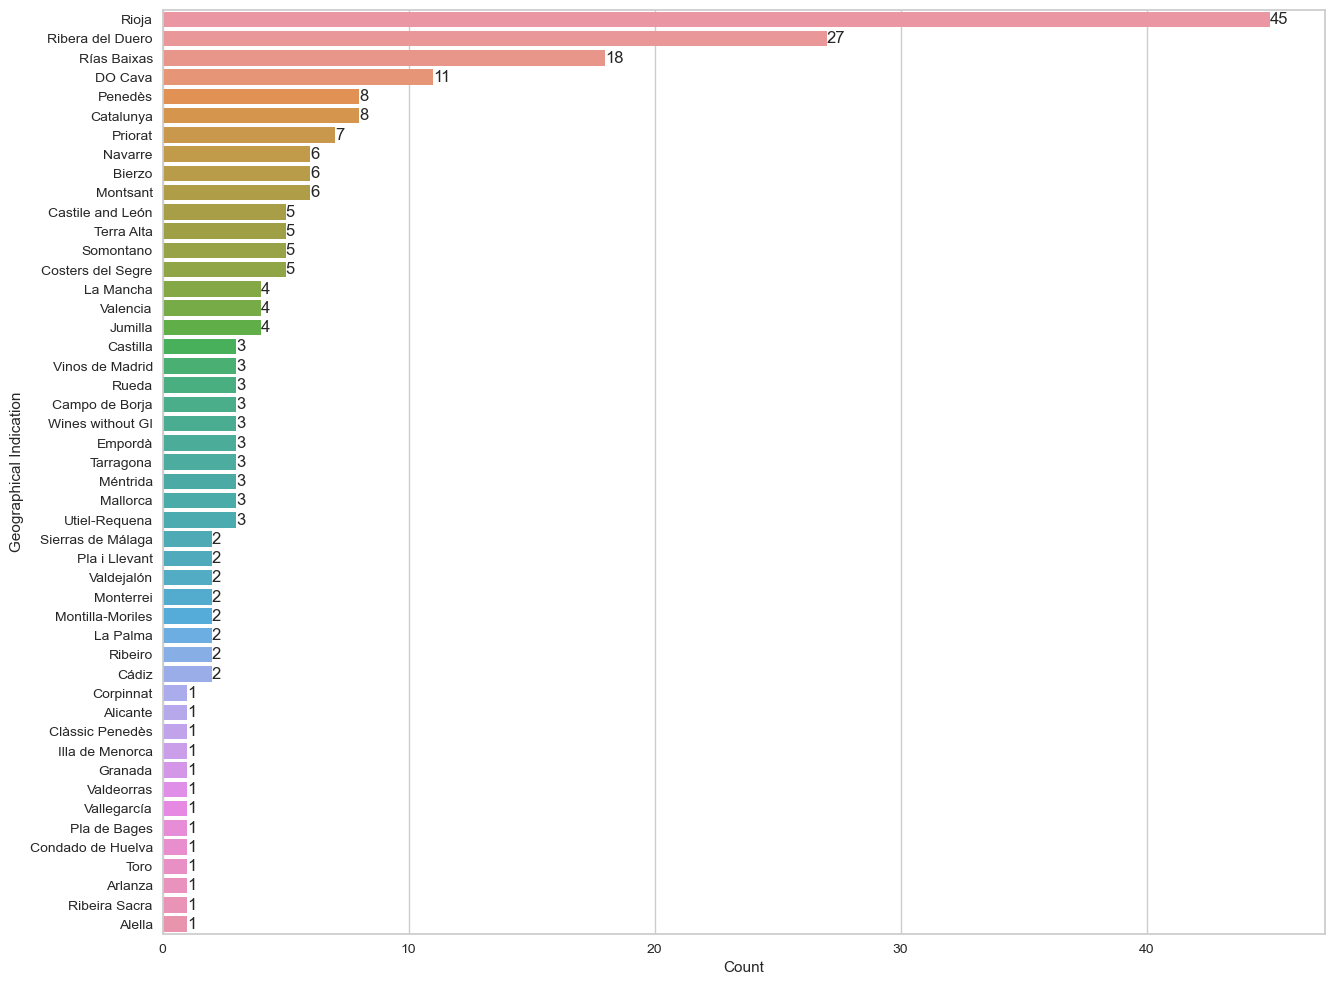

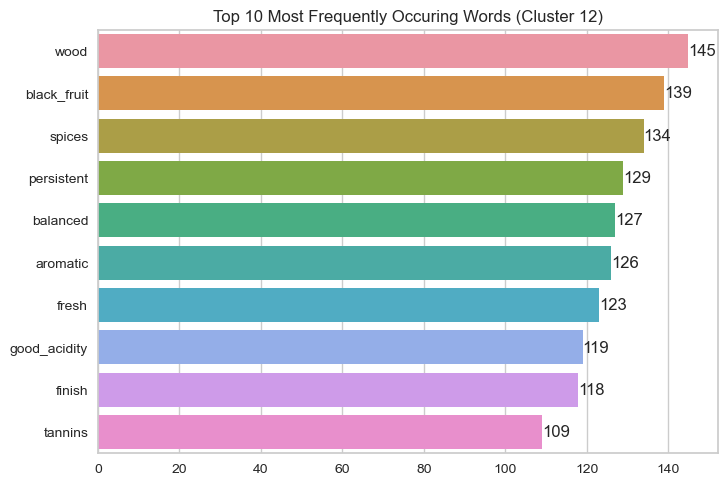

In [127]:
for cluster in range(0,13):
    explore_clusters(text_data, "notes_norm_removed_new_reduction_dropped", "cluster13", cluster)

# Add embeddings to final dataframe

In [130]:
vector = np.array(tfidf_embeddings).tolist()
text_data["embeddings"] = vector

In [131]:
text_data.columns

Index(['wine', 'year', 'winery', 'winery_norm', 'price', 'bottle', 'type_wine',
       'type_wine_details', 'type_agriculture', 'region', 'region_gi',
       'grapes', 'num_varieties', 'wine_description', 'tasting_descr',
       'tasting_view', 'tasting_bouquet', 'tasting_mouth', 'serve_temperature',
       'food_pairing', 'alcohol_content', 'customer_reviews',
       'customer_reviews_number', 'parker_score', 'parker_score_num',
       'penin_score', 'image', 'url', 'bouquet_norm', 'mouth_norm',
       'tasting_notes', 'notes_norm', 'bouquet_norm_removed',
       'mouth_norm_removed', 'notes_norm_removed', 'lists',
       'notes_norm_removed_joined', 'notes_norm_removed_reduced',
       'notes_norm_removed_reduced50', 'notes_norm_removed_reduced100',
       'notes_norm_removed_reduced150', 'notes_norm_removed_reduced200',
       'notes_norm_removed_reduced250', 'notes_norm_removed_reduced300',
       'notes_norm_removed_new_reduction',
       'notes_norm_removed_new_reduction_dropped'

In [133]:
drop_cols = ['wine_description', 'tasting_descr',
       'tasting_view', 'tasting_bouquet', 'tasting_mouth', 'serve_temperature',
       'food_pairing', 'bouquet_norm', 'mouth_norm', 'notes_norm', 'bouquet_norm_removed',
       'mouth_norm_removed', 'notes_norm_removed', 'lists',
       'notes_norm_removed_joined', 'notes_norm_removed_reduced',
       'notes_norm_removed_reduced50', 'notes_norm_removed_reduced100',
       'notes_norm_removed_reduced150', 'notes_norm_removed_reduced200',
       'notes_norm_removed_reduced250', 'notes_norm_removed_reduced300',
       'notes_norm_removed_new_reduction', 'tasting_vectors',
       'lists_notes_norm_removed_reduced', 'column_list']

text_data = text_data.drop(drop_cols, axis=1)

In [137]:
text_data.head()

wine    year                  winery  \
0            Ultreia Saint Jacques 2021  2021.0   Raúl Pérez Viticultor   
1                        Blanc Pescador     NaN                Perelada   
2  Bach Extrísimo Blanco Semidulce 2021  2021.0              Masia Bach   
3            José Pariente Verdejo 2022  2022.0  Bodegas José Pariente    
4             Coto de Imaz Reserva 2018  2018.0        El Coto de Rioja   

             winery_norm  price  bottle  type_wine type_wine_details  \
0  raul perez viticultor   16.2    0.75        Red               Red   
1               perelada    7.8    0.75  Sparkling   Frizzante white   
2             masia bach    9.4    0.75      White             White   
3         jose pariente    16.2    0.75      White             White   
4       el coto de rioja   13.0    0.75        Red               Red   

  type_agriculture            region  ... parker_score parker_score_num  \
0     Conventional   Castilla y León  ...          NaN              NaN   
1     Conventional  Wines without GI  ...          NaN              NaN   
2     Conventional          Cataluña  ...          NaN              NaN   
3     Conventional   Castilla y León  ...          NaN              NaN   
4     Conventional          La Rioja  ...          NaN              NaN   

  penin_score                                              image  \
0         NaN  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
1         NaN  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
2         NaN  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
3         NaN  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
4         NaN  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   

                                                 url  \
0  https://www.vinissimus.com/en/wine/ultreia-sai...   
1  https://www.vinissimus.com/en/wine/blanc-pesca...   
2  https://www.vinissimus.com/en/wine/bach-extris...   
3  https://www.vinissimus.com/en/wine/jose-parien...   
4  https://www.vinissimus.com/en/wine/coto-de-ima...   

                                       tasting_notes  \
0  Red fruit / Mineral / Voluminous / Medium-bodi...   
1  Light / Pleasant / Sparkling / Aromatic / Frui...   
2  Good entry / Structured / Balanced / Good acid...   
3  Rich / Unctuous / Pleasant bitterness / White ...   
4  Fleshy / Powerful / Ripe tannins / Velvety / R...   

            notes_norm_removed_new_reduction_dropped  \
0               red_fruit mineral black_fruit floral   
1                                  pleasant aromatic   
2  structured balanced good_acidity persistent ar...   
3        rich unctuous white_fruit stone_fruit herbs   
4        powerful tannins black_fruit spices complex   

                                          embeddings  cluster11 cluster13  
0  [0.010368325747549534, 0.054386626929044724, -...          1         1  
1  [0.010398883372545242, 0.0519464947283268, -0....          4         2  
2  [0.006561089772731066, 0.03554246947169304, -0...          7         0  
3  [0.008630958385765553, 0.04478497430682182, -0...          5         3  
4  [0.009208849631249905, 0.05225313454866409, -0...          5         3  

[5 rows x 26 columns]

In [138]:
text_data.to_csv("wine_clusters.csv", index=False)

# Conclusion
KMeans with 13 clusters, embeddings250.

In [ ]:
def embeddings(df, column):
    # Embeddings
    df["column_list"] = df[column].str.split()
    notes = df["column_list"]
    w2v_model = Word2Vec(min_count=70,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
    w2v_model.build_vocab(notes, progress_per=10000)
    w2v_model.train(notes, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
    
    def custom_tokenizer(text):
        return text.split()

    tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[column])

    tfidf_embeddings = []

    for idx in range(len(df)):
        tasting_note = df[column][idx]
        words = tasting_note.split()
        word_vectors = []
        for word in words:
            if word in w2v_model.wv:
                word_vector = w2v_model.wv[word]
                word_tfidf_score = tfidf_matrix[idx, tfidf_vectorizer.vocabulary_[word]]
                word_vectors.append(word_vector * word_tfidf_score)
        if word_vectors:
            tfidf_avg_vector = np.mean(word_vectors, axis=0)
        else:
            tfidf_avg_vector = np.zeros(word2vec_model.vector_size)  # Handle cases where no valid word vector is found
        tfidf_embeddings.append(tfidf_avg_vector)
    
    return tfidf_embeddings

In [ ]:
embeddings = embeddings(text_data, "notes_norm_removed_reduced250")

In [ ]:
kmeans = KMeans(n_clusters=13, random_state=42)
kmeans.fit(embeddings)
clusters = kmeans.predict(embeddings)